In [1]:
model_name = 'lightgbm'
device = 'cpu'
min_samples_per_class = 5
n_classes = 3
n_frac = 0.005
n_trials_tpe = 10
plot_param_importances = False
timeout_tpe = 60
random_state = 42
n_jobs = -1

In [2]:
# Parameters
model_name = "lightgbm"
device = "cpu"
min_samples_per_class = 5
n_classes = 8
n_frac = 0.1
n_trials_tpe = 1000
plot_param_importances = False
timeout_tpe = 3600
random_state = 42
n_jobs = -1


In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# UTILS

In [4]:
def stratified_sample_df(df, stratify_col, frac, min_samples_per_class, random_state):
    grouped = df.groupby(stratify_col)
    sample = grouped.apply(
        lambda x: x.sample(
            n=max(min_samples_per_class, int(len(x) * frac)), 
            replace=len(x) < max(min_samples_per_class, int(len(x) * frac)),
            random_state=random_state
        )
    ).reset_index(drop=True)
    return sample

In [5]:
def build_classifier(extra_kwargs={}):
    clf = None
    if model_name in ['lgbm', 'lightgbm']:
        import lightgbm as lgb
        kwargs = {
            'device_type': device,
            'n_jobs': n_jobs,
            'objective': 'binary' if n_classes == 2 else 'multiclass',
            'random_state': random_state,
            'verbose': 1,
            **extra_kwargs
        }
        if n_classes > 2:
            kwargs['num_class'] = n_classes
        clf = lgb.LGBMClassifier(**kwargs)
    elif model_name in ['xgb', 'xgboost']:
        from xgboost import XGBClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBClassifier(**kwargs)
    elif model_name in ['xgbrf', 'xgboostrf']:
        from xgboost import XGBRFClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBRFClassifier(**kwargs)
    return clf

In [6]:
from collections import OrderedDict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def process_metrics(y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results = OrderedDict({
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'Recall (Weighted)': recall_weighted,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
        'F1 (Weighted)': f1_weighted
    })

    pprint(results, indent=4)

In [7]:
from sklearn.metrics import classification_report

def process_classification_report(y_test, y_pred):
    try:
        cr = classification_report(y_test, y_pred, digits=6, target_names=labels)
        print(cr)
    except Exception as e:
        print('Cloud not build/show classification report. Reason:', e)

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def process_confusion_matrix(y_test, y_pred):
    try:
        y_test_decoded = [index_to_label[label] for label in y_test]
        y_pred_decoded = [index_to_label[label] for label in y_pred]
        cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)
        cm = np.round(cm / 1000, 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(values_format='g')
    except Exception as e:
        print('Cloud not build/show confusion matrix. Reason:', e)

In [9]:
import numpy as np

def value_counts_to_dict(array):
    unique, counts = np.unique(array, return_counts=True)
    value_counts_dict = dict(zip(unique, counts))
    return value_counts_dict

# STEP 1: DATA PREP

In [10]:
# %load_ext cudf.pandas
import numpy as np
import pandas as pd
from pprint import pprint

if n_classes == 3: # dummy dataset
    df_sample = pd.read_parquet('input/dummy.parquet')
else:
    df_sample = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_sample['label'], unique_values = df_sample['label'].factorize()

label_to_index = {value: i for i, value in enumerate(unique_values)}
index_to_label = {v: k for k, v in label_to_index.items()}
labels = list(label_to_index.keys())
pprint(label_to_index, indent=4)

{   'Benign': 3,
    'BruteForce': 7,
    'DDoS': 0,
    'DoS': 1,
    'Mirai': 2,
    'Recon': 5,
    'Spoofing': 4,
    'WebBased': 6}


In [11]:
# not stratified df sampling (just to check)
df_sample['label'].sample(frac=n_frac, random_state=random_state).value_counts()

label
0    3397209
1     809281
2     264004
3     109844
4      48837
5      35677
6       2539
7       1267
Name: count, dtype: int64

In [12]:
# stratified df sampling
df_sample = stratified_sample_df(df_sample, 'label', n_frac, min_samples_per_class, random_state)

/tmp/ipykernel_1386754/2006267505.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = grouped.apply(


In [13]:
df_sample['label'].value_counts()

label
0    3398456
1     809073
2     263412
3     109819
4      48650
5      35456
6       2482
7       1306
Name: count, dtype: int64

In [14]:
X_sample = df_sample.drop('label', axis=1)

print(type(X_sample))
print(X_sample.shape)
print(X_sample.dtypes)

<class 'pandas.core.frame.DataFrame'>
(4668654, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Max

In [15]:
y_sample = df_sample['label']

print(type(y_sample))
print(y_sample.shape)
print(y_sample.dtype)
print(y_sample.unique())
print(y_sample.nunique())
y_sample.value_counts()

<class 'pandas.core.series.Series'>
(4668654,)
int64
[0 1 2 3 4 5 6 7]
8


label
0    3398456
1     809073
2     263412
3     109819
4      48650
5      35456
6       2482
7       1306
Name: count, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

# Split into 80% training+validation and 20% test
X_sample_train_val, X_sample_test, y_sample_train_val, y_sample_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=random_state, stratify=y_sample
)

# Split the 80% training+validation set into 75% training and 25% validation
X_sample_train, X_sample_val, y_sample_train, y_sample_val = train_test_split(
    X_sample_train_val, y_sample_train_val, test_size=0.25, random_state=random_state, stratify=y_sample_train_val
)

# Verify the sizes of the splits
print(f'Training   : {len(X_sample_train)}\t({(100.0 * len(X_sample_train) / len(X_sample)):.2f}) %\t{sorted(y_sample_train.unique())}')
print(f'Validation : {len(X_sample_val)}\t({(100.0 * len(X_sample_val) / len(X_sample)):.2f}) %\t{sorted(y_sample_val.unique())}')
print(f'Test       : {len(X_sample_test)}\t({(100.0 * len(X_sample_test) / len(X_sample)):.2f}) %\t{sorted(y_sample_test.unique())}')

Training   : 2801192	(60.00) %	[0, 1, 2, 3, 4, 5, 6, 7]
Validation : 933731	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7]
Test       : 933731	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7]


In [17]:
assert sorted(y_sample_train.unique()) == sorted(y_sample_val.unique())
assert sorted(y_sample_train.unique()) == sorted(y_sample_test.unique())
assert sorted(y_sample_val.unique()) == sorted(y_sample_test.unique())

# STEP 2: PREPROCESSING & FEATURE SELECTION

### Preprocessing Methods

In [18]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler, StandardScaler

class DummyPreprocessor:
    def fit(self, _X, _y=None):
        return self
    def transform(self, _X):
        return _X

def make_preprocessor(pp_method):
    preprocessor = None
    if pp_method == 'none':
        preprocessor = DummyPreprocessor()
    if pp_method == 'maxabs':
        preprocessor = MaxAbsScaler()
    elif pp_method == 'minmax':
        preprocessor = MinMaxScaler()
    elif pp_method == 'norm':
        preprocessor = Normalizer()
    elif pp_method == 'robust':
        preprocessor = RobustScaler()
    elif pp_method == 'standard':
        preprocessor = StandardScaler()
    return preprocessor

### Feature Selection Methods

In [19]:
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA

class DummyFeatureSelector:
    def fit(self, _X, _y, _eval_set=None):
        self.support_ = np.ones(_X.shape[1], dtype=bool)
        return self
    def transform(self, _X):
        return _X[:, self.support_]

def make_feature_selector(fs_method, fs_metric):
    feature_selector = None
    if fs_method == 'none':
        feature_selector = DummyFeatureSelector()
    elif fs_method == 'boruta':
        feature_selector = BoostBoruta(build_classifier(), importance_type=fs_metric, perc=100, sampling_seed=random_state)
    elif fs_method == 'rfa':
        feature_selector = BoostRFA(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    elif fs_method == 'rfe':
        feature_selector = BoostRFE(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    return feature_selector

### HPO

In [20]:
%%time

import optuna

from optuna.samplers import GridSampler

def objective(trial):

    try:
        # preprocessing hyperparameters
        pp_method = trial.suggest_categorical('pp_method', ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'])

        # feature selection hyperparameters
        fs_method = trial.suggest_categorical('fs_method', ['none', 'boruta', 'rfa', 'rfe'])
        fs_metric = trial.suggest_categorical('fs_metric', ['feature_importances', 'shap_importances'])
        
        # pipeline - preprocessing
        preprocessor = make_preprocessor(pp_method)
        preprocessor.fit(X_sample_train)
        X_sample_train_prep = pd.DataFrame(preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
        X_sample_val_prep = pd.DataFrame(preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
        X_sample_test_prep = pd.DataFrame(preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)
    
        # pipeline - feature selection
        feature_selector = make_feature_selector(fs_method, fs_metric)
        feature_selector.fit(X_sample_train_prep, y_sample_train, eval_set=[(X_sample_val_prep, y_sample_val)])
        selected_features = X_sample_train_prep.columns[feature_selector.support_]
        trial.set_user_attr('selected_features', selected_features)
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_prep[selected_features], y_sample_train)
        y_sample_pred = model.predict(X_sample_test_prep[selected_features])
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'pp_method': ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'],
    'fs_method': ['boruta', 'rfa', 'rfe'],
    'fs_metric': ['feature_importances', 'shap_importances']
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-08-06 14:31:01,002] A new study created in memory with name: no-name-0474779f-4416-468c-8f36-a88ffa9a12f3


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 6
[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 14:49:11,854] Trial 0 finished with value: 0.6945648495977896 and parameters: {'pp_method': 'none', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 0 with value: 0.6945648495977896.


[I 2024-08-06 15:13:18,839] Trial 1 pruned. 


index 7 is out of bounds for axis 0 with size 6


[I 2024-08-06 15:38:34,651] Trial 2 pruned. 


index 7 is out of bounds for axis 0 with size 6


[I 2024-08-06 16:02:44,993] Trial 3 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-08-06 16:27:50,999] Trial 4 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-08-06 16:33:29,802] Trial 5 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 9
[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 16:51:59,685] Trial 6 finished with value: 0.6949870061540331 and parameters: {'pp_method': 'standard', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 6 with value: 0.6949870061540331.


[I 2024-08-06 17:19:40,911] Trial 7 pruned. 


index 7 is out of bounds for axis 0 with size 6


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023411 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2506
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 10
[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 17:31:19,435] Trial 8 finished with value: 0.6710807808259718 and parameters: {'pp_method': 'norm', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 6 with value: 0.6949870061540331.


[I 2024-08-06 17:56:22,835] Trial 9 pruned. 


index 6 is out of bounds for axis 0 with size 6


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1966
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 8
[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 18:06:20,256] Trial 10 finished with value: 0.7112091727984059 and parameters: {'pp_method': 'none', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 10 with value: 0.7112091727984059.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030621 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5056
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 20


[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 18:26:09,698] Trial 11 finished with value: 0.7159811832250027 and parameters: {'pp_method': 'norm', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.7159811832250027.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024308 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1966
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 8
[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 18:35:22,351] Trial 12 finished with value: 0.6546054798476131 and parameters: {'pp_method': 'minmax', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.7159811832250027.


[I 2024-08-06 18:41:30,813] Trial 13 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[I 2024-08-06 19:05:40,059] Trial 14 pruned. 


index 7 is out of bounds for axis 0 with size 6


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009196 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1456
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 6
[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 19:15:34,909] Trial 15 finished with value: 0.6591834495967256 and parameters: {'pp_method': 'maxabs', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.7159811832250027.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4558
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 18
[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 19:33:30,320] Trial 16 finished with value: 0.6763865408794456 and parameters: {'pp_method': 'robust', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.7159811832250027.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5025
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 34


[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 19:44:15,643] Trial 17 finished with value: 0.7006383502687045 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.7159811832250027.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042855 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5027
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 34


[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 19:55:00,716] Trial 18 finished with value: 0.6904850213007222 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.7159811832250027.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5276
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 32


[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 20:12:58,620] Trial 19 finished with value: 0.6154602729765783 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.7159811832250027.


[I 2024-08-06 20:18:31,787] Trial 20 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028121 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3496
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 14
[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 20:29:31,861] Trial 21 finished with value: 0.6836976225766376 and parameters: {'pp_method': 'none', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.7159811832250027.


[I 2024-08-06 20:35:21,572] Trial 22 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[I 2024-08-06 20:59:47,052] Trial 23 pruned. 


index 7 is out of bounds for axis 0 with size 6


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1498
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 6
[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 21:09:23,014] Trial 24 finished with value: 0.6323094027521122 and parameters: {'pp_method': 'robust', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.7159811832250027.


[I 2024-08-06 21:34:48,070] Trial 25 pruned. 


index 6 is out of bounds for axis 0 with size 6


[I 2024-08-06 21:58:55,223] Trial 26 pruned. 


index 7 is out of bounds for axis 0 with size 6


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1516
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 6
[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 22:09:30,313] Trial 27 finished with value: 0.6870063205817212 and parameters: {'pp_method': 'standard', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.7159811832250027.


[I 2024-08-06 22:35:12,503] Trial 28 pruned. 


index 6 is out of bounds for axis 0 with size 6


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5012
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 34


[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 22:46:03,125] Trial 29 finished with value: 0.6219122598708124 and parameters: {'pp_method': 'standard', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.7159811832250027.


[I 2024-08-06 22:51:59,228] Trial 30 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[I 2024-08-06 23:18:23,751] Trial 31 pruned. 


index 6 is out of bounds for axis 0 with size 6


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 9
[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 23:28:59,719] Trial 32 finished with value: 0.7056535268898372 and parameters: {'pp_method': 'robust', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.7159811832250027.


[I 2024-08-06 23:34:33,855] Trial 33 pruned. 


shape mismatch: value array of shape (46,8) could not be broadcast to indexing result of shape (46,)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2295
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 9
[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-06 23:52:43,361] Trial 34 finished with value: 0.6995124333116814 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.7159811832250027.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1486
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 6
[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-07 00:07:24,819] Trial 35 finished with value: 0.6155583814209249 and parameters: {'pp_method': 'norm', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 11 with value: 0.7159811832250027.


CPU times: user 23d 14h 30min 11s, sys: 15min 29s, total: 23d 14h 45min 40s
Wall time: 9h 36min 23s


In [21]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.694565 2024-08-06 14:31:01.002927 2024-08-06 14:49:11.854613   
1        1       NaN 2024-08-06 14:49:11.855718 2024-08-06 15:13:18.839653   
2        2       NaN 2024-08-06 15:13:18.840459 2024-08-06 15:38:34.651392   
3        3       NaN 2024-08-06 15:38:34.652329 2024-08-06 16:02:44.993519   
4        4       NaN 2024-08-06 16:02:44.994455 2024-08-06 16:27:50.999500   
5        5       NaN 2024-08-06 16:27:51.000425 2024-08-06 16:33:29.802107   
6        6  0.694987 2024-08-06 16:33:29.802918 2024-08-06 16:51:59.685472   
7        7       NaN 2024-08-06 16:51:59.686530 2024-08-06 17:19:40.911466   
8        8  0.671081 2024-08-06 17:19:40.912384 2024-08-06 17:31:19.435245   
9        9       NaN 2024-08-06 17:31:19.436300 2024-08-06 17:56:22.835623   
10      10  0.711209 2024-08-06 17:56:22.836454 2024-08-06 18:06:20.256519   
11      11  0.715981 2024-08-06 18:06:20.257289 2024-08-06 18:26:09.698452   
12      12  0.654605 2024-08-06 18:26:09.699494 2024-08-06 18:35:22.351465   
13      13       NaN 2024-08-06 18:35:22.352502 2024-08-06 18:41:30.813169   
14      14       NaN 2024-08-06 18:41:30.814112 2024-08-06 19:05:40.059442   
15      15  0.659183 2024-08-06 19:05:40.060097 2024-08-06 19:15:34.909200   
16      16  0.676387 2024-08-06 19:15:34.910257 2024-08-06 19:33:30.320685   
17      17  0.700638 2024-08-06 19:33:30.321697 2024-08-06 19:44:15.642866   
18      18  0.690485 2024-08-06 19:44:15.643729 2024-08-06 19:55:00.715921   
19      19  0.615460 2024-08-06 19:55:00.716789 2024-08-06 20:12:58.620518   
20      20       NaN 2024-08-06 20:12:58.621568 2024-08-06 20:18:31.787422   
21      21  0.683698 2024-08-06 20:18:31.788323 2024-08-06 20:29:31.861554   
22      22       NaN 2024-08-06 20:29:31.862462 2024-08-06 20:35:21.572134   
23      23       NaN 2024-08-06 20:35:21.573013 2024-08-06 20:59:47.052396   
24      24  0.632309 2024-08-06 20:59:47.053170 2024-08-06 21:09:23.014671   
25      25       NaN 2024-08-06 21:09:23.015736 2024-08-06 21:34:48.070603   
26      26       NaN 2024-08-06 21:34:48.071315 2024-08-06 21:58:55.223514   
27      27  0.687006 2024-08-06 21:58:55.224349 2024-08-06 22:09:30.312849   
28      28       NaN 2024-08-06 22:09:30.313650 2024-08-06 22:35:12.503726   
29      29  0.621912 2024-08-06 22:35:12.504538 2024-08-06 22:46:03.125547   
30      30       NaN 2024-08-06 22:46:03.126627 2024-08-06 22:51:59.228485   
31      31       NaN 2024-08-06 22:51:59.229408 2024-08-06 23:18:23.751023   
32      32  0.705654 2024-08-06 23:18:23.751546 2024-08-06 23:28:59.718867   
33      33       NaN 2024-08-06 23:28:59.719921 2024-08-06 23:34:33.855444   
34      34  0.699512 2024-08-06 23:34:33.856155 2024-08-06 23:52:43.360892   
35      35  0.615558 2024-08-06 23:52:43.361943 2024-08-07 00:07:24.819057   

                 duration params_fs_method     params_fs_metric  \
0  0 days 00:18:10.851686              rfa  feature_importances   
1  0 days 00:24:06.983935              rfe     shap_importances   
2  0 days 00:25:15.810933              rfa     shap_importances   
3  0 days 00:24:10.341190              rfe     shap_importances   
4  0 days 00:25:06.005045              rfa     shap_importances   
5  0 days 00:05:38.801682           boruta     shap_importances   
6  0 days 00:18:29.882554              rfa  feature_importances   
7  0 days 00:27:41.224936              rfa     shap_importances   
8  0 days 00:11:38.522861              rfe  feature_importances   
9  0 days 00:25:03.399323              rfa     shap_importances   
10 0 days 00:09:57.420065           boruta  feature_importances   
11 0 days 00:19:49.441163              rfa  feature_importances   
12 0 days 00:09:12.651971           boruta  feature_importances   
13 0 days 00:06:08.460667           boruta     shap_importances   
14 0 days 00:24:09.245330              rfe     shap_importances   
15 0 days 00:09:54.849103           boruta  f

In [22]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [23]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [24]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [25]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

[W 2024-08-07 00:07:25,795] Param fs_metric unique value length is less than 2.


[W 2024-08-07 00:07:25,795] Param fs_metric unique value length is less than 2.


[W 2024-08-07 00:07:25,796] Param fs_metric unique value length is less than 2.


[W 2024-08-07 00:07:25,796] Param fs_metric unique value length is less than 2.


In [26]:
best_preprocessor = make_preprocessor(study.best_trial.params['pp_method'])
best_preprocessor.fit(X_sample_train)
X_sample_train = pd.DataFrame(best_preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
X_sample_val = pd.DataFrame(best_preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
X_sample_test = pd.DataFrame(best_preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)

best_selected_features = study.best_trial.user_attrs['selected_features']
X_sample_train = X_sample_train[best_selected_features]
X_sample_val = X_sample_val[best_selected_features]
X_sample_test = X_sample_test[best_selected_features]

# STEP 3: DATA BALANCING

### Oversampling

In [27]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.over_sampling import *

def build_oversampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_generate = {
            class_: perfectly_balanced_occurences - occ
                    if occ < perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_generate = {
            class_: int(min(occ * threshold, perfectly_balanced_occurences - occ))
            if occ < perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_generate

def patch_oversampling_strategy(value_counts, n_generate):
    return {k : (value_counts[k] + n_generate[k]) for k in value_counts.keys()}

def make_over_sampler(over_strategy):
    over_sampler = RandomOverSampler(
        random_state=random_state, sampling_strategy=over_strategy)
    return over_sampler

### Undersampling

In [28]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.under_sampling import *

def build_undersampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_remove = {
            class_: occ - perfectly_balanced_occurences
                    if occ > perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_remove = {
            class_: int(min(occ * threshold, occ - perfectly_balanced_occurences))
            if occ > perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_remove

def patch_undersampling_strategy(value_counts, n_remove):
    return {k : (value_counts[k] - n_remove[k]) for k in value_counts.keys()}

def make_under_sampler(under_strategy):
    under_sampler = RandomUnderSampler(
        random_state=random_state, sampling_strategy=under_strategy)
    return under_sampler

### Combination

In [29]:
def fit_resample(_X_train, _y_train, over_thresh, under_thresh):

    _X_names = _X_train.columns.tolist()
    _y_name = _y_train.name
    
    _X_train_copy = _X_train.copy()
    _y_train_copy = _y_train.copy()

    if over_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_generate = build_oversampling_strategy(value_counts, over_thresh)
        over_strategy = patch_oversampling_strategy(value_counts, n_generate)
        over_sampler = make_over_sampler(over_strategy)
        _X_train_copy, _y_train_copy = over_sampler.fit_resample(_X_train_copy, _y_train_copy)

    if under_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_remove = build_undersampling_strategy(value_counts, under_thresh)
        under_strategy = patch_undersampling_strategy(value_counts, n_remove)
        under_sampler = make_under_sampler(under_strategy)
        _X_train_copy, _y_train_copy = under_sampler.fit_resample(_X_train_copy, _y_train_copy)

    return pd.DataFrame(_X_train_copy, columns=_X_names), pd.Series(_y_train_copy, name=_y_name)

### HPO

In [30]:
from itertools import chain

over_threshold_choices = list(chain(*[np.linspace(0, 4, num=17).round(2), ['auto']]))
under_threshold_choices = list(chain(*[np.linspace(0, 0.95, num=20).round(2), ['auto']]))

In [31]:
%%time
def objective(trial):

    try:
        # data balancing hyperparameters
        over_threshold = trial.suggest_categorical('over_threshold', over_threshold_choices)
        under_threshold = trial.suggest_categorical('under_threshold', under_threshold_choices)
    
        # pipeline - data balancing
        X_sample_train_bal, y_sample_train_bal = fit_resample(
            X_sample_train, y_sample_train, over_threshold, under_threshold
        )
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_bal, y_sample_train_bal)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)

    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'over_threshold': over_threshold_choices,
    'under_threshold': under_threshold_choices
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-08-07 00:07:27,397] A new study created in memory with name: no-name-4750520f-6a80-48c7-bb4e-5596712bcfb8


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032595 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5083
[LightGBM] [Info] Number of data points in the train set: 3037412, number of used features: 20
[LightGBM] [Info] Start training from score -0.503870
[LightGBM] [Info] Start training from score -1.939059
[LightGBM] [Info] Start training from score -2.160402
[LightGBM] [Info] Start training from score -2.577998
[LightGBM] [Info] Start training from score -3.392172
[LightGBM] [Info] Start training from score -3.708512
[LightGBM] [Info] Start training from score -6.367989
[LightGBM] [Info] Start training from score -7.009344


[I 2024-08-07 00:07:45,667] Trial 0 finished with value: 0.7314908448169342 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.1}. Best is trial 0 with value: 0.7314908448169342.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1661955, number of used features: 20
[LightGBM] [Info] Start training from score -1.378722
[LightGBM] [Info] Start training from score -1.378722
[LightGBM] [Info] Start training from score -1.557391
[LightGBM] [Info] Start training from score -1.841454
[LightGBM] [Info] Start training from score -2.655629
[LightGBM] [Info] Start training from score -2.971970
[LightGBM] [Info] Start training from score -5.631351
[LightGBM] [Info] Start training from score -6.272802


[I 2024-08-07 00:07:57,259] Trial 1 finished with value: 0.7417202381027816 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.9}. Best is trial 1 with value: 0.7417202381027816.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 1345898, number of used features: 20
[LightGBM] [Info] Start training from score -1.194003
[LightGBM] [Info] Start training from score -1.252267
[LightGBM] [Info] Start training from score -1.448777
[LightGBM] [Info] Start training from score -2.323668
[LightGBM] [Info] Start training from score -3.137843
[LightGBM] [Info] Start training from score -3.454184
[LightGBM] [Info] Start training from score -6.113565
[LightGBM] [Info] Start training from score -6.755016


[I 2024-08-07 00:08:09,849] Trial 2 finished with value: 0.7676096252610922 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.8}. Best is trial 2 with value: 0.7676096252610922.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5082
[LightGBM] [Info] Number of data points in the train set: 2707745, number of used features: 20
[LightGBM] [Info] Start training from score -0.506763
[LightGBM] [Info] Start training from score -1.912129
[LightGBM] [Info] Start training from score -2.045513
[LightGBM] [Info] Start training from score -2.704270
[LightGBM] [Info] Start training from score -3.518451
[LightGBM] [Info] Start training from score -3.834793
[LightGBM] [Info] Start training from score -6.494349
[LightGBM] [Info] Start training from score -7.135617


[I 2024-08-07 00:08:27,166] Trial 3 finished with value: 0.7037204584913037 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.2}. Best is trial 2 with value: 0.7676096252610922.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020521 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 2400023, number of used features: 20
[LightGBM] [Info] Start training from score -0.673808
[LightGBM] [Info] Start training from score -1.764076
[LightGBM] [Info] Start training from score -1.924875
[LightGBM] [Info] Start training from score -2.342471
[LightGBM] [Info] Start training from score -3.156644
[LightGBM] [Info] Start training from score -3.472985
[LightGBM] [Info] Start training from score -6.132462
[LightGBM] [Info] Start training from score -6.773817


[I 2024-08-07 00:08:43,584] Trial 4 finished with value: 0.7088143506924677 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.4}. Best is trial 2 with value: 0.7676096252610922.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022468 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2566843, number of used features: 20
[LightGBM] [Info] Start training from score -0.741006
[LightGBM] [Info] Start training from score -1.787186
[LightGBM] [Info] Start training from score -1.992073
[LightGBM] [Info] Start training from score -2.104286
[LightGBM] [Info] Start training from score -2.918465
[LightGBM] [Info] Start training from score -3.234807
[LightGBM] [Info] Start training from score -5.894289
[LightGBM] [Info] Start training from score -6.535634


[I 2024-08-07 00:08:59,418] Trial 5 finished with value: 0.7497668936402616 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.4}. Best is trial 2 with value: 0.7676096252610922.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 1927341, number of used features: 20
[LightGBM] [Info] Start training from score -0.742152
[LightGBM] [Info] Start training from score -1.590858
[LightGBM] [Info] Start training from score -1.705538
[LightGBM] [Info] Start training from score -2.564970
[LightGBM] [Info] Start training from score -3.379148
[LightGBM] [Info] Start training from score -3.695491
[LightGBM] [Info] Start training from score -6.354936
[LightGBM] [Info] Start training from score -6.996313


[I 2024-08-07 00:09:12,445] Trial 6 finished with value: 0.7581302826677476 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.55}. Best is trial 2 with value: 0.7676096252610922.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 2329572, number of used features: 20
[LightGBM] [Info] Start training from score -0.826336
[LightGBM] [Info] Start training from score -1.698857
[LightGBM] [Info] Start training from score -1.895081
[LightGBM] [Info] Start training from score -2.061362
[LightGBM] [Info] Start training from score -2.875536
[LightGBM] [Info] Start training from score -3.191877
[LightGBM] [Info] Start training from score -5.851332
[LightGBM] [Info] Start training from score -6.492709


[I 2024-08-07 00:09:27,847] Trial 7 finished with value: 0.750219769214016 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.5}. Best is trial 2 with value: 0.7676096252610922.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1624880, number of used features: 20
[LightGBM] [Info] Start training from score -1.365058
[LightGBM] [Info] Start training from score -1.365058
[LightGBM] [Info] Start training from score -1.534830
[LightGBM] [Info] Start training from score -1.883433
[LightGBM] [Info] Start training from score -2.697612
[LightGBM] [Info] Start training from score -3.013954
[LightGBM] [Info] Start training from score -5.673463
[LightGBM] [Info] Start training from score -6.314780


[I 2024-08-07 00:09:39,270] Trial 8 finished with value: 0.7356638313732178 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.9}. Best is trial 2 with value: 0.7676096252610922.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2431526, number of used features: 20
[LightGBM] [Info] Start training from score -0.773860
[LightGBM] [Info] Start training from score -1.741692
[LightGBM] [Info] Start training from score -1.937916
[LightGBM] [Info] Start training from score -2.104197
[LightGBM] [Info] Start training from score -2.918371
[LightGBM] [Info] Start training from score -3.234711
[LightGBM] [Info] Start training from score -5.894167
[LightGBM] [Info] Start training from score -6.535543


[I 2024-08-07 00:09:53,802] Trial 9 finished with value: 0.7323645379193164 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.45}. Best is trial 2 with value: 0.7676096252610922.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1550738, number of used features: 20
[LightGBM] [Info] Start training from score -1.336384
[LightGBM] [Info] Start training from score -1.336384
[LightGBM] [Info] Start training from score -1.488127
[LightGBM] [Info] Start training from score -1.979833
[LightGBM] [Info] Start training from score -2.794010
[LightGBM] [Info] Start training from score -3.110353
[LightGBM] [Info] Start training from score -5.769778
[LightGBM] [Info] Start training from score -6.411177


[I 2024-08-07 00:10:05,018] Trial 10 finished with value: 0.6181115980387986 and parameters: {'over_threshold': 2.25, 'under_threshold': 'auto'}. Best is trial 2 with value: 0.7676096252610922.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 2192394, number of used features: 20
[LightGBM] [Info] Start training from score -0.988789
[LightGBM] [Info] Start training from score -1.620915
[LightGBM] [Info] Start training from score -1.834391
[LightGBM] [Info] Start training from score -1.895310
[LightGBM] [Info] Start training from score -2.709485
[LightGBM] [Info] Start training from score -3.025826
[LightGBM] [Info] Start training from score -5.685207
[LightGBM] [Info] Start training from score -6.326658


[I 2024-08-07 00:10:19,176] Trial 11 finished with value: 0.7446433120647293 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.6}. Best is trial 2 with value: 0.7676096252610922.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026299 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5072
[LightGBM] [Info] Number of data points in the train set: 2560851, number of used features: 20
[LightGBM] [Info] Start training from score -0.390363
[LightGBM] [Info] Start training from score -1.825551
[LightGBM] [Info] Start training from score -2.379739
[LightGBM] [Info] Start training from score -3.254633
[LightGBM] [Info] Start training from score -4.068804
[LightGBM] [Info] Start training from score -4.385144
[LightGBM] [Info] Start training from score -7.044749
[LightGBM] [Info] Start training from score -7.685976


[I 2024-08-07 00:10:34,977] Trial 12 finished with value: 0.7032630512338935 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.15}. Best is trial 2 with value: 0.7676096252610922.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1587810, number of used features: 20
[LightGBM] [Info] Start training from score -1.350953
[LightGBM] [Info] Start training from score -1.350953
[LightGBM] [Info] Start training from score -1.511752
[LightGBM] [Info] Start training from score -1.929348
[LightGBM] [Info] Start training from score -2.743522
[LightGBM] [Info] Start training from score -3.059862
[LightGBM] [Info] Start training from score -5.719339
[LightGBM] [Info] Start training from score -6.360694


[I 2024-08-07 00:10:48,521] Trial 13 finished with value: 0.7708900399438214 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.85}. Best is trial 13 with value: 0.7708900399438214.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5071
[LightGBM] [Info] Number of data points in the train set: 1646361, number of used features: 20
[LightGBM] [Info] Start training from score -0.479219
[LightGBM] [Info] Start training from score -1.547964
[LightGBM] [Info] Start training from score -2.343430
[LightGBM] [Info] Start training from score -3.218321
[LightGBM] [Info] Start training from score -4.032496
[LightGBM] [Info] Start training from score -4.348837
[LightGBM] [Info] Start training from score -7.008218
[LightGBM] [Info] Start training from score -7.649669


[I 2024-08-07 00:11:00,556] Trial 14 finished with value: 0.6941640914965497 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.5}. Best is trial 13 with value: 0.7708900399438214.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019048 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 2433386, number of used features: 20
[LightGBM] [Info] Start training from score -0.687613
[LightGBM] [Info] Start training from score -1.768907
[LightGBM] [Info] Start training from score -1.938680
[LightGBM] [Info] Start training from score -2.287282
[LightGBM] [Info] Start training from score -3.101462
[LightGBM] [Info] Start training from score -3.417804
[LightGBM] [Info] Start training from score -6.077313
[LightGBM] [Info] Start training from score -6.718629


[I 2024-08-07 00:11:15,073] Trial 15 finished with value: 0.722372877119551 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.4}. Best is trial 13 with value: 0.7708900399438214.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1322816, number of used features: 20
[LightGBM] [Info] Start training from score -1.234968
[LightGBM] [Info] Start training from score -1.234968
[LightGBM] [Info] Start training from score -1.431478
[LightGBM] [Info] Start training from score -2.306369
[LightGBM] [Info] Start training from score -3.120545
[LightGBM] [Info] Start training from score -3.436885
[LightGBM] [Info] Start training from score -6.096266
[LightGBM] [Info] Start training from score -6.737717


[I 2024-08-07 00:11:27,807] Trial 16 finished with value: 0.7111771042752659 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.95}. Best is trial 13 with value: 0.7708900399438214.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009975 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 1112450, number of used features: 20
[LightGBM] [Info] Start training from score -1.003506
[LightGBM] [Info] Start training from score -1.131572
[LightGBM] [Info] Start training from score -1.728288
[LightGBM] [Info] Start training from score -2.603184
[LightGBM] [Info] Start training from score -3.417364
[LightGBM] [Info] Start training from score -3.733710
[LightGBM] [Info] Start training from score -6.393206
[LightGBM] [Info] Start training from score -7.034523


[I 2024-08-07 00:11:38,540] Trial 17 finished with value: 0.7498612384222174 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.8}. Best is trial 13 with value: 0.7708900399438214.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 2090440, number of used features: 20
[LightGBM] [Info] Start training from score -1.074701
[LightGBM] [Info] Start training from score -1.573296
[LightGBM] [Info] Start training from score -1.786771
[LightGBM] [Info] Start training from score -1.847690
[LightGBM] [Info] Start training from score -2.661866
[LightGBM] [Info] Start training from score -2.978206
[LightGBM] [Info] Start training from score -5.637587
[LightGBM] [Info] Start training from score -6.279038


[I 2024-08-07 00:11:52,366] Trial 18 finished with value: 0.7712366522958053 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.65}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2770750, number of used features: 20
[LightGBM] [Info] Start training from score -0.663297
[LightGBM] [Info] Start training from score -1.863628
[LightGBM] [Info] Start training from score -2.068515
[LightGBM] [Info] Start training from score -2.180728
[LightGBM] [Info] Start training from score -2.994906
[LightGBM] [Info] Start training from score -3.311248
[LightGBM] [Info] Start training from score -5.970730
[LightGBM] [Info] Start training from score -6.612075


[I 2024-08-07 00:12:09,557] Trial 19 finished with value: 0.7293002446853658 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.3}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039890 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5082
[LightGBM] [Info] Number of data points in the train set: 3007754, number of used features: 20
[LightGBM] [Info] Start training from score -0.494058
[LightGBM] [Info] Start training from score -1.929247
[LightGBM] [Info] Start training from score -2.150590
[LightGBM] [Info] Start training from score -2.642296
[LightGBM] [Info] Start training from score -3.456473
[LightGBM] [Info] Start training from score -3.772815
[LightGBM] [Info] Start training from score -6.432241
[LightGBM] [Info] Start training from score -7.073640


[I 2024-08-07 00:12:25,917] Trial 20 finished with value: 0.6621706994581462 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.1}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2299930, number of used features: 20
[LightGBM] [Info] Start training from score -0.631208
[LightGBM] [Info] Start training from score -1.748892
[LightGBM] [Info] Start training from score -1.882275
[LightGBM] [Info] Start training from score -2.541033
[LightGBM] [Info] Start training from score -3.355213
[LightGBM] [Info] Start training from score -3.671556
[LightGBM] [Info] Start training from score -6.331111
[LightGBM] [Info] Start training from score -6.972379


[I 2024-08-07 00:12:42,685] Trial 21 finished with value: 0.7616890808096034 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.4}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015187 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 2092300, number of used features: 20
[LightGBM] [Info] Start training from score -0.942058
[LightGBM] [Info] Start training from score -1.600175
[LightGBM] [Info] Start training from score -1.787660
[LightGBM] [Info] Start training from score -2.011101
[LightGBM] [Info] Start training from score -2.825278
[LightGBM] [Info] Start training from score -3.141620
[LightGBM] [Info] Start training from score -5.801035
[LightGBM] [Info] Start training from score -6.442446


[I 2024-08-07 00:12:58,795] Trial 22 finished with value: 0.7435335656779904 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.6}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1587810, number of used features: 20
[LightGBM] [Info] Start training from score -1.350953
[LightGBM] [Info] Start training from score -1.350953
[LightGBM] [Info] Start training from score -1.511752
[LightGBM] [Info] Start training from score -1.929348
[LightGBM] [Info] Start training from score -2.743522
[LightGBM] [Info] Start training from score -3.059862
[LightGBM] [Info] Start training from score -5.719339
[LightGBM] [Info] Start training from score -6.360694


[I 2024-08-07 00:13:12,552] Trial 23 finished with value: 0.7553143490333845 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.95}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 1402454, number of used features: 20
[LightGBM] [Info] Start training from score -1.272941
[LightGBM] [Info] Start training from score -1.272941
[LightGBM] [Info] Start training from score -1.387620
[LightGBM] [Info] Start training from score -2.247052
[LightGBM] [Info] Start training from score -3.061230
[LightGBM] [Info] Start training from score -3.377573
[LightGBM] [Info] Start training from score -6.037018
[LightGBM] [Info] Start training from score -6.678395


[I 2024-08-07 00:13:23,379] Trial 24 finished with value: 0.7538424567001021 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.85}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2841201, number of used features: 20
[LightGBM] [Info] Start training from score -0.554874
[LightGBM] [Info] Start training from score -1.923851
[LightGBM] [Info] Start training from score -2.093623
[LightGBM] [Info] Start training from score -2.442225
[LightGBM] [Info] Start training from score -3.256405
[LightGBM] [Info] Start training from score -3.572747
[LightGBM] [Info] Start training from score -6.232256
[LightGBM] [Info] Start training from score -6.873573


[I 2024-08-07 00:13:39,247] Trial 25 finished with value: 0.7387629140533996 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.2}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5071
[LightGBM] [Info] Number of data points in the train set: 2239230, number of used features: 20
[LightGBM] [Info] Start training from score -0.381318
[LightGBM] [Info] Start training from score -1.816505
[LightGBM] [Info] Start training from score -2.427855
[LightGBM] [Info] Start training from score -3.302751
[LightGBM] [Info] Start training from score -4.116931
[LightGBM] [Info] Start training from score -4.433277
[LightGBM] [Info] Start training from score -7.092773
[LightGBM] [Info] Start training from score -7.734090


[I 2024-08-07 00:13:53,371] Trial 26 finished with value: 0.6918734548930243 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.25}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030409 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2501977, number of used features: 20
[LightGBM] [Info] Start training from score -0.635368
[LightGBM] [Info] Start training from score -1.805679
[LightGBM] [Info] Start training from score -1.966478
[LightGBM] [Info] Start training from score -2.384074
[LightGBM] [Info] Start training from score -3.198247
[LightGBM] [Info] Start training from score -3.514588
[LightGBM] [Info] Start training from score -6.174065
[LightGBM] [Info] Start training from score -6.815420


[I 2024-08-07 00:14:10,705] Trial 27 finished with value: 0.7546929967373236 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.35}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1790161, number of used features: 20
[LightGBM] [Info] Start training from score -0.919632
[LightGBM] [Info] Start training from score -1.498319
[LightGBM] [Info] Start training from score -1.631702
[LightGBM] [Info] Start training from score -2.290459
[LightGBM] [Info] Start training from score -3.104640
[LightGBM] [Info] Start training from score -3.420983
[LightGBM] [Info] Start training from score -6.080538
[LightGBM] [Info] Start training from score -6.721806


[I 2024-08-07 00:14:25,486] Trial 28 finished with value: 0.7371603971819141 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.65}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5082
[LightGBM] [Info] Number of data points in the train set: 2539063, number of used features: 20
[LightGBM] [Info] Start training from score -0.506981
[LightGBM] [Info] Start training from score -1.866512
[LightGBM] [Info] Start training from score -1.981192
[LightGBM] [Info] Start training from score -2.840623
[LightGBM] [Info] Start training from score -3.654802
[LightGBM] [Info] Start training from score -3.971145
[LightGBM] [Info] Start training from score -6.630590
[LightGBM] [Info] Start training from score -7.271966


[I 2024-08-07 00:14:40,292] Trial 29 finished with value: 0.7197349971508177 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.25}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5079
[LightGBM] [Info] Number of data points in the train set: 2889126, number of used features: 20
[LightGBM] [Info] Start training from score -0.453819
[LightGBM] [Info] Start training from score -1.889007
[LightGBM] [Info] Start training from score -2.110351
[LightGBM] [Info] Start training from score -2.969782
[LightGBM] [Info] Start training from score -3.783961
[LightGBM] [Info] Start training from score -4.100304
[LightGBM] [Info] Start training from score -6.759749
[LightGBM] [Info] Start training from score -7.401125


[I 2024-08-07 00:14:57,506] Trial 30 finished with value: 0.6669798940429609 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.1}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5082
[LightGBM] [Info] Number of data points in the train set: 3163638, number of used features: 20
[LightGBM] [Info] Start training from score -0.490520
[LightGBM] [Info] Start training from score -1.925709
[LightGBM] [Info] Start training from score -2.201119
[LightGBM] [Info] Start training from score -2.618715
[LightGBM] [Info] Start training from score -3.432889
[LightGBM] [Info] Start training from score -3.749229
[LightGBM] [Info] Start training from score -6.408706
[LightGBM] [Info] Start training from score -7.050061


[I 2024-08-07 00:15:17,455] Trial 31 finished with value: 0.7298414289538462 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.05}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 2605791, number of used features: 20
[LightGBM] [Info] Start training from score -0.532922
[LightGBM] [Info] Start training from score -1.873750
[LightGBM] [Info] Start training from score -2.007133
[LightGBM] [Info] Start training from score -2.665890
[LightGBM] [Info] Start training from score -3.480071
[LightGBM] [Info] Start training from score -3.796414
[LightGBM] [Info] Start training from score -6.455969
[LightGBM] [Info] Start training from score -7.097237


[I 2024-08-07 00:15:34,836] Trial 32 finished with value: 0.7379142875419324 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.25}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1661955, number of used features: 20
[LightGBM] [Info] Start training from score -1.378722
[LightGBM] [Info] Start training from score -1.378722
[LightGBM] [Info] Start training from score -1.557391
[LightGBM] [Info] Start training from score -1.841454
[LightGBM] [Info] Start training from score -2.655629
[LightGBM] [Info] Start training from score -2.971970
[LightGBM] [Info] Start training from score -5.631351
[LightGBM] [Info] Start training from score -6.272802


[I 2024-08-07 00:15:46,365] Trial 33 finished with value: 0.7595984146243091 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.85}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2197976, number of used features: 20
[LightGBM] [Info] Start training from score -0.672878
[LightGBM] [Info] Start training from score -1.703550
[LightGBM] [Info] Start training from score -1.836933
[LightGBM] [Info] Start training from score -2.495691
[LightGBM] [Info] Start training from score -3.309871
[LightGBM] [Info] Start training from score -3.626214
[LightGBM] [Info] Start training from score -6.285770
[LightGBM] [Info] Start training from score -6.927038


[I 2024-08-07 00:16:02,908] Trial 34 finished with value: 0.7579054839444755 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.45}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023525 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 2739247, number of used features: 20
[LightGBM] [Info] Start training from score -0.582869
[LightGBM] [Info] Start training from score -1.887307
[LightGBM] [Info] Start training from score -2.057080
[LightGBM] [Info] Start training from score -2.405682
[LightGBM] [Info] Start training from score -3.219861
[LightGBM] [Info] Start training from score -3.536203
[LightGBM] [Info] Start training from score -6.195712
[LightGBM] [Info] Start training from score -6.837029


[I 2024-08-07 00:16:17,878] Trial 35 finished with value: 0.7068061482400738 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.25}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014257 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1810239, number of used features: 20
[LightGBM] [Info] Start training from score -1.429380
[LightGBM] [Info] Start training from score -1.429380
[LightGBM] [Info] Start training from score -1.642855
[LightGBM] [Info] Start training from score -1.703774
[LightGBM] [Info] Start training from score -2.517950
[LightGBM] [Info] Start training from score -2.834291
[LightGBM] [Info] Start training from score -5.493671
[LightGBM] [Info] Start training from score -6.135123


[I 2024-08-07 00:16:30,431] Trial 36 finished with value: 0.7621886445050811 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.85}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 3043248, number of used features: 20
[LightGBM] [Info] Start training from score -0.562948
[LightGBM] [Info] Start training from score -1.966098
[LightGBM] [Info] Start training from score -2.162322
[LightGBM] [Info] Start training from score -2.328603
[LightGBM] [Info] Start training from score -3.142777
[LightGBM] [Info] Start training from score -3.459118
[LightGBM] [Info] Start training from score -6.118573
[LightGBM] [Info] Start training from score -6.759950


[I 2024-08-07 00:16:46,921] Trial 37 finished with value: 0.6925830761277939 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.15}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025407 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2907930, number of used features: 20
[LightGBM] [Info] Start training from score -0.578089
[LightGBM] [Info] Start training from score -1.929353
[LightGBM] [Info] Start training from score -2.116838
[LightGBM] [Info] Start training from score -2.340279
[LightGBM] [Info] Start training from score -3.154456
[LightGBM] [Info] Start training from score -3.470798
[LightGBM] [Info] Start training from score -6.130213
[LightGBM] [Info] Start training from score -6.771624


[I 2024-08-07 00:17:04,985] Trial 38 finished with value: 0.7511056839749619 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.2}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5082
[LightGBM] [Info] Number of data points in the train set: 2978099, number of used features: 20
[LightGBM] [Info] Start training from score -0.484150
[LightGBM] [Info] Start training from score -1.919338
[LightGBM] [Info] Start training from score -2.140682
[LightGBM] [Info] Start training from score -2.712426
[LightGBM] [Info] Start training from score -3.526602
[LightGBM] [Info] Start training from score -3.842942
[LightGBM] [Info] Start training from score -6.502323
[LightGBM] [Info] Start training from score -7.143774


[I 2024-08-07 00:17:21,114] Trial 39 finished with value: 0.7104281906980565 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.1}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014217 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 1721574, number of used features: 20
[LightGBM] [Info] Start training from score -1.034715
[LightGBM] [Info] Start training from score -1.450030
[LightGBM] [Info] Start training from score -1.592635
[LightGBM] [Info] Start training from score -2.164380
[LightGBM] [Info] Start training from score -2.978556
[LightGBM] [Info] Start training from score -3.294896
[LightGBM] [Info] Start training from score -5.954277
[LightGBM] [Info] Start training from score -6.595728


[I 2024-08-07 00:17:32,921] Trial 40 finished with value: 0.7054468587683465 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.7}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5077
[LightGBM] [Info] Number of data points in the train set: 2389572, number of used features: 20
[LightGBM] [Info] Start training from score -0.446300
[LightGBM] [Info] Start training from score -1.849049
[LightGBM] [Info] Start training from score -2.156362
[LightGBM] [Info] Start training from score -3.031254
[LightGBM] [Info] Start training from score -3.845437
[LightGBM] [Info] Start training from score -4.161782
[LightGBM] [Info] Start training from score -6.821437
[LightGBM] [Info] Start training from score -7.462600


[I 2024-08-07 00:17:48,715] Trial 41 finished with value: 0.7210422950556794 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.25}. Best is trial 18 with value: 0.7712366522958053.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 3164513, number of used features: 20
[LightGBM] [Info] Start training from score -1.699876
[LightGBM] [Info] Start training from score -1.874693
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396


[I 2024-08-07 00:18:08,693] Trial 42 finished with value: 0.7795278037991995 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.75}. Best is trial 42 with value: 0.7795278037991995.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5064
[LightGBM] [Info] Number of data points in the train set: 2744133, number of used features: 20
[LightGBM] [Info] Start training from score -0.348262
[LightGBM] [Info] Start training from score -1.783452
[LightGBM] [Info] Start training from score -2.631188
[LightGBM] [Info] Start training from score -3.506084
[LightGBM] [Info] Start training from score -4.320264
[LightGBM] [Info] Start training from score -4.636610
[LightGBM] [Info] Start training from score -7.296106
[LightGBM] [Info] Start training from score -7.937423


[I 2024-08-07 00:18:25,487] Trial 43 finished with value: 0.6770150342121228 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.05}. Best is trial 42 with value: 0.7795278037991995.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014108 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5078
[LightGBM] [Info] Number of data points in the train set: 1238547, number of used features: 20
[LightGBM] [Info] Start training from score -0.705415
[LightGBM] [Info] Start training from score -1.263335
[LightGBM] [Info] Start training from score -2.058802
[LightGBM] [Info] Start training from score -2.933692
[LightGBM] [Info] Start training from score -3.747868
[LightGBM] [Info] Start training from score -4.064209
[LightGBM] [Info] Start training from score -6.723589
[LightGBM] [Info] Start training from score -7.365040


[I 2024-08-07 00:18:35,299] Trial 44 finished with value: 0.7021530974112573 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.7}. Best is trial 42 with value: 0.7795278037991995.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 2368521, number of used features: 20
[LightGBM] [Info] Start training from score -0.580552
[LightGBM] [Info] Start training from score -1.787587
[LightGBM] [Info] Start training from score -1.911662
[LightGBM] [Info] Start training from score -2.665731
[LightGBM] [Info] Start training from score -3.479904
[LightGBM] [Info] Start training from score -3.796245
[LightGBM] [Info] Start training from score -6.455760
[LightGBM] [Info] Start training from score -7.097077


[I 2024-08-07 00:18:50,289] Trial 45 finished with value: 0.717767479470847 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.35}. Best is trial 42 with value: 0.7795278037991995.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 4523458, number of used features: 20
[LightGBM] [Info] Start training from score -0.848074
[LightGBM] [Info] Start training from score -2.231970
[LightGBM] [Info] Start training from score -2.558673
[LightGBM] [Info] Start training from score -2.558673
[LightGBM] [Info] Start training from score -2.558673
[LightGBM] [Info] Start training from score -2.558673
[LightGBM] [Info] Start training from score -2.558673
[LightGBM] [Info] Start training from score -2.558673


[I 2024-08-07 00:19:14,411] Trial 46 finished with value: 0.7812152426348774 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.05}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 2333296, number of used features: 20
[LightGBM] [Info] Start training from score -0.645611
[LightGBM] [Info] Start training from score -1.754073
[LightGBM] [Info] Start training from score -1.896678
[LightGBM] [Info] Start training from score -2.468423
[LightGBM] [Info] Start training from score -3.282599
[LightGBM] [Info] Start training from score -3.598939
[LightGBM] [Info] Start training from score -6.258320
[LightGBM] [Info] Start training from score -6.899771


[I 2024-08-07 00:19:28,732] Trial 47 finished with value: 0.7366148822271654 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.4}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031809 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5075
[LightGBM] [Info] Number of data points in the train set: 2951642, number of used features: 20
[LightGBM] [Info] Start training from score -0.421159
[LightGBM] [Info] Start training from score -1.856348
[LightGBM] [Info] Start training from score -2.234077
[LightGBM] [Info] Start training from score -3.108968
[LightGBM] [Info] Start training from score -3.923144
[LightGBM] [Info] Start training from score -4.239484
[LightGBM] [Info] Start training from score -6.898865
[LightGBM] [Info] Start training from score -7.540316


[I 2024-08-07 00:19:47,137] Trial 48 finished with value: 0.718532186520107 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.05}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5073
[LightGBM] [Info] Number of data points in the train set: 2434626, number of used features: 20
[LightGBM] [Info] Start training from score -0.400440
[LightGBM] [Info] Start training from score -1.835629
[LightGBM] [Info] Start training from score -2.329193
[LightGBM] [Info] Start training from score -3.204087
[LightGBM] [Info] Start training from score -4.018257
[LightGBM] [Info] Start training from score -4.334598
[LightGBM] [Info] Start training from score -6.994202
[LightGBM] [Info] Start training from score -7.635430


[I 2024-08-07 00:20:02,776] Trial 49 finished with value: 0.6983211398441347 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.2}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 3341581, number of used features: 20
[LightGBM] [Info] Start training from score -0.545241
[LightGBM] [Info] Start training from score -1.980430
[LightGBM] [Info] Start training from score -2.255841
[LightGBM] [Info] Start training from score -2.316760
[LightGBM] [Info] Start training from score -3.130935
[LightGBM] [Info] Start training from score -3.447276
[LightGBM] [Info] Start training from score -6.106657
[LightGBM] [Info] Start training from score -6.748108


[I 2024-08-07 00:20:21,153] Trial 50 finished with value: 0.7261130473620969 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.05}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1853167, number of used features: 20
[LightGBM] [Info] Start training from score -1.290694
[LightGBM] [Info] Start training from score -1.461406
[LightGBM] [Info] Start training from score -1.666293
[LightGBM] [Info] Start training from score -1.778506
[LightGBM] [Info] Start training from score -2.592684
[LightGBM] [Info] Start training from score -2.909026
[LightGBM] [Info] Start training from score -5.568508
[LightGBM] [Info] Start training from score -6.209853


[I 2024-08-07 00:20:36,036] Trial 51 finished with value: 0.763314662619063 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.75}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5061
[LightGBM] [Info] Number of data points in the train set: 2548741, number of used features: 20


[LightGBM] [Info] Start training from score -0.328464
[LightGBM] [Info] Start training from score -1.763653
[LightGBM] [Info] Start training from score -2.780462
[LightGBM] [Info] Start training from score -3.655353
[LightGBM] [Info] Start training from score -4.469529
[LightGBM] [Info] Start training from score -4.785869
[LightGBM] [Info] Start training from score -7.445250
[LightGBM] [Info] Start training from score -8.086701


[I 2024-08-07 00:20:50,814] Trial 52 finished with value: 0.7066744793672958 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.1}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017847 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2025571, number of used features: 20
[LightGBM] [Info] Start training from score -0.909646
[LightGBM] [Info] Start training from score -1.585475
[LightGBM] [Info] Start training from score -1.755248
[LightGBM] [Info] Start training from score -2.103850
[LightGBM] [Info] Start training from score -2.918029
[LightGBM] [Info] Start training from score -3.234372
[LightGBM] [Info] Start training from score -5.893881
[LightGBM] [Info] Start training from score -6.535197


[I 2024-08-07 00:21:04,399] Trial 53 finished with value: 0.6991189791269854 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.6}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5069
[LightGBM] [Info] Number of data points in the train set: 1952223, number of used features: 20
[LightGBM] [Info] Start training from score -0.387255
[LightGBM] [Info] Start training from score -1.718365
[LightGBM] [Info] Start training from score -2.513832
[LightGBM] [Info] Start training from score -3.388722
[LightGBM] [Info] Start training from score -4.202898
[LightGBM] [Info] Start training from score -4.519238
[LightGBM] [Info] Start training from score -7.178619
[LightGBM] [Info] Start training from score -7.820070


[I 2024-08-07 00:21:17,346] Trial 54 finished with value: 0.5986326264436472 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.35}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1322816, number of used features: 20
[LightGBM] [Info] Start training from score -1.234968
[LightGBM] [Info] Start training from score -1.234968
[LightGBM] [Info] Start training from score -1.431478
[LightGBM] [Info] Start training from score -2.306369
[LightGBM] [Info] Start training from score -3.120545
[LightGBM] [Info] Start training from score -3.436885
[LightGBM] [Info] Start training from score -6.096266
[LightGBM] [Info] Start training from score -6.737717


[I 2024-08-07 00:21:29,701] Trial 55 finished with value: 0.6882026633169025 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.9}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 1858752, number of used features: 20
[LightGBM] [Info] Start training from score -0.823700
[LightGBM] [Info] Start training from score -1.545227
[LightGBM] [Info] Start training from score -1.669302
[LightGBM] [Info] Start training from score -2.423371
[LightGBM] [Info] Start training from score -3.237544
[LightGBM] [Info] Start training from score -3.553884
[LightGBM] [Info] Start training from score -6.213399
[LightGBM] [Info] Start training from score -6.854716


[I 2024-08-07 00:21:41,586] Trial 56 finished with value: 0.7133007223087575 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.6}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 1370035, number of used features: 20
[LightGBM] [Info] Start training from score -0.988634
[LightGBM] [Info] Start training from score -1.292771
[LightGBM] [Info] Start training from score -1.600084
[LightGBM] [Info] Start training from score -2.474976
[LightGBM] [Info] Start training from score -3.289159
[LightGBM] [Info] Start training from score -3.605504
[LightGBM] [Info] Start training from score -6.265159
[LightGBM] [Info] Start training from score -6.906322


[I 2024-08-07 00:21:52,506] Trial 57 finished with value: 0.7518457764558322 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.75}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018249 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 2162750, number of used features: 20
[LightGBM] [Info] Start training from score -0.752032
[LightGBM] [Info] Start training from score -1.669034
[LightGBM] [Info] Start training from score -1.820777
[LightGBM] [Info] Start training from score -2.312482
[LightGBM] [Info] Start training from score -3.126660
[LightGBM] [Info] Start training from score -3.443002
[LightGBM] [Info] Start training from score -6.102428
[LightGBM] [Info] Start training from score -6.743827


[I 2024-08-07 00:22:05,871] Trial 58 finished with value: 0.7443204532791486 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.5}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015130 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1821664, number of used features: 20
[LightGBM] [Info] Start training from score -1.091226
[LightGBM] [Info] Start training from score -1.479374
[LightGBM] [Info] Start training from score -1.649147
[LightGBM] [Info] Start training from score -1.997749
[LightGBM] [Info] Start training from score -2.811928
[LightGBM] [Info] Start training from score -3.128270
[LightGBM] [Info] Start training from score -5.787779
[LightGBM] [Info] Start training from score -6.429096


[I 2024-08-07 00:22:18,174] Trial 59 finished with value: 0.7226574348513914 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.7}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 3282266, number of used features: 20
[LightGBM] [Info] Start training from score -0.527331
[LightGBM] [Info] Start training from score -1.962520
[LightGBM] [Info] Start training from score -2.237931
[LightGBM] [Info] Start training from score -2.404212
[LightGBM] [Info] Start training from score -3.218386
[LightGBM] [Info] Start training from score -3.534726
[LightGBM] [Info] Start training from score -6.194182
[LightGBM] [Info] Start training from score -6.835558


[I 2024-08-07 00:22:35,606] Trial 60 finished with value: 0.7043236861866584 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.05}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5064
[LightGBM] [Info] Number of data points in the train set: 2170064, number of used features: 20
[LightGBM] [Info] Start training from score -0.349943
[LightGBM] [Info] Start training from score -1.785130
[LightGBM] [Info] Start training from score -2.619619
[LightGBM] [Info] Start training from score -3.494510
[LightGBM] [Info] Start training from score -4.308686
[LightGBM] [Info] Start training from score -4.625026
[LightGBM] [Info] Start training from score -7.284407
[LightGBM] [Info] Start training from score -7.925858


[I 2024-08-07 00:22:49,108] Trial 61 finished with value: 0.7100874973178014 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.25}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5068
[LightGBM] [Info] Number of data points in the train set: 2491681, number of used features: 20
[LightGBM] [Info] Start training from score -0.362981
[LightGBM] [Info] Start training from score -1.798169
[LightGBM] [Info] Start training from score -2.534681
[LightGBM] [Info] Start training from score -3.409577
[LightGBM] [Info] Start training from score -4.223757
[LightGBM] [Info] Start training from score -4.540102
[LightGBM] [Info] Start training from score -7.199599
[LightGBM] [Info] Start training from score -7.840916


[I 2024-08-07 00:23:04,203] Trial 62 finished with value: 0.7013265259900894 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.15}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 976973, number of used features: 20
[LightGBM] [Info] Start training from score -1.026100
[LightGBM] [Info] Start training from score -1.026100
[LightGBM] [Info] Start training from score -1.821567
[LightGBM] [Info] Start training from score -2.696457
[LightGBM] [Info] Start training from score -3.510633
[LightGBM] [Info] Start training from score -3.826973
[LightGBM] [Info] Start training from score -6.486354
[LightGBM] [Info] Start training from score -7.127805


[I 2024-08-07 00:23:13,409] Trial 63 finished with value: 0.7331858688495754 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.9}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1550738, number of used features: 20
[LightGBM] [Info] Start training from score -1.336384
[LightGBM] [Info] Start training from score -1.336384
[LightGBM] [Info] Start training from score -1.488127
[LightGBM] [Info] Start training from score -1.979833
[LightGBM] [Info] Start training from score -2.794010
[LightGBM] [Info] Start training from score -3.110353
[LightGBM] [Info] Start training from score -5.769778
[LightGBM] [Info] Start training from score -6.411177


[I 2024-08-07 00:23:24,718] Trial 64 finished with value: 0.7441653182664799 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.95}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1450937, number of used features: 20
[LightGBM] [Info] Start training from score -1.269151
[LightGBM] [Info] Start training from score -1.297531
[LightGBM] [Info] Start training from score -1.421606
[LightGBM] [Info] Start training from score -2.175675
[LightGBM] [Info] Start training from score -2.989848
[LightGBM] [Info] Start training from score -3.306188
[LightGBM] [Info] Start training from score -5.965704
[LightGBM] [Info] Start training from score -6.607020


[I 2024-08-07 00:23:35,746] Trial 65 finished with value: 0.7305780530629056 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.8}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032624 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 2911186, number of used features: 20
[LightGBM] [Info] Start training from score -0.518584
[LightGBM] [Info] Start training from score -1.953772
[LightGBM] [Info] Start training from score -2.117957
[LightGBM] [Info] Start training from score -2.535553
[LightGBM] [Info] Start training from score -3.349727
[LightGBM] [Info] Start training from score -3.666067
[LightGBM] [Info] Start training from score -6.325544
[LightGBM] [Info] Start training from score -6.966899


[I 2024-08-07 00:23:54,368] Trial 66 finished with value: 0.7085898981113622 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.15}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023948 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5079
[LightGBM] [Info] Number of data points in the train set: 1903943, number of used features: 20
[LightGBM] [Info] Start training from score -0.529268
[LightGBM] [Info] Start training from score -1.645120
[LightGBM] [Info] Start training from score -2.083327
[LightGBM] [Info] Start training from score -2.958220
[LightGBM] [Info] Start training from score -3.772391
[LightGBM] [Info] Start training from score -4.088731
[LightGBM] [Info] Start training from score -6.748336
[LightGBM] [Info] Start training from score -7.389563


[I 2024-08-07 00:24:07,967] Trial 67 finished with value: 0.7176081820134027 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.45}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 4115643, number of used features: 20
[LightGBM] [Info] Start training from score -0.989981
[LightGBM] [Info] Start training from score -2.137488
[LightGBM] [Info] Start training from score -2.464192
[LightGBM] [Info] Start training from score -2.464192
[LightGBM] [Info] Start training from score -2.464192
[LightGBM] [Info] Start training from score -2.464192
[LightGBM] [Info] Start training from score -2.464192
[LightGBM] [Info] Start training from score -2.464192


[I 2024-08-07 00:24:30,852] Trial 68 finished with value: 0.7792919745124298 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.25}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1513669, number of used features: 20
[LightGBM] [Info] Start training from score -1.321328
[LightGBM] [Info] Start training from score -1.321328
[LightGBM] [Info] Start training from score -1.463933
[LightGBM] [Info] Start training from score -2.035678
[LightGBM] [Info] Start training from score -2.849853
[LightGBM] [Info] Start training from score -3.166194
[LightGBM] [Info] Start training from score -5.825575
[LightGBM] [Info] Start training from score -6.467026


[I 2024-08-07 00:24:42,251] Trial 69 finished with value: 0.6866390233564693 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.9}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5075
[LightGBM] [Info] Number of data points in the train set: 2311758, number of used features: 20
[LightGBM] [Info] Start training from score -0.413194
[LightGBM] [Info] Start training from score -1.839201
[LightGBM] [Info] Start training from score -2.277408
[LightGBM] [Info] Start training from score -3.152302
[LightGBM] [Info] Start training from score -3.966472
[LightGBM] [Info] Start training from score -4.282813
[LightGBM] [Info] Start training from score -6.942418
[LightGBM] [Info] Start training from score -7.583645


[I 2024-08-07 00:24:57,090] Trial 70 finished with value: 0.7073340310518877 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.25}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.038259 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 3185696, number of used features: 20
[LightGBM] [Info] Start training from score -0.551535
[LightGBM] [Info] Start training from score -1.986724
[LightGBM] [Info] Start training from score -2.208067
[LightGBM] [Info] Start training from score -2.320280
[LightGBM] [Info] Start training from score -3.134459
[LightGBM] [Info] Start training from score -3.450801
[LightGBM] [Info] Start training from score -6.110283
[LightGBM] [Info] Start training from score -6.751628


[I 2024-08-07 00:25:14,985] Trial 71 finished with value: 0.7388422563801743 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.1}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024132 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5083
[LightGBM] [Info] Number of data points in the train set: 1879803, number of used features: 20
[LightGBM] [Info] Start training from score -0.611818
[LightGBM] [Info] Start training from score -1.609102
[LightGBM] [Info] Start training from score -1.916415
[LightGBM] [Info] Start training from score -2.791307
[LightGBM] [Info] Start training from score -3.605490
[LightGBM] [Info] Start training from score -3.921834
[LightGBM] [Info] Start training from score -6.581490
[LightGBM] [Info] Start training from score -7.222653


[I 2024-08-07 00:25:27,410] Trial 72 finished with value: 0.7380500901551598 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.5}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5075
[LightGBM] [Info] Number of data points in the train set: 2209804, number of used features: 20
[LightGBM] [Info] Start training from score -0.437083
[LightGBM] [Info] Start training from score -1.794096
[LightGBM] [Info] Start training from score -2.232304
[LightGBM] [Info] Start training from score -3.107197
[LightGBM] [Info] Start training from score -3.921368
[LightGBM] [Info] Start training from score -4.237708
[LightGBM] [Info] Start training from score -6.897313
[LightGBM] [Info] Start training from score -7.538540


[I 2024-08-07 00:25:42,385] Trial 73 finished with value: 0.7124112769724004 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.3}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.066034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2807838, number of used features: 20


[LightGBM] [Info] Start training from score -0.543062
[LightGBM] [Info] Start training from score -1.921013
[LightGBM] [Info] Start training from score -2.081811
[LightGBM] [Info] Start training from score -2.499407
[LightGBM] [Info] Start training from score -3.313581
[LightGBM] [Info] Start training from score -3.629921
[LightGBM] [Info] Start training from score -6.289398
[LightGBM] [Info] Start training from score -6.930753


[I 2024-08-07 00:26:09,295] Trial 74 finished with value: 0.7353676395568645 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.2}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011754 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 976973, number of used features: 20
[LightGBM] [Info] Start training from score -1.026100
[LightGBM] [Info] Start training from score -1.026100
[LightGBM] [Info] Start training from score -1.821567
[LightGBM] [Info] Start training from score -2.696457
[LightGBM] [Info] Start training from score -3.510633
[LightGBM] [Info] Start training from score -3.826973
[LightGBM] [Info] Start training from score -6.486354
[LightGBM] [Info] Start training from score -7.127805


[I 2024-08-07 00:26:18,459] Trial 75 finished with value: 0.7177403570651044 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.95}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041183 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5070
[LightGBM] [Info] Number of data points in the train set: 3008696, number of used features: 20


[LightGBM] [Info] Start training from score -0.389011
[LightGBM] [Info] Start training from score -1.824200
[LightGBM] [Info] Start training from score -2.386755
[LightGBM] [Info] Start training from score -3.261647
[LightGBM] [Info] Start training from score -4.075830
[LightGBM] [Info] Start training from score -4.392174
[LightGBM] [Info] Start training from score -7.051829
[LightGBM] [Info] Start training from score -7.692993


[I 2024-08-07 00:26:35,949] Trial 76 finished with value: 0.7093027643164896 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.0}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2974658, number of used features: 20
[LightGBM] [Info] Start training from score -0.600776
[LightGBM] [Info] Start training from score -1.934639
[LightGBM] [Info] Start training from score -2.139526
[LightGBM] [Info] Start training from score -2.251739
[LightGBM] [Info] Start training from score -3.065917
[LightGBM] [Info] Start training from score -3.382259
[LightGBM] [Info] Start training from score -6.041741
[LightGBM] [Info] Start training from score -6.683086


[I 2024-08-07 00:26:53,184] Trial 77 finished with value: 0.7028719804780019 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.2}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 2466753, number of used features: 20
[LightGBM] [Info] Start training from score -0.701232
[LightGBM] [Info] Start training from score -1.773630
[LightGBM] [Info] Start training from score -1.952299
[LightGBM] [Info] Start training from score -2.236362
[LightGBM] [Info] Start training from score -3.050537
[LightGBM] [Info] Start training from score -3.366878
[LightGBM] [Info] Start training from score -6.026259
[LightGBM] [Info] Start training from score -6.667710


[I 2024-08-07 00:27:07,343] Trial 78 finished with value: 0.730172762604803 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.4}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 1957620, number of used features: 20
[LightGBM] [Info] Start training from score -0.652381
[LightGBM] [Info] Start training from score -1.626935
[LightGBM] [Info] Start training from score -1.823445
[LightGBM] [Info] Start training from score -2.698336
[LightGBM] [Info] Start training from score -3.512511
[LightGBM] [Info] Start training from score -3.828852
[LightGBM] [Info] Start training from score -6.488233
[LightGBM] [Info] Start training from score -7.129684


[I 2024-08-07 00:27:21,707] Trial 79 finished with value: 0.7289754767610677 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.5}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 1190267, number of used features: 20
[LightGBM] [Info] Start training from score -1.071119
[LightGBM] [Info] Start training from score -1.175370
[LightGBM] [Info] Start training from score -1.613577
[LightGBM] [Info] Start training from score -2.488471
[LightGBM] [Info] Start training from score -3.302642
[LightGBM] [Info] Start training from score -3.618982
[LightGBM] [Info] Start training from score -6.278587
[LightGBM] [Info] Start training from score -6.919814


[I 2024-08-07 00:27:32,319] Trial 80 finished with value: 0.7257267105526355 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.8}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1736096, number of used features: 20
[LightGBM] [Info] Start training from score -1.404812
[LightGBM] [Info] Start training from score -1.404812
[LightGBM] [Info] Start training from score -1.601035
[LightGBM] [Info] Start training from score -1.767317
[LightGBM] [Info] Start training from score -2.581491
[LightGBM] [Info] Start training from score -2.897831
[LightGBM] [Info] Start training from score -5.557287
[LightGBM] [Info] Start training from score -6.198663


[I 2024-08-07 00:27:44,727] Trial 81 finished with value: 0.7302510935537064 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.85}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021489 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1810239, number of used features: 20
[LightGBM] [Info] Start training from score -1.429380
[LightGBM] [Info] Start training from score -1.429380
[LightGBM] [Info] Start training from score -1.642855
[LightGBM] [Info] Start training from score -1.703774
[LightGBM] [Info] Start training from score -2.517950
[LightGBM] [Info] Start training from score -2.834291
[LightGBM] [Info] Start training from score -5.493671
[LightGBM] [Info] Start training from score -6.135123


[I 2024-08-07 00:27:57,536] Trial 82 finished with value: 0.765249928195781 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.95}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1476596, number of used features: 20
[LightGBM] [Info] Start training from score -1.305753
[LightGBM] [Info] Start training from score -1.305753
[LightGBM] [Info] Start training from score -1.439136
[LightGBM] [Info] Start training from score -2.097893
[LightGBM] [Info] Start training from score -2.912074
[LightGBM] [Info] Start training from score -3.228417
[LightGBM] [Info] Start training from score -5.887972
[LightGBM] [Info] Start training from score -6.529240


[I 2024-08-07 00:28:10,604] Trial 83 finished with value: 0.7487694458886989 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.9}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 2851873, number of used features: 20
[LightGBM] [Info] Start training from score -0.497999
[LightGBM] [Info] Start training from score -1.933187
[LightGBM] [Info] Start training from score -2.097372
[LightGBM] [Info] Start training from score -2.669117
[LightGBM] [Info] Start training from score -3.483293
[LightGBM] [Info] Start training from score -3.799633
[LightGBM] [Info] Start training from score -6.459014
[LightGBM] [Info] Start training from score -7.100465


[I 2024-08-07 00:28:26,459] Trial 84 finished with value: 0.7086879079240666 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.15}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 2435250, number of used features: 20
[LightGBM] [Info] Start training from score -0.608336
[LightGBM] [Info] Start training from score -1.796840
[LightGBM] [Info] Start training from score -1.939446
[LightGBM] [Info] Start training from score -2.511191
[LightGBM] [Info] Start training from score -3.325366
[LightGBM] [Info] Start training from score -3.641707
[LightGBM] [Info] Start training from score -6.301088
[LightGBM] [Info] Start training from score -6.942539


[I 2024-08-07 00:28:40,716] Trial 85 finished with value: 0.7441607350646688 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.35}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1624880, number of used features: 20
[LightGBM] [Info] Start training from score -1.365058
[LightGBM] [Info] Start training from score -1.365058
[LightGBM] [Info] Start training from score -1.534830
[LightGBM] [Info] Start training from score -1.883433
[LightGBM] [Info] Start training from score -2.697612
[LightGBM] [Info] Start training from score -3.013954
[LightGBM] [Info] Start training from score -5.673463
[LightGBM] [Info] Start training from score -6.314780


[I 2024-08-07 00:28:51,853] Trial 86 finished with value: 0.7387454123805592 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.95}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 2906070, number of used features: 20
[LightGBM] [Info] Start training from score -0.641988
[LightGBM] [Info] Start training from score -1.902723
[LightGBM] [Info] Start training from score -2.116198
[LightGBM] [Info] Start training from score -2.177117
[LightGBM] [Info] Start training from score -2.991293
[LightGBM] [Info] Start training from score -3.307633
[LightGBM] [Info] Start training from score -5.967014
[LightGBM] [Info] Start training from score -6.608465


[I 2024-08-07 00:29:07,082] Trial 87 finished with value: 0.7411960661109274 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.25}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5056
[LightGBM] [Info] Number of data points in the train set: 2801192, number of used features: 20


[LightGBM] [Info] Start training from score -0.317549
[LightGBM] [Info] Start training from score -1.752738
[LightGBM] [Info] Start training from score -2.874908
[LightGBM] [Info] Start training from score -3.749798
[LightGBM] [Info] Start training from score -4.563974
[LightGBM] [Info] Start training from score -4.880315
[LightGBM] [Info] Start training from score -7.539696
[LightGBM] [Info] Start training from score -8.181147


[I 2024-08-07 00:29:22,514] Trial 88 finished with value: 0.6811385289721759 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.0}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029801 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 3311922, number of used features: 20
[LightGBM] [Info] Start training from score -0.536326
[LightGBM] [Info] Start training from score -1.971515
[LightGBM] [Info] Start training from score -2.246925


[LightGBM] [Info] Start training from score -2.359138
[LightGBM] [Info] Start training from score -3.173317
[LightGBM] [Info] Start training from score -3.489659
[LightGBM] [Info] Start training from score -6.149141
[LightGBM] [Info] Start training from score -6.790486


[I 2024-08-07 00:29:41,871] Trial 89 finished with value: 0.6655755723303809 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.05}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024044 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5082
[LightGBM] [Info] Number of data points in the train set: 2161528, number of used features: 20
[LightGBM] [Info] Start training from score -0.569145
[LightGBM] [Info] Start training from score -1.726021
[LightGBM] [Info] Start training from score -1.922531
[LightGBM] [Info] Start training from score -2.797422
[LightGBM] [Info] Start training from score -3.611597
[LightGBM] [Info] Start training from score -3.927938
[LightGBM] [Info] Start training from score -6.587319
[LightGBM] [Info] Start training from score -7.228770


[I 2024-08-07 00:29:56,706] Trial 90 finished with value: 0.6738674773396849 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.4}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 2772614, number of used features: 20
[LightGBM] [Info] Start training from score -0.594977
[LightGBM] [Info] Start training from score -1.890518
[LightGBM] [Info] Start training from score -2.069187
[LightGBM] [Info] Start training from score -2.353250
[LightGBM] [Info] Start training from score -3.167425
[LightGBM] [Info] Start training from score -3.483766
[LightGBM] [Info] Start training from score -6.143147
[LightGBM] [Info] Start training from score -6.784598


[I 2024-08-07 00:30:11,980] Trial 91 finished with value: 0.7123725219182062 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.25}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 1573942, number of used features: 20
[LightGBM] [Info] Start training from score -0.790910
[LightGBM] [Info] Start training from score -1.431518
[LightGBM] [Info] Start training from score -1.738831
[LightGBM] [Info] Start training from score -2.613723
[LightGBM] [Info] Start training from score -3.427906
[LightGBM] [Info] Start training from score -3.744251
[LightGBM] [Info] Start training from score -6.403906
[LightGBM] [Info] Start training from score -7.045069


[I 2024-08-07 00:30:23,127] Trial 92 finished with value: 0.7288001248725668 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.65}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 3164513, number of used features: 20
[LightGBM] [Info] Start training from score -1.699876
[LightGBM] [Info] Start training from score -1.874693
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396


[I 2024-08-07 00:30:43,656] Trial 93 finished with value: 0.7795278037991995 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.8}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1699024, number of used features: 20
[LightGBM] [Info] Start training from score -1.391965
[LightGBM] [Info] Start training from score -1.391965
[LightGBM] [Info] Start training from score -1.579450
[LightGBM] [Info] Start training from score -1.802891
[LightGBM] [Info] Start training from score -2.617068
[LightGBM] [Info] Start training from score -2.933410
[LightGBM] [Info] Start training from score -5.592825
[LightGBM] [Info] Start training from score -6.234237


[I 2024-08-07 00:30:57,993] Trial 94 finished with value: 0.6405860176405781 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.85}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026863 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 2227619, number of used features: 20
[LightGBM] [Info] Start training from score -0.886944
[LightGBM] [Info] Start training from score -1.654106
[LightGBM] [Info] Start training from score -1.850330
[LightGBM] [Info] Start training from score -2.016611
[LightGBM] [Info] Start training from score -2.830785
[LightGBM] [Info] Start training from score -3.147126
[LightGBM] [Info] Start training from score -5.806581
[LightGBM] [Info] Start training from score -6.447957


[I 2024-08-07 00:31:12,469] Trial 95 finished with value: 0.7680816591947033 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.55}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 3009883, number of used features: 20
[LightGBM] [Info] Start training from score -0.551924
[LightGBM] [Info] Start training from score -1.963813
[LightGBM] [Info] Start training from score -2.151298
[LightGBM] [Info] Start training from score -2.374738
[LightGBM] [Info] Start training from score -3.188915
[LightGBM] [Info] Start training from score -3.505257
[LightGBM] [Info] Start training from score -6.164672
[LightGBM] [Info] Start training from score -6.806084


[I 2024-08-07 00:31:31,123] Trial 96 finished with value: 0.6649684345049953 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.15}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 2057074, number of used features: 20
[LightGBM] [Info] Start training from score -1.058611
[LightGBM] [Info] Start training from score -1.565794
[LightGBM] [Info] Start training from score -1.770681
[LightGBM] [Info] Start training from score -1.882894
[LightGBM] [Info] Start training from score -2.697073
[LightGBM] [Info] Start training from score -3.013415
[LightGBM] [Info] Start training from score -5.672897
[LightGBM] [Info] Start training from score -6.314242


[I 2024-08-07 00:31:45,683] Trial 97 finished with value: 0.7253460141948613 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.65}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1955121, number of used features: 20
[LightGBM] [Info] Start training from score -1.161928
[LightGBM] [Info] Start training from score -1.514962
[LightGBM] [Info] Start training from score -1.719849
[LightGBM] [Info] Start training from score -1.832062
[LightGBM] [Info] Start training from score -2.646240
[LightGBM] [Info] Start training from score -2.962582
[LightGBM] [Info] Start training from score -5.622064
[LightGBM] [Info] Start training from score -6.263409


[I 2024-08-07 00:32:00,228] Trial 98 finished with value: 0.7191525462840627 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.7}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1990346, number of used features: 20
[LightGBM] [Info] Start training from score -1.025635
[LightGBM] [Info] Start training from score -1.550220
[LightGBM] [Info] Start training from score -1.737705
[LightGBM] [Info] Start training from score -1.961146
[LightGBM] [Info] Start training from score -2.775323
[LightGBM] [Info] Start training from score -3.091665
[LightGBM] [Info] Start training from score -5.751080
[LightGBM] [Info] Start training from score -6.392491


[I 2024-08-07 00:32:15,752] Trial 99 finished with value: 0.7031654796605937 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.65}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2362935, number of used features: 20
[LightGBM] [Info] Start training from score -0.840556
[LightGBM] [Info] Start training from score -1.704414
[LightGBM] [Info] Start training from score -1.909301
[LightGBM] [Info] Start training from score -2.021514
[LightGBM] [Info] Start training from score -2.835693
[LightGBM] [Info] Start training from score -3.152034
[LightGBM] [Info] Start training from score -5.811516
[LightGBM] [Info] Start training from score -6.452861


[I 2024-08-07 00:32:31,446] Trial 100 finished with value: 0.7602289995291365 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.5}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1773166, number of used features: 20
[LightGBM] [Info] Start training from score -1.417276
[LightGBM] [Info] Start training from score -1.417276
[LightGBM] [Info] Start training from score -1.622163
[LightGBM] [Info] Start training from score -1.734376
[LightGBM] [Info] Start training from score -2.548555
[LightGBM] [Info] Start training from score -2.864897
[LightGBM] [Info] Start training from score -5.524379
[LightGBM] [Info] Start training from score -6.165724


[I 2024-08-07 00:32:45,497] Trial 101 finished with value: 0.7374215753169302 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.95}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 1686347, number of used features: 20
[LightGBM] [Info] Start training from score -1.196362
[LightGBM] [Info] Start training from score -1.411162
[LightGBM] [Info] Start training from score -1.571961
[LightGBM] [Info] Start training from score -1.989557
[LightGBM] [Info] Start training from score -2.803731
[LightGBM] [Info] Start training from score -3.120071
[LightGBM] [Info] Start training from score -5.779548
[LightGBM] [Info] Start training from score -6.420903


[I 2024-08-07 00:32:59,222] Trial 102 finished with value: 0.7238197298309248 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.75}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1439526, number of used features: 20
[LightGBM] [Info] Start training from score -1.289635
[LightGBM] [Info] Start training from score -1.289635
[LightGBM] [Info] Start training from score -1.413710
[LightGBM] [Info] Start training from score -2.167780
[LightGBM] [Info] Start training from score -2.981952
[LightGBM] [Info] Start training from score -3.298293
[LightGBM] [Info] Start training from score -5.957808
[LightGBM] [Info] Start training from score -6.599125


[I 2024-08-07 00:33:10,211] Trial 103 finished with value: 0.7128578897699434 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.85}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026792 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 3096727, number of used features: 20
[LightGBM] [Info] Start training from score -0.523210
[LightGBM] [Info] Start training from score -1.958399
[LightGBM] [Info] Start training from score -2.179742
[LightGBM] [Info] Start training from score -2.463805
[LightGBM] [Info] Start training from score -3.277980
[LightGBM] [Info] Start training from score -3.594321
[LightGBM] [Info] Start training from score -6.253702
[LightGBM] [Info] Start training from score -6.895153


[I 2024-08-07 00:33:27,002] Trial 104 finished with value: 0.7170197217489414 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.1}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017545 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1439526, number of used features: 20
[LightGBM] [Info] Start training from score -1.289635
[LightGBM] [Info] Start training from score -1.289635
[LightGBM] [Info] Start training from score -1.413710
[LightGBM] [Info] Start training from score -2.167780
[LightGBM] [Info] Start training from score -2.981952
[LightGBM] [Info] Start training from score -3.298293
[LightGBM] [Info] Start training from score -5.957808
[LightGBM] [Info] Start training from score -6.599125


[I 2024-08-07 00:33:37,819] Trial 105 finished with value: 0.7451347410973436 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.95}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2260982, number of used features: 20
[LightGBM] [Info] Start training from score -0.901810
[LightGBM] [Info] Start training from score -1.660309
[LightGBM] [Info] Start training from score -1.865196
[LightGBM] [Info] Start training from score -1.977409
[LightGBM] [Info] Start training from score -2.791587
[LightGBM] [Info] Start training from score -3.107929
[LightGBM] [Info] Start training from score -5.767411
[LightGBM] [Info] Start training from score -6.408756


[I 2024-08-07 00:33:53,200] Trial 106 finished with value: 0.7473712511845301 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.55}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5083
[LightGBM] [Info] Number of data points in the train set: 2470474, number of used features: 20
[LightGBM] [Info] Start training from score -0.548589
[LightGBM] [Info] Start training from score -1.829731
[LightGBM] [Info] Start training from score -1.953807
[LightGBM] [Info] Start training from score -2.707876
[LightGBM] [Info] Start training from score -3.522048
[LightGBM] [Info] Start training from score -3.838389
[LightGBM] [Info] Start training from score -6.497904
[LightGBM] [Info] Start training from score -7.139221


[I 2024-08-07 00:34:08,089] Trial 107 finished with value: 0.7355519264002249 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.3}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 1890254, number of used features: 20
[LightGBM] [Info] Start training from score -0.974037
[LightGBM] [Info] Start training from score -1.525309
[LightGBM] [Info] Start training from score -1.686108
[LightGBM] [Info] Start training from score -2.103704
[LightGBM] [Info] Start training from score -2.917877
[LightGBM] [Info] Start training from score -3.234218
[LightGBM] [Info] Start training from score -5.893695
[LightGBM] [Info] Start training from score -6.535050


[I 2024-08-07 00:34:22,713] Trial 108 finished with value: 0.7323245056005225 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.65}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1624880, number of used features: 20
[LightGBM] [Info] Start training from score -1.365058
[LightGBM] [Info] Start training from score -1.365058
[LightGBM] [Info] Start training from score -1.534830
[LightGBM] [Info] Start training from score -1.883433
[LightGBM] [Info] Start training from score -2.697612
[LightGBM] [Info] Start training from score -3.013954
[LightGBM] [Info] Start training from score -5.673463
[LightGBM] [Info] Start training from score -6.314780


[I 2024-08-07 00:34:34,174] Trial 109 finished with value: 0.7127614822306616 and parameters: {'over_threshold': 2.75, 'under_threshold': 'auto'}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017615 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1587810, number of used features: 20
[LightGBM] [Info] Start training from score -1.350953
[LightGBM] [Info] Start training from score -1.350953
[LightGBM] [Info] Start training from score -1.511752
[LightGBM] [Info] Start training from score -1.929348
[LightGBM] [Info] Start training from score -2.743522
[LightGBM] [Info] Start training from score -3.059862
[LightGBM] [Info] Start training from score -5.719339
[LightGBM] [Info] Start training from score -6.360694


[I 2024-08-07 00:34:47,605] Trial 110 finished with value: 0.7692152148437666 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.9}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 4013689, number of used features: 20
[LightGBM] [Info] Start training from score -1.033890
[LightGBM] [Info] Start training from score -2.112404
[LightGBM] [Info] Start training from score -2.439107
[LightGBM] [Info] Start training from score -2.439107
[LightGBM] [Info] Start training from score -2.439107
[LightGBM] [Info] Start training from score -2.439107
[LightGBM] [Info] Start training from score -2.439107
[LightGBM] [Info] Start training from score -2.439107


[I 2024-08-07 00:35:09,849] Trial 111 finished with value: 0.7801311398683151 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.3}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016689 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1439526, number of used features: 20
[LightGBM] [Info] Start training from score -1.289635
[LightGBM] [Info] Start training from score -1.289635
[LightGBM] [Info] Start training from score -1.413710
[LightGBM] [Info] Start training from score -2.167780
[LightGBM] [Info] Start training from score -2.981952
[LightGBM] [Info] Start training from score -3.298293
[LightGBM] [Info] Start training from score -5.957808
[LightGBM] [Info] Start training from score -6.599125


[I 2024-08-07 00:35:21,052] Trial 112 finished with value: 0.6982678766016077 and parameters: {'over_threshold': 1.5, 'under_threshold': 'auto'}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 1063429, number of used features: 20
[LightGBM] [Info] Start training from score -1.086505
[LightGBM] [Info] Start training from score -1.086505
[LightGBM] [Info] Start training from score -1.683222
[LightGBM] [Info] Start training from score -2.558118
[LightGBM] [Info] Start training from score -3.372298
[LightGBM] [Info] Start training from score -3.688643
[LightGBM] [Info] Start training from score -6.348140
[LightGBM] [Info] Start training from score -6.989457


[I 2024-08-07 00:35:30,583] Trial 113 finished with value: 0.7452448842283403 and parameters: {'over_threshold': 0.25, 'under_threshold': 'auto'}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1688208, number of used features: 20
[LightGBM] [Info] Start training from score -1.015143
[LightGBM] [Info] Start training from score -1.439681
[LightGBM] [Info] Start training from score -1.573064
[LightGBM] [Info] Start training from score -2.231821
[LightGBM] [Info] Start training from score -3.046002
[LightGBM] [Info] Start training from score -3.362345
[LightGBM] [Info] Start training from score -6.021900
[LightGBM] [Info] Start training from score -6.663168


[I 2024-08-07 00:35:44,279] Trial 114 finished with value: 0.761992514345837 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.7}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 1034639, number of used features: 20
[LightGBM] [Info] Start training from score -0.930994
[LightGBM] [Info] Start training from score -1.083449
[LightGBM] [Info] Start training from score -1.878915
[LightGBM] [Info] Start training from score -2.753806
[LightGBM] [Info] Start training from score -3.567982
[LightGBM] [Info] Start training from score -3.884322
[LightGBM] [Info] Start training from score -6.543703
[LightGBM] [Info] Start training from score -7.185154


[I 2024-08-07 00:35:53,552] Trial 115 finished with value: 0.7251736907509899 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.8}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033841 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2918784, number of used features: 20
[LightGBM] [Info] Start training from score -0.464032
[LightGBM] [Info] Start training from score -1.899220
[LightGBM] [Info] Start training from score -2.120564
[LightGBM] [Info] Start training from score -2.874633
[LightGBM] [Info] Start training from score -3.688805
[LightGBM] [Info] Start training from score -4.005146
[LightGBM] [Info] Start training from score -6.664661
[LightGBM] [Info] Start training from score -7.305978


[I 2024-08-07 00:36:11,005] Trial 116 finished with value: 0.7392004734098858 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.1}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5082
[LightGBM] [Info] Number of data points in the train set: 2948440, number of used features: 20
[LightGBM] [Info] Start training from score -0.474141
[LightGBM] [Info] Start training from score -1.909329
[LightGBM] [Info] Start training from score -2.130673
[LightGBM] [Info] Start training from score -2.789430
[LightGBM] [Info] Start training from score -3.603611
[LightGBM] [Info] Start training from score -3.919953
[LightGBM] [Info] Start training from score -6.579509
[LightGBM] [Info] Start training from score -7.220777


[I 2024-08-07 00:36:29,710] Trial 117 finished with value: 0.7138325042632966 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.1}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5069
[LightGBM] [Info] Number of data points in the train set: 2813303, number of used features: 20
[LightGBM] [Info] Start training from score -0.373156
[LightGBM] [Info] Start training from score -1.808346
[LightGBM] [Info] Start training from score -2.473759
[LightGBM] [Info] Start training from score -3.348653
[LightGBM] [Info] Start training from score -4.162823
[LightGBM] [Info] Start training from score -4.479164
[LightGBM] [Info] Start training from score -7.138769
[LightGBM] [Info] Start training from score -7.779996


[I 2024-08-07 00:36:46,168] Trial 118 finished with value: 0.714665752249112 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.05}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1736096, number of used features: 20
[LightGBM] [Info] Start training from score -1.404812
[LightGBM] [Info] Start training from score -1.404812
[LightGBM] [Info] Start training from score -1.601035
[LightGBM] [Info] Start training from score -1.767317
[LightGBM] [Info] Start training from score -2.581491
[LightGBM] [Info] Start training from score -2.897831
[LightGBM] [Info] Start training from score -5.557287
[LightGBM] [Info] Start training from score -6.198663


[I 2024-08-07 00:36:58,427] Trial 119 finished with value: 0.7107410889961296 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.8}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 1675896, number of used features: 20
[LightGBM] [Info] Start training from score -0.720142
[LightGBM] [Info] Start training from score -1.494283
[LightGBM] [Info] Start training from score -1.801596
[LightGBM] [Info] Start training from score -2.676488
[LightGBM] [Info] Start training from score -3.490671
[LightGBM] [Info] Start training from score -3.807015
[LightGBM] [Info] Start training from score -6.466671
[LightGBM] [Info] Start training from score -7.107834


[I 2024-08-07 00:37:10,116] Trial 120 finished with value: 0.7148230394834109 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.6}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1810239, number of used features: 20
[LightGBM] [Info] Start training from score -1.429380
[LightGBM] [Info] Start training from score -1.429380
[LightGBM] [Info] Start training from score -1.642855
[LightGBM] [Info] Start training from score -1.703774
[LightGBM] [Info] Start training from score -2.517950
[LightGBM] [Info] Start training from score -2.834291
[LightGBM] [Info] Start training from score -5.493671
[LightGBM] [Info] Start training from score -6.135123


[I 2024-08-07 00:37:22,836] Trial 121 finished with value: 0.7483174385130444 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.9}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043579 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5074
[LightGBM] [Info] Number of data points in the train set: 3077867, number of used features: 20


[LightGBM] [Info] Start training from score -0.411741
[LightGBM] [Info] Start training from score -1.846930
[LightGBM] [Info] Start training from score -2.275952
[LightGBM] [Info] Start training from score -3.150843
[LightGBM] [Info] Start training from score -3.965019
[LightGBM] [Info] Start training from score -4.281359
[LightGBM] [Info] Start training from score -6.940740
[LightGBM] [Info] Start training from score -7.582191


[I 2024-08-07 00:37:41,131] Trial 122 finished with value: 0.7080286569484001 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.0}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5098
[LightGBM] [Info] Number of data points in the train set: 3300013, number of used features: 20
[LightGBM] [Info] Start training from score -1.531253
[LightGBM] [Info] Start training from score -1.916620
[LightGBM] [Info] Start training from score -2.243323
[LightGBM] [Info] Start training from score -2.243323
[LightGBM] [Info] Start training from score -2.243323
[LightGBM] [Info] Start training from score -2.243323
[LightGBM] [Info] Start training from score -2.243323
[LightGBM] [Info] Start training from score -2.243323


[I 2024-08-07 00:38:01,305] Trial 123 finished with value: 0.7802773614984464 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.65}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029442 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 3156040, number of used features: 20
[LightGBM] [Info] Start training from score -0.542183
[LightGBM] [Info] Start training from score -1.977371
[LightGBM] [Info] Start training from score -2.198715
[LightGBM] [Info] Start training from score -2.364996
[LightGBM] [Info] Start training from score -3.179170
[LightGBM] [Info] Start training from score -3.495510
[LightGBM] [Info] Start training from score -6.154966
[LightGBM] [Info] Start training from score -6.796342


[I 2024-08-07 00:38:19,111] Trial 124 finished with value: 0.7153017993700177 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.1}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 2266567, number of used features: 20
[LightGBM] [Info] Start training from score -0.616596
[LightGBM] [Info] Start training from score -1.743588
[LightGBM] [Info] Start training from score -1.867663
[LightGBM] [Info] Start training from score -2.621732
[LightGBM] [Info] Start training from score -3.435905
[LightGBM] [Info] Start training from score -3.752245
[LightGBM] [Info] Start training from score -6.411760
[LightGBM] [Info] Start training from score -7.053077


[I 2024-08-07 00:38:33,117] Trial 125 finished with value: 0.7159890664545019 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.4}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5083
[LightGBM] [Info] Number of data points in the train set: 1598082, number of used features: 20
[LightGBM] [Info] Start training from score -0.672599
[LightGBM] [Info] Start training from score -1.469997
[LightGBM] [Info] Start training from score -1.908204
[LightGBM] [Info] Start training from score -2.783098
[LightGBM] [Info] Start training from score -3.597268
[LightGBM] [Info] Start training from score -3.913609
[LightGBM] [Info] Start training from score -6.573213
[LightGBM] [Info] Start training from score -7.214441


[I 2024-08-07 00:38:45,206] Trial 126 finished with value: 0.7364818621316468 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.6}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1624880, number of used features: 20
[LightGBM] [Info] Start training from score -1.365058
[LightGBM] [Info] Start training from score -1.365058
[LightGBM] [Info] Start training from score -1.534830
[LightGBM] [Info] Start training from score -1.883433
[LightGBM] [Info] Start training from score -2.697612
[LightGBM] [Info] Start training from score -3.013954
[LightGBM] [Info] Start training from score -5.673463
[LightGBM] [Info] Start training from score -6.314780


[I 2024-08-07 00:38:56,793] Trial 127 finished with value: 0.7415898312647237 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.85}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 2294348, number of used features: 20
[LightGBM] [Info] Start training from score -0.916460
[LightGBM] [Info] Start training from score -1.666370
[LightGBM] [Info] Start training from score -1.879845
[LightGBM] [Info] Start training from score -1.940764
[LightGBM] [Info] Start training from score -2.754940
[LightGBM] [Info] Start training from score -3.071280
[LightGBM] [Info] Start training from score -5.730661
[LightGBM] [Info] Start training from score -6.372112


[I 2024-08-07 00:39:11,385] Trial 128 finished with value: 0.7576685591435328 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.55}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1476596, number of used features: 20
[LightGBM] [Info] Start training from score -1.305753
[LightGBM] [Info] Start training from score -1.305753
[LightGBM] [Info] Start training from score -1.439136
[LightGBM] [Info] Start training from score -2.097893
[LightGBM] [Info] Start training from score -2.912074
[LightGBM] [Info] Start training from score -3.228417
[LightGBM] [Info] Start training from score -5.887972
[LightGBM] [Info] Start training from score -6.529240


[I 2024-08-07 00:39:24,638] Trial 129 finished with value: 0.6928921251093403 and parameters: {'over_threshold': 1.75, 'under_threshold': 'auto'}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5070
[LightGBM] [Info] Number of data points in the train set: 2365456, number of used features: 20
[LightGBM] [Info] Start training from score -0.371618
[LightGBM] [Info] Start training from score -1.806806
[LightGBM] [Info] Start training from score -2.482694
[LightGBM] [Info] Start training from score -3.357590
[LightGBM] [Info] Start training from score -4.171770
[LightGBM] [Info] Start training from score -4.488116
[LightGBM] [Info] Start training from score -7.147612
[LightGBM] [Info] Start training from score -7.788929


[I 2024-08-07 00:39:39,873] Trial 130 finished with value: 0.6811193825202073 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.2}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1773166, number of used features: 20
[LightGBM] [Info] Start training from score -1.417276
[LightGBM] [Info] Start training from score -1.417276
[LightGBM] [Info] Start training from score -1.622163
[LightGBM] [Info] Start training from score -1.734376
[LightGBM] [Info] Start training from score -2.548555
[LightGBM] [Info] Start training from score -2.864897
[LightGBM] [Info] Start training from score -5.524379
[LightGBM] [Info] Start training from score -6.165724


[I 2024-08-07 00:39:53,900] Trial 131 finished with value: 0.7307721281266438 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.9}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 2262845, number of used features: 20
[LightGBM] [Info] Start training from score -0.797274
[LightGBM] [Info] Start training from score -1.687350
[LightGBM] [Info] Start training from score -1.866019
[LightGBM] [Info] Start training from score -2.150082
[LightGBM] [Info] Start training from score -2.964258
[LightGBM] [Info] Start training from score -3.280598
[LightGBM] [Info] Start training from score -5.939979
[LightGBM] [Info] Start training from score -6.581430


[I 2024-08-07 00:40:07,352] Trial 132 finished with value: 0.7362210763881027 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.5}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 2635434, number of used features: 20
[LightGBM] [Info] Start training from score -0.687334
[LightGBM] [Info] Start training from score -1.822221
[LightGBM] [Info] Start training from score -2.018444
[LightGBM] [Info] Start training from score -2.184726
[LightGBM] [Info] Start training from score -2.998900
[LightGBM] [Info] Start training from score -3.315240
[LightGBM] [Info] Start training from score -5.974696
[LightGBM] [Info] Start training from score -6.616072


[I 2024-08-07 00:40:22,287] Trial 133 finished with value: 0.7131992801808194 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.35}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010444 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 1149893, number of used features: 20
[LightGBM] [Info] Start training from score -1.140861
[LightGBM] [Info] Start training from score -1.140861
[LightGBM] [Info] Start training from score -1.579069
[LightGBM] [Info] Start training from score -2.453962
[LightGBM] [Info] Start training from score -3.268133
[LightGBM] [Info] Start training from score -3.584473
[LightGBM] [Info] Start training from score -6.244078
[LightGBM] [Info] Start training from score -6.885305


[I 2024-08-07 00:40:32,719] Trial 134 finished with value: 0.7255552724005225 and parameters: {'over_threshold': 0.5, 'under_threshold': 'auto'}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1517666, number of used features: 20
[LightGBM] [Info] Start training from score -1.314115
[LightGBM] [Info] Start training from score -1.323965
[LightGBM] [Info] Start training from score -1.466570
[LightGBM] [Info] Start training from score -2.038315
[LightGBM] [Info] Start training from score -2.852490
[LightGBM] [Info] Start training from score -3.168831
[LightGBM] [Info] Start training from score -5.828212
[LightGBM] [Info] Start training from score -6.469663


[I 2024-08-07 00:40:43,711] Trial 135 finished with value: 0.6698591476316273 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.8}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5081
[LightGBM] [Info] Number of data points in the train set: 1136593, number of used features: 20
[LightGBM] [Info] Start training from score -0.801833
[LightGBM] [Info] Start training from score -1.177432
[LightGBM] [Info] Start training from score -1.972898
[LightGBM] [Info] Start training from score -2.847789
[LightGBM] [Info] Start training from score -3.661964
[LightGBM] [Info] Start training from score -3.978305
[LightGBM] [Info] Start training from score -6.637686
[LightGBM] [Info] Start training from score -7.279137


[I 2024-08-07 00:40:53,223] Trial 136 finished with value: 0.7511661397775646 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.75}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2602069, number of used features: 20
[LightGBM] [Info] Start training from score -0.674593
[LightGBM] [Info] Start training from score -1.818218
[LightGBM] [Info] Start training from score -2.005703
[LightGBM] [Info] Start training from score -2.229144
[LightGBM] [Info] Start training from score -3.043321
[LightGBM] [Info] Start training from score -3.359663
[LightGBM] [Info] Start training from score -6.019078
[LightGBM] [Info] Start training from score -6.660489


[I 2024-08-07 00:41:10,270] Trial 137 finished with value: 0.7296410724566371 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.35}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 2874568, number of used features: 20
[LightGBM] [Info] Start training from score -0.566550
[LightGBM] [Info] Start training from score -1.926630
[LightGBM] [Info] Start training from score -2.105299
[LightGBM] [Info] Start training from score -2.389361
[LightGBM] [Info] Start training from score -3.203537
[LightGBM] [Info] Start training from score -3.519878
[LightGBM] [Info] Start training from score -6.179259
[LightGBM] [Info] Start training from score -6.820710


[I 2024-08-07 00:41:26,285] Trial 138 finished with value: 0.6905197579947229 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.2}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5081
[LightGBM] [Info] Number of data points in the train set: 2792558, number of used features: 20


[LightGBM] [Info] Start training from score -0.476981
[LightGBM] [Info] Start training from score -1.912169
[LightGBM] [Info] Start training from score -2.076355
[LightGBM] [Info] Start training from score -2.830424
[LightGBM] [Info] Start training from score -3.644596
[LightGBM] [Info] Start training from score -3.960937
[LightGBM] [Info] Start training from score -6.620452
[LightGBM] [Info] Start training from score -7.261769


[I 2024-08-07 00:41:41,527] Trial 139 finished with value: 0.7238985109472982 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.15}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021669 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 2194254, number of used features: 20
[LightGBM] [Info] Start training from score -0.871853
[LightGBM] [Info] Start training from score -1.647754
[LightGBM] [Info] Start training from score -1.835239
[LightGBM] [Info] Start training from score -2.058679
[LightGBM] [Info] Start training from score -2.872856
[LightGBM] [Info] Start training from score -3.189198
[LightGBM] [Info] Start training from score -5.848613
[LightGBM] [Info] Start training from score -6.490025


[I 2024-08-07 00:41:56,831] Trial 140 finished with value: 0.70649286213055 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.55}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1819804, number of used features: 20
[LightGBM] [Info] Start training from score -1.272526
[LightGBM] [Info] Start training from score -1.451902
[LightGBM] [Info] Start training from score -1.648125
[LightGBM] [Info] Start training from score -1.814407
[LightGBM] [Info] Start training from score -2.628581
[LightGBM] [Info] Start training from score -2.944921
[LightGBM] [Info] Start training from score -5.604377
[LightGBM] [Info] Start training from score -6.245753


[I 2024-08-07 00:42:09,443] Trial 141 finished with value: 0.7242850189388977 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.75}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031628 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 3438147, number of used features: 20


[LightGBM] [Info] Start training from score -0.522437
[LightGBM] [Info] Start training from score -1.957626
[LightGBM] [Info] Start training from score -2.284329
[LightGBM] [Info] Start training from score -2.396542
[LightGBM] [Info] Start training from score -3.210721
[LightGBM] [Info] Start training from score -3.527063
[LightGBM] [Info] Start training from score -6.186545
[LightGBM] [Info] Start training from score -6.827890


[I 2024-08-07 00:42:28,852] Trial 142 finished with value: 0.7286911590708578 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.0}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1921758, number of used features: 20
[LightGBM] [Info] Start training from score -1.144716
[LightGBM] [Info] Start training from score -1.506413
[LightGBM] [Info] Start training from score -1.702637
[LightGBM] [Info] Start training from score -1.868918
[LightGBM] [Info] Start training from score -2.683092
[LightGBM] [Info] Start training from score -2.999433
[LightGBM] [Info] Start training from score -5.658888
[LightGBM] [Info] Start training from score -6.300265


[I 2024-08-07 00:42:41,897] Trial 143 finished with value: 0.772248458259676 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.7}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1888393, number of used features: 20
[LightGBM] [Info] Start training from score -1.127202
[LightGBM] [Info] Start training from score -1.497638
[LightGBM] [Info] Start training from score -1.685123
[LightGBM] [Info] Start training from score -1.908563
[LightGBM] [Info] Start training from score -2.722740
[LightGBM] [Info] Start training from score -3.039082
[LightGBM] [Info] Start training from score -5.698497
[LightGBM] [Info] Start training from score -6.339909


[I 2024-08-07 00:42:56,638] Trial 144 finished with value: 0.7397459570156578 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.7}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 3408491, number of used features: 20


[LightGBM] [Info] Start training from score -0.513774
[LightGBM] [Info] Start training from score -1.948963
[LightGBM] [Info] Start training from score -2.275666
[LightGBM] [Info] Start training from score -2.441947
[LightGBM] [Info] Start training from score -3.256121
[LightGBM] [Info] Start training from score -3.572462
[LightGBM] [Info] Start training from score -6.231917
[LightGBM] [Info] Start training from score -6.873294


[I 2024-08-07 00:43:15,147] Trial 145 finished with value: 0.733192960769032 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.0}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 2029294, number of used features: 20
[LightGBM] [Info] Start training from score -0.688339
[LightGBM] [Info] Start training from score -1.642405
[LightGBM] [Info] Start training from score -1.757084
[LightGBM] [Info] Start training from score -2.616516
[LightGBM] [Info] Start training from score -3.430694
[LightGBM] [Info] Start training from score -3.747038
[LightGBM] [Info] Start training from score -6.406483
[LightGBM] [Info] Start training from score -7.047859


[I 2024-08-07 00:43:28,548] Trial 146 finished with value: 0.6968170843922695 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.5}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019119 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5078
[LightGBM] [Info] Number of data points in the train set: 1622219, number of used features: 20
[LightGBM] [Info] Start training from score -0.569806
[LightGBM] [Info] Start training from score -1.508802
[LightGBM] [Info] Start training from score -2.105518
[LightGBM] [Info] Start training from score -2.980414
[LightGBM] [Info] Start training from score -3.794594
[LightGBM] [Info] Start training from score -4.110940
[LightGBM] [Info] Start training from score -6.770436
[LightGBM] [Info] Start training from score -7.411753


[I 2024-08-07 00:43:40,233] Trial 147 finished with value: 0.7378873619376581 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.55}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1236353, number of used features: 20
[LightGBM] [Info] Start training from score -1.190101
[LightGBM] [Info] Start training from score -1.190101
[LightGBM] [Info] Start training from score -1.497414
[LightGBM] [Info] Start training from score -2.372306
[LightGBM] [Info] Start training from score -3.186489
[LightGBM] [Info] Start training from score -3.502833
[LightGBM] [Info] Start training from score -6.162489
[LightGBM] [Info] Start training from score -6.803652


[I 2024-08-07 00:43:50,449] Trial 148 finished with value: 0.6422090942503492 and parameters: {'over_threshold': 0.75, 'under_threshold': 'auto'}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1587810, number of used features: 20
[LightGBM] [Info] Start training from score -1.350953
[LightGBM] [Info] Start training from score -1.350953
[LightGBM] [Info] Start training from score -1.511752
[LightGBM] [Info] Start training from score -1.929348
[LightGBM] [Info] Start training from score -2.743522
[LightGBM] [Info] Start training from score -3.059862
[LightGBM] [Info] Start training from score -5.719339
[LightGBM] [Info] Start training from score -6.360694


[I 2024-08-07 00:44:03,278] Trial 149 finished with value: 0.7613912812822761 and parameters: {'over_threshold': 2.5, 'under_threshold': 'auto'}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 1402454, number of used features: 20
[LightGBM] [Info] Start training from score -1.272941
[LightGBM] [Info] Start training from score -1.272941
[LightGBM] [Info] Start training from score -1.387620
[LightGBM] [Info] Start training from score -2.247052
[LightGBM] [Info] Start training from score -3.061230
[LightGBM] [Info] Start training from score -3.377573
[LightGBM] [Info] Start training from score -6.037018
[LightGBM] [Info] Start training from score -6.678395


[I 2024-08-07 00:44:13,848] Trial 150 finished with value: 0.7391643940681217 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.9}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1587810, number of used features: 20
[LightGBM] [Info] Start training from score -1.350953
[LightGBM] [Info] Start training from score -1.350953
[LightGBM] [Info] Start training from score -1.511752
[LightGBM] [Info] Start training from score -1.929348
[LightGBM] [Info] Start training from score -2.743522
[LightGBM] [Info] Start training from score -3.059862
[LightGBM] [Info] Start training from score -5.719339
[LightGBM] [Info] Start training from score -6.360694


[I 2024-08-07 00:44:27,037] Trial 151 finished with value: 0.7044343915208633 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.8}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 2839341, number of used features: 20
[LightGBM] [Info] Start training from score -0.618758
[LightGBM] [Info] Start training from score -1.896745
[LightGBM] [Info] Start training from score -2.092968
[LightGBM] [Info] Start training from score -2.259250
[LightGBM] [Info] Start training from score -3.073424
[LightGBM] [Info] Start training from score -3.389764
[LightGBM] [Info] Start training from score -6.049220
[LightGBM] [Info] Start training from score -6.690596


[I 2024-08-07 00:44:42,638] Trial 152 finished with value: 0.7351384730544911 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.25}. Best is trial 46 with value: 0.7812152426348774.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020850 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 3911736, number of used features: 20
[LightGBM] [Info] Start training from score -1.082268
[LightGBM] [Info] Start training from score -2.086675
[LightGBM] [Info] Start training from score -2.413378
[LightGBM] [Info] Start training from score -2.413378
[LightGBM] [Info] Start training from score -2.413378
[LightGBM] [Info] Start training from score -2.413378
[LightGBM] [Info] Start training from score -2.413378
[LightGBM] [Info] Start training from score -2.413378


[I 2024-08-07 00:45:04,045] Trial 153 finished with value: 0.7829094134200874 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.35}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015091 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 1960706, number of used features: 20
[LightGBM] [Info] Start training from score -0.759316
[LightGBM] [Info] Start training from score -1.598626
[LightGBM] [Info] Start training from score -1.722701
[LightGBM] [Info] Start training from score -2.476770
[LightGBM] [Info] Start training from score -3.290943
[LightGBM] [Info] Start training from score -3.607283
[LightGBM] [Info] Start training from score -6.266799
[LightGBM] [Info] Start training from score -6.908115


[I 2024-08-07 00:45:16,463] Trial 154 finished with value: 0.7171585453444014 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.55}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5079
[LightGBM] [Info] Number of data points in the train set: 1801989, number of used features: 20
[LightGBM] [Info] Start training from score -0.569542
[LightGBM] [Info] Start training from score -1.590084
[LightGBM] [Info] Start training from score -2.028291
[LightGBM] [Info] Start training from score -2.903184
[LightGBM] [Info] Start training from score -3.717355
[LightGBM] [Info] Start training from score -4.033696
[LightGBM] [Info] Start training from score -6.693300
[LightGBM] [Info] Start training from score -7.334527


[I 2024-08-07 00:45:28,867] Trial 155 finished with value: 0.7178278760508885 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.5}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 2503837, number of used features: 20
[LightGBM] [Info] Start training from score -0.562003
[LightGBM] [Info] Start training from score -1.833838
[LightGBM] [Info] Start training from score -1.967221
[LightGBM] [Info] Start training from score -2.625978
[LightGBM] [Info] Start training from score -3.440159
[LightGBM] [Info] Start training from score -3.756502
[LightGBM] [Info] Start training from score -6.416057
[LightGBM] [Info] Start training from score -7.057325


[I 2024-08-07 00:45:45,410] Trial 156 finished with value: 0.711603075906249 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.3}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5081
[LightGBM] [Info] Number of data points in the train set: 1981757, number of used features: 20
[LightGBM] [Info] Start training from score -0.569325
[LightGBM] [Info] Start training from score -1.661919
[LightGBM] [Info] Start training from score -1.969232
[LightGBM] [Info] Start training from score -2.844124
[LightGBM] [Info] Start training from score -3.658307
[LightGBM] [Info] Start training from score -3.974651
[LightGBM] [Info] Start training from score -6.634306
[LightGBM] [Info] Start training from score -7.275470


[I 2024-08-07 00:45:58,502] Trial 157 finished with value: 0.721243951493221 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.45}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1322816, number of used features: 20
[LightGBM] [Info] Start training from score -1.234968
[LightGBM] [Info] Start training from score -1.234968
[LightGBM] [Info] Start training from score -1.431478
[LightGBM] [Info] Start training from score -2.306369
[LightGBM] [Info] Start training from score -3.120545
[LightGBM] [Info] Start training from score -3.436885
[LightGBM] [Info] Start training from score -6.096266
[LightGBM] [Info] Start training from score -6.737717


[I 2024-08-07 00:46:10,587] Trial 158 finished with value: 0.720658418865193 and parameters: {'over_threshold': 1.0, 'under_threshold': 'auto'}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023858 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 2702163, number of used features: 20
[LightGBM] [Info] Start training from score -0.712339
[LightGBM] [Info] Start training from score -1.829974
[LightGBM] [Info] Start training from score -2.043449
[LightGBM] [Info] Start training from score -2.104368
[LightGBM] [Info] Start training from score -2.918544
[LightGBM] [Info] Start training from score -3.234884
[LightGBM] [Info] Start training from score -5.894265
[LightGBM] [Info] Start training from score -6.535716


[I 2024-08-07 00:46:25,448] Trial 159 finished with value: 0.7681879479339627 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.35}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 1149893, number of used features: 20
[LightGBM] [Info] Start training from score -1.140861
[LightGBM] [Info] Start training from score -1.140861
[LightGBM] [Info] Start training from score -1.579069
[LightGBM] [Info] Start training from score -2.453962
[LightGBM] [Info] Start training from score -3.268133
[LightGBM] [Info] Start training from score -3.584473
[LightGBM] [Info] Start training from score -6.244078
[LightGBM] [Info] Start training from score -6.885305


[I 2024-08-07 00:46:36,109] Trial 160 finished with value: 0.7116873822662502 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.85}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 2637293, number of used features: 20
[LightGBM] [Info] Start training from score -0.613932
[LightGBM] [Info] Start training from score -1.849377
[LightGBM] [Info] Start training from score -2.019150
[LightGBM] [Info] Start training from score -2.367752
[LightGBM] [Info] Start training from score -3.181931
[LightGBM] [Info] Start training from score -3.498273
[LightGBM] [Info] Start training from score -6.157782
[LightGBM] [Info] Start training from score -6.799099


[I 2024-08-07 00:46:50,969] Trial 161 finished with value: 0.7244236688093033 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.3}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2062659, number of used features: 20
[LightGBM] [Info] Start training from score -0.704647
[LightGBM] [Info] Start training from score -1.649317
[LightGBM] [Info] Start training from score -1.773392
[LightGBM] [Info] Start training from score -2.527462
[LightGBM] [Info] Start training from score -3.341634
[LightGBM] [Info] Start training from score -3.657975
[LightGBM] [Info] Start training from score -6.317490
[LightGBM] [Info] Start training from score -6.958807


[I 2024-08-07 00:47:04,139] Trial 162 finished with value: 0.7401286221077247 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.5}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025193 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 2233202, number of used features: 20
[LightGBM] [Info] Start training from score -0.601766
[LightGBM] [Info] Start training from score -1.738153
[LightGBM] [Info] Start training from score -1.852833
[LightGBM] [Info] Start training from score -2.712265
[LightGBM] [Info] Start training from score -3.526443
[LightGBM] [Info] Start training from score -3.842786
[LightGBM] [Info] Start training from score -6.502231
[LightGBM] [Info] Start training from score -7.143608


[I 2024-08-07 00:47:17,862] Trial 163 finished with value: 0.7090292001977796 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.4}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 1756798, number of used features: 20
[LightGBM] [Info] Start training from score -0.900819
[LightGBM] [Info] Start training from score -1.488814
[LightGBM] [Info] Start training from score -1.612889
[LightGBM] [Info] Start training from score -2.366959
[LightGBM] [Info] Start training from score -3.181131
[LightGBM] [Info] Start training from score -3.497472
[LightGBM] [Info] Start training from score -6.156987
[LightGBM] [Info] Start training from score -6.798304


[I 2024-08-07 00:47:30,123] Trial 164 finished with value: 0.7052305704380607 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.65}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 1994069, number of used features: 20
[LightGBM] [Info] Start training from score -0.776188
[LightGBM] [Info] Start training from score -1.606191
[LightGBM] [Info] Start training from score -1.739574
[LightGBM] [Info] Start training from score -2.398331
[LightGBM] [Info] Start training from score -3.212512
[LightGBM] [Info] Start training from score -3.528855
[LightGBM] [Info] Start training from score -6.188410
[LightGBM] [Info] Start training from score -6.829678


[I 2024-08-07 00:47:45,097] Trial 165 finished with value: 0.729899732843067 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.55}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5076
[LightGBM] [Info] Number of data points in the train set: 1724172, number of used features: 20
[LightGBM] [Info] Start training from score -0.525398
[LightGBM] [Info] Start training from score -1.569754
[LightGBM] [Info] Start training from score -2.166470
[LightGBM] [Info] Start training from score -3.041366
[LightGBM] [Info] Start training from score -3.855546
[LightGBM] [Info] Start training from score -4.171892
[LightGBM] [Info] Start training from score -6.831388
[LightGBM] [Info] Start training from score -7.472705


[I 2024-08-07 00:47:57,235] Trial 166 finished with value: 0.7386730164074349 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.5}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2670660, number of used features: 20
[LightGBM] [Info] Start training from score -0.626505
[LightGBM] [Info] Start training from score -1.853053
[LightGBM] [Info] Start training from score -2.031722
[LightGBM] [Info] Start training from score -2.315785
[LightGBM] [Info] Start training from score -3.129960
[LightGBM] [Info] Start training from score -3.446301
[LightGBM] [Info] Start training from score -6.105682
[LightGBM] [Info] Start training from score -6.747133


[I 2024-08-07 00:48:12,886] Trial 167 finished with value: 0.7348033139370872 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.3}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021146 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1810239, number of used features: 20
[LightGBM] [Info] Start training from score -1.429380
[LightGBM] [Info] Start training from score -1.429380
[LightGBM] [Info] Start training from score -1.642855
[LightGBM] [Info] Start training from score -1.703774
[LightGBM] [Info] Start training from score -2.517950
[LightGBM] [Info] Start training from score -2.834291
[LightGBM] [Info] Start training from score -5.493671
[LightGBM] [Info] Start training from score -6.135123


[I 2024-08-07 00:48:25,769] Trial 168 finished with value: 0.7393835143300875 and parameters: {'over_threshold': 4.0, 'under_threshold': 'auto'}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2705884, number of used features: 20
[LightGBM] [Info] Start training from score -0.570615
[LightGBM] [Info] Start training from score -1.884026
[LightGBM] [Info] Start training from score -2.044825
[LightGBM] [Info] Start training from score -2.462421
[LightGBM] [Info] Start training from score -3.276595
[LightGBM] [Info] Start training from score -3.592935
[LightGBM] [Info] Start training from score -6.252412
[LightGBM] [Info] Start training from score -6.893767


[I 2024-08-07 00:48:43,581] Trial 169 finished with value: 0.7323132876979822 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.25}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2704022, number of used features: 20
[LightGBM] [Info] Start training from score -0.638919
[LightGBM] [Info] Start training from score -1.856652
[LightGBM] [Info] Start training from score -2.044137
[LightGBM] [Info] Start training from score -2.267577
[LightGBM] [Info] Start training from score -3.081754
[LightGBM] [Info] Start training from score -3.398096
[LightGBM] [Info] Start training from score -6.057511
[LightGBM] [Info] Start training from score -6.698923


[I 2024-08-07 00:49:01,113] Trial 170 finished with value: 0.7343939785457448 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.3}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 2468612, number of used features: 20
[LightGBM] [Info] Start training from score -0.621943
[LightGBM] [Info] Start training from score -1.801309
[LightGBM] [Info] Start training from score -1.953053
[LightGBM] [Info] Start training from score -2.444758
[LightGBM] [Info] Start training from score -3.258935
[LightGBM] [Info] Start training from score -3.575278
[LightGBM] [Info] Start training from score -6.234703
[LightGBM] [Info] Start training from score -6.876103


[I 2024-08-07 00:49:16,022] Trial 171 finished with value: 0.720438953270756 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.35}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014996 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1956984, number of used features: 20
[LightGBM] [Info] Start training from score -1.008731
[LightGBM] [Info] Start training from score -1.542132
[LightGBM] [Info] Start training from score -1.720801
[LightGBM] [Info] Start training from score -2.004864
[LightGBM] [Info] Start training from score -2.819039
[LightGBM] [Info] Start training from score -3.135380
[LightGBM] [Info] Start training from score -5.794761
[LightGBM] [Info] Start training from score -6.436212


[I 2024-08-07 00:49:29,179] Trial 172 finished with value: 0.7588234313688531 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.65}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2027435, number of used features: 20
[LightGBM] [Info] Start training from score -0.792783
[LightGBM] [Info] Start training from score -1.613562
[LightGBM] [Info] Start training from score -1.756168
[LightGBM] [Info] Start training from score -2.327913
[LightGBM] [Info] Start training from score -3.142088
[LightGBM] [Info] Start training from score -3.458429
[LightGBM] [Info] Start training from score -6.117810
[LightGBM] [Info] Start training from score -6.759261


[I 2024-08-07 00:49:41,728] Trial 173 finished with value: 0.7228016018273945 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.55}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 3067068, number of used features: 20
[LightGBM] [Info] Start training from score -0.513587
[LightGBM] [Info] Start training from score -1.948775
[LightGBM] [Info] Start training from score -2.170119
[LightGBM] [Info] Start training from score -2.518721
[LightGBM] [Info] Start training from score -3.332900
[LightGBM] [Info] Start training from score -3.649242
[LightGBM] [Info] Start training from score -6.308751
[LightGBM] [Info] Start training from score -6.950068


[I 2024-08-07 00:49:58,883] Trial 174 finished with value: 0.7320932546290133 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.1}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024680 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5078
[LightGBM] [Info] Number of data points in the train set: 2005897, number of used features: 20
[LightGBM] [Info] Start training from score -0.494421
[LightGBM] [Info] Start training from score -1.697284
[LightGBM] [Info] Start training from score -2.135491
[LightGBM] [Info] Start training from score -3.010385
[LightGBM] [Info] Start training from score -3.824555
[LightGBM] [Info] Start training from score -4.140896
[LightGBM] [Info] Start training from score -6.800501
[LightGBM] [Info] Start training from score -7.441728


[I 2024-08-07 00:50:12,321] Trial 175 finished with value: 0.7244471510700868 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.4}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.057309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1810239, number of used features: 20
[LightGBM] [Info] Start training from score -1.429380
[LightGBM] [Info] Start training from score -1.429380
[LightGBM] [Info] Start training from score -1.642855
[LightGBM] [Info] Start training from score -1.703774
[LightGBM] [Info] Start training from score -2.517950
[LightGBM] [Info] Start training from score -2.834291
[LightGBM] [Info] Start training from score -5.493671
[LightGBM] [Info] Start training from score -6.135123


[I 2024-08-07 00:50:25,247] Trial 176 finished with value: 0.758037310274392 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.8}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.042696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5078
[LightGBM] [Info] Number of data points in the train set: 3171235, number of used features: 20


[LightGBM] [Info] Start training from score -0.441625
[LightGBM] [Info] Start training from score -1.876815
[LightGBM] [Info] Start training from score -2.203518
[LightGBM] [Info] Start training from score -2.957587
[LightGBM] [Info] Start training from score -3.771759
[LightGBM] [Info] Start training from score -4.088100
[LightGBM] [Info] Start training from score -6.747615
[LightGBM] [Info] Start training from score -7.388932


[I 2024-08-07 00:50:42,505] Trial 177 finished with value: 0.7164942156244911 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.0}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5073
[LightGBM] [Info] Number of data points in the train set: 2756245, number of used features: 20


[LightGBM] [Info] Start training from score -0.406734
[LightGBM] [Info] Start training from score -1.841922
[LightGBM] [Info] Start training from score -2.299117
[LightGBM] [Info] Start training from score -3.174009
[LightGBM] [Info] Start training from score -3.988192
[LightGBM] [Info] Start training from score -4.304536
[LightGBM] [Info] Start training from score -6.964192
[LightGBM] [Info] Start training from score -7.605355


[I 2024-08-07 00:50:59,440] Trial 178 finished with value: 0.6950227668910546 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.1}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 1496128, number of used features: 20
[LightGBM] [Info] Start training from score -0.740207
[LightGBM] [Info] Start training from score -1.404073
[LightGBM] [Info] Start training from score -1.842280
[LightGBM] [Info] Start training from score -2.717174
[LightGBM] [Info] Start training from score -3.531344
[LightGBM] [Info] Start training from score -3.847685
[LightGBM] [Info] Start training from score -6.507290
[LightGBM] [Info] Start training from score -7.148517


[I 2024-08-07 00:51:10,624] Trial 179 finished with value: 0.7409817185066723 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.65}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 3045010, number of used features: 20


[LightGBM] [Info] Start training from score -0.452301
[LightGBM] [Info] Start training from score -1.887491
[LightGBM] [Info] Start training from score -2.162901
[LightGBM] [Info] Start training from score -2.916970
[LightGBM] [Info] Start training from score -3.731143
[LightGBM] [Info] Start training from score -4.047483
[LightGBM] [Info] Start training from score -6.706998
[LightGBM] [Info] Start training from score -7.348315


[I 2024-08-07 00:51:27,639] Trial 180 finished with value: 0.7018281644677906 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.05}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028370 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 3252608, number of used features: 20


[LightGBM] [Info] Start training from score -0.518254
[LightGBM] [Info] Start training from score -1.953444
[LightGBM] [Info] Start training from score -2.228854
[LightGBM] [Info] Start training from score -2.452294
[LightGBM] [Info] Start training from score -3.266471
[LightGBM] [Info] Start training from score -3.582813
[LightGBM] [Info] Start training from score -6.242228
[LightGBM] [Info] Start training from score -6.883640


[I 2024-08-07 00:51:47,481] Trial 181 finished with value: 0.7014714362668245 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.05}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011705 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 976973, number of used features: 20
[LightGBM] [Info] Start training from score -1.026100
[LightGBM] [Info] Start training from score -1.026100
[LightGBM] [Info] Start training from score -1.821567
[LightGBM] [Info] Start training from score -2.696457
[LightGBM] [Info] Start training from score -3.510633
[LightGBM] [Info] Start training from score -3.826973
[LightGBM] [Info] Start training from score -6.486354
[LightGBM] [Info] Start training from score -7.127805


[I 2024-08-07 00:51:56,678] Trial 182 finished with value: 0.6461853565357724 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.85}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5082
[LightGBM] [Info] Number of data points in the train set: 1316358, number of used features: 20
[LightGBM] [Info] Start training from score -0.766345
[LightGBM] [Info] Start training from score -1.299876
[LightGBM] [Info] Start training from score -1.896592
[LightGBM] [Info] Start training from score -2.771488
[LightGBM] [Info] Start training from score -3.585668
[LightGBM] [Info] Start training from score -3.902014
[LightGBM] [Info] Start training from score -6.561510
[LightGBM] [Info] Start training from score -7.202827


[I 2024-08-07 00:52:07,006] Trial 183 finished with value: 0.7163425374579426 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.7}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5077
[LightGBM] [Info] Number of data points in the train set: 3015352, number of used features: 20
[LightGBM] [Info] Start training from score -0.442514
[LightGBM] [Info] Start training from score -1.877703
[LightGBM] [Info] Start training from score -2.153113
[LightGBM] [Info] Start training from score -3.012545
[LightGBM] [Info] Start training from score -3.826723
[LightGBM] [Info] Start training from score -4.143066
[LightGBM] [Info] Start training from score -6.802512
[LightGBM] [Info] Start training from score -7.443888


[I 2024-08-07 00:52:24,282] Trial 184 finished with value: 0.7120743943528218 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.05}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025929 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 3126382, number of used features: 20
[LightGBM] [Info] Start training from score -0.532741
[LightGBM] [Info] Start training from score -1.967930
[LightGBM] [Info] Start training from score -2.189273
[LightGBM] [Info] Start training from score -2.412714
[LightGBM] [Info] Start training from score -3.226891
[LightGBM] [Info] Start training from score -3.543233
[LightGBM] [Info] Start training from score -6.202647
[LightGBM] [Info] Start training from score -6.844059


[I 2024-08-07 00:52:43,392] Trial 185 finished with value: 0.760325434108547 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.1}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016899 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1439526, number of used features: 20
[LightGBM] [Info] Start training from score -1.289635
[LightGBM] [Info] Start training from score -1.289635
[LightGBM] [Info] Start training from score -1.413710
[LightGBM] [Info] Start training from score -2.167780
[LightGBM] [Info] Start training from score -2.981952
[LightGBM] [Info] Start training from score -3.298293
[LightGBM] [Info] Start training from score -5.957808
[LightGBM] [Info] Start training from score -6.599125


[I 2024-08-07 00:52:54,238] Trial 186 finished with value: 0.7406440599966594 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.9}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1754936, number of used features: 20
[LightGBM] [Info] Start training from score -1.053908
[LightGBM] [Info] Start training from score -1.460085
[LightGBM] [Info] Start training from score -1.611829
[LightGBM] [Info] Start training from score -2.103534
[LightGBM] [Info] Start training from score -2.917712
[LightGBM] [Info] Start training from score -3.234054
[LightGBM] [Info] Start training from score -5.893480
[LightGBM] [Info] Start training from score -6.534879


[I 2024-08-07 00:53:06,114] Trial 187 finished with value: 0.7236128948940161 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.7}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 1063429, number of used features: 20
[LightGBM] [Info] Start training from score -1.086505
[LightGBM] [Info] Start training from score -1.086505
[LightGBM] [Info] Start training from score -1.683222
[LightGBM] [Info] Start training from score -2.558118
[LightGBM] [Info] Start training from score -3.372298
[LightGBM] [Info] Start training from score -3.688643
[LightGBM] [Info] Start training from score -6.348140
[LightGBM] [Info] Start training from score -6.989457


[I 2024-08-07 00:53:15,681] Trial 188 finished with value: 0.7105527184766426 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.95}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028389 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5081
[LightGBM] [Info] Number of data points in the train set: 2641017, number of used features: 20
[LightGBM] [Info] Start training from score -0.481811
[LightGBM] [Info] Start training from score -1.905881
[LightGBM] [Info] Start training from score -2.020561
[LightGBM] [Info] Start training from score -2.879992
[LightGBM] [Info] Start training from score -3.694171
[LightGBM] [Info] Start training from score -4.010514
[LightGBM] [Info] Start training from score -6.669959
[LightGBM] [Info] Start training from score -7.311335


[I 2024-08-07 00:53:30,878] Trial 189 finished with value: 0.7165192545965369 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.2}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 4319550, number of used features: 20
[LightGBM] [Info] Start training from score -0.913174
[LightGBM] [Info] Start training from score -2.185845
[LightGBM] [Info] Start training from score -2.512548
[LightGBM] [Info] Start training from score -2.512548
[LightGBM] [Info] Start training from score -2.512548
[LightGBM] [Info] Start training from score -2.512548
[LightGBM] [Info] Start training from score -2.512548
[LightGBM] [Info] Start training from score -2.512548


[I 2024-08-07 00:53:54,367] Trial 190 finished with value: 0.782731166124278 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.15}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013490 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1513669, number of used features: 20
[LightGBM] [Info] Start training from score -1.321328
[LightGBM] [Info] Start training from score -1.321328
[LightGBM] [Info] Start training from score -1.463933
[LightGBM] [Info] Start training from score -2.035678
[LightGBM] [Info] Start training from score -2.849853
[LightGBM] [Info] Start training from score -3.166194
[LightGBM] [Info] Start training from score -5.825575
[LightGBM] [Info] Start training from score -6.467026


[I 2024-08-07 00:54:05,589] Trial 191 finished with value: 0.7176652302988746 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.85}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5081
[LightGBM] [Info] Number of data points in the train set: 3104325, number of used features: 20
[LightGBM] [Info] Start training from score -0.471593
[LightGBM] [Info] Start training from score -1.906783
[LightGBM] [Info] Start training from score -2.182193
[LightGBM] [Info] Start training from score -2.753937
[LightGBM] [Info] Start training from score -3.568113
[LightGBM] [Info] Start training from score -3.884454
[LightGBM] [Info] Start training from score -6.543835
[LightGBM] [Info] Start training from score -7.185286


[I 2024-08-07 00:54:22,411] Trial 192 finished with value: 0.7174037435315753 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.05}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 3401967, number of used features: 20
[LightGBM] [Info] Start training from score -1.428148
[LightGBM] [Info] Start training from score -1.947047
[LightGBM] [Info] Start training from score -2.273750
[LightGBM] [Info] Start training from score -2.273750
[LightGBM] [Info] Start training from score -2.273750
[LightGBM] [Info] Start training from score -2.273750
[LightGBM] [Info] Start training from score -2.273750
[LightGBM] [Info] Start training from score -2.273750


[I 2024-08-07 00:54:42,972] Trial 193 finished with value: 0.7803553091404238 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.6}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1236353, number of used features: 20
[LightGBM] [Info] Start training from score -1.190101
[LightGBM] [Info] Start training from score -1.190101
[LightGBM] [Info] Start training from score -1.497414
[LightGBM] [Info] Start training from score -2.372306
[LightGBM] [Info] Start training from score -3.186489
[LightGBM] [Info] Start training from score -3.502833
[LightGBM] [Info] Start training from score -6.162489
[LightGBM] [Info] Start training from score -6.803652


[I 2024-08-07 00:54:53,562] Trial 194 finished with value: 0.720625726087232 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.9}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 2160892, number of used features: 20
[LightGBM] [Info] Start training from score -0.856532
[LightGBM] [Info] Start training from score -1.641248
[LightGBM] [Info] Start training from score -1.819918
[LightGBM] [Info] Start training from score -2.103980
[LightGBM] [Info] Start training from score -2.918156
[LightGBM] [Info] Start training from score -3.234496
[LightGBM] [Info] Start training from score -5.893877
[LightGBM] [Info] Start training from score -6.535328


[I 2024-08-07 00:55:07,387] Trial 195 finished with value: 0.630742469728697 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.55}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1699024, number of used features: 20
[LightGBM] [Info] Start training from score -1.391965
[LightGBM] [Info] Start training from score -1.391965
[LightGBM] [Info] Start training from score -1.579450
[LightGBM] [Info] Start training from score -1.802891
[LightGBM] [Info] Start training from score -2.617068
[LightGBM] [Info] Start training from score -2.933410
[LightGBM] [Info] Start training from score -5.592825
[LightGBM] [Info] Start training from score -6.234237


[I 2024-08-07 00:55:21,438] Trial 196 finished with value: 0.741143235586127 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.9}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1476596, number of used features: 20
[LightGBM] [Info] Start training from score -1.305753
[LightGBM] [Info] Start training from score -1.305753
[LightGBM] [Info] Start training from score -1.439136
[LightGBM] [Info] Start training from score -2.097893
[LightGBM] [Info] Start training from score -2.912074
[LightGBM] [Info] Start training from score -3.228417
[LightGBM] [Info] Start training from score -5.887972
[LightGBM] [Info] Start training from score -6.529240


[I 2024-08-07 00:55:34,296] Trial 197 finished with value: 0.7251696597190082 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.85}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5067
[LightGBM] [Info] Number of data points in the train set: 2617907, number of used features: 20
[LightGBM] [Info] Start training from score -0.355240
[LightGBM] [Info] Start training from score -1.790428
[LightGBM] [Info] Start training from score -2.584098
[LightGBM] [Info] Start training from score -3.458994
[LightGBM] [Info] Start training from score -4.273174
[LightGBM] [Info] Start training from score -4.589520
[LightGBM] [Info] Start training from score -7.249016
[LightGBM] [Info] Start training from score -7.890333


[I 2024-08-07 00:55:50,488] Trial 198 finished with value: 0.6945878040918962 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.1}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 3503921, number of used features: 20
[LightGBM] [Info] Start training from score -1.339894
[LightGBM] [Info] Start training from score -1.976576
[LightGBM] [Info] Start training from score -2.303279
[LightGBM] [Info] Start training from score -2.303279
[LightGBM] [Info] Start training from score -2.303279
[LightGBM] [Info] Start training from score -2.303279
[LightGBM] [Info] Start training from score -2.303279
[LightGBM] [Info] Start training from score -2.303279


[I 2024-08-07 00:56:11,393] Trial 199 finished with value: 0.7804307420881422 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.55}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 2881528, number of used features: 20
[LightGBM] [Info] Start training from score -0.508344
[LightGBM] [Info] Start training from score -1.943532
[LightGBM] [Info] Start training from score -2.107717
[LightGBM] [Info] Start training from score -2.599423
[LightGBM] [Info] Start training from score -3.413600
[LightGBM] [Info] Start training from score -3.729943
[LightGBM] [Info] Start training from score -6.389368
[LightGBM] [Info] Start training from score -7.030767


[I 2024-08-07 00:56:27,484] Trial 200 finished with value: 0.7364611376414409 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.15}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.047530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 3378833, number of used features: 20


[LightGBM] [Info] Start training from score -0.505035
[LightGBM] [Info] Start training from score -1.940224
[LightGBM] [Info] Start training from score -2.266927
[LightGBM] [Info] Start training from score -2.490367
[LightGBM] [Info] Start training from score -3.304545
[LightGBM] [Info] Start training from score -3.620887
[LightGBM] [Info] Start training from score -6.280301
[LightGBM] [Info] Start training from score -6.921713


[I 2024-08-07 00:56:46,416] Trial 201 finished with value: 0.7212357899363253 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.0}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5072
[LightGBM] [Info] Number of data points in the train set: 2030034, number of used features: 20
[LightGBM] [Info] Start training from score -0.426339
[LightGBM] [Info] Start training from score -1.733059
[LightGBM] [Info] Start training from score -2.329776
[LightGBM] [Info] Start training from score -3.204672
[LightGBM] [Info] Start training from score -4.018852
[LightGBM] [Info] Start training from score -4.335197
[LightGBM] [Info] Start training from score -6.994694
[LightGBM] [Info] Start training from score -7.636011


[I 2024-08-07 00:56:59,627] Trial 202 finished with value: 0.6860688265044168 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.35}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028500 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2572965, number of used features: 20
[LightGBM] [Info] Start training from score -0.455706
[LightGBM] [Info] Start training from score -1.890894
[LightGBM] [Info] Start training from score -2.096775
[LightGBM] [Info] Start training from score -2.971665
[LightGBM] [Info] Start training from score -3.785841
[LightGBM] [Info] Start training from score -4.102181
[LightGBM] [Info] Start training from score -6.761562
[LightGBM] [Info] Start training from score -7.403013


[I 2024-08-07 00:57:17,162] Trial 203 finished with value: 0.7242744162679606 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.2}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1773166, number of used features: 20
[LightGBM] [Info] Start training from score -1.417276
[LightGBM] [Info] Start training from score -1.417276
[LightGBM] [Info] Start training from score -1.622163
[LightGBM] [Info] Start training from score -1.734376
[LightGBM] [Info] Start training from score -2.548555
[LightGBM] [Info] Start training from score -2.864897
[LightGBM] [Info] Start training from score -5.524379
[LightGBM] [Info] Start training from score -6.165724


[I 2024-08-07 00:57:30,937] Trial 204 finished with value: 0.7266314295652154 and parameters: {'over_threshold': 3.75, 'under_threshold': 'auto'}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021493 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1786439, number of used features: 20
[LightGBM] [Info] Start training from score -1.254022
[LightGBM] [Info] Start training from score -1.442136
[LightGBM] [Info] Start training from score -1.629621
[LightGBM] [Info] Start training from score -1.853061
[LightGBM] [Info] Start training from score -2.667238
[LightGBM] [Info] Start training from score -2.983580
[LightGBM] [Info] Start training from score -5.642995
[LightGBM] [Info] Start training from score -6.284407


[I 2024-08-07 00:57:45,979] Trial 205 finished with value: 0.7314398453420337 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.75}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 1149893, number of used features: 20
[LightGBM] [Info] Start training from score -1.140861
[LightGBM] [Info] Start training from score -1.140861
[LightGBM] [Info] Start training from score -1.579069
[LightGBM] [Info] Start training from score -2.453962
[LightGBM] [Info] Start training from score -3.268133
[LightGBM] [Info] Start training from score -3.584473
[LightGBM] [Info] Start training from score -6.244078
[LightGBM] [Info] Start training from score -6.885305


[I 2024-08-07 00:57:56,223] Trial 206 finished with value: 0.7079752900710483 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.9}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5077
[LightGBM] [Info] Number of data points in the train set: 2107851, number of used features: 20
[LightGBM] [Info] Start training from score -0.463955
[LightGBM] [Info] Start training from score -1.746861
[LightGBM] [Info] Start training from score -2.185069
[LightGBM] [Info] Start training from score -3.059962
[LightGBM] [Info] Start training from score -3.874133
[LightGBM] [Info] Start training from score -4.190473
[LightGBM] [Info] Start training from score -6.850078
[LightGBM] [Info] Start training from score -7.491305


[I 2024-08-07 00:58:10,661] Trial 207 finished with value: 0.706102991904072 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.35}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5078
[LightGBM] [Info] Number of data points in the train set: 2287618, number of used features: 20
[LightGBM] [Info] Start training from score -0.471690
[LightGBM] [Info] Start training from score -1.805446
[LightGBM] [Info] Start training from score -2.112759
[LightGBM] [Info] Start training from score -2.987651
[LightGBM] [Info] Start training from score -3.801834
[LightGBM] [Info] Start training from score -4.118178
[LightGBM] [Info] Start training from score -6.777834
[LightGBM] [Info] Start training from score -7.418997


[I 2024-08-07 00:58:24,969] Trial 208 finished with value: 0.6881325167127514 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.3}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1925481, number of used features: 20
[LightGBM] [Info] Start training from score -0.858970
[LightGBM] [Info] Start training from score -1.561967
[LightGBM] [Info] Start training from score -1.704572
[LightGBM] [Info] Start training from score -2.276317
[LightGBM] [Info] Start training from score -3.090493
[LightGBM] [Info] Start training from score -3.406833
[LightGBM] [Info] Start training from score -6.066214
[LightGBM] [Info] Start training from score -6.707665


[I 2024-08-07 00:58:37,295] Trial 209 finished with value: 0.7320274960054762 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.6}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1519526, number of used features: 20
[LightGBM] [Info] Start training from score -1.092196
[LightGBM] [Info] Start training from score -1.353115
[LightGBM] [Info] Start training from score -1.467795
[LightGBM] [Info] Start training from score -2.327227
[LightGBM] [Info] Start training from score -3.141405
[LightGBM] [Info] Start training from score -3.457748
[LightGBM] [Info] Start training from score -6.117193
[LightGBM] [Info] Start training from score -6.758570


[I 2024-08-07 00:58:48,891] Trial 210 finished with value: 0.7025890938940468 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.75}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1736096, number of used features: 20
[LightGBM] [Info] Start training from score -1.404812
[LightGBM] [Info] Start training from score -1.404812
[LightGBM] [Info] Start training from score -1.601035
[LightGBM] [Info] Start training from score -1.767317
[LightGBM] [Info] Start training from score -2.581491
[LightGBM] [Info] Start training from score -2.897831
[LightGBM] [Info] Start training from score -5.557287
[LightGBM] [Info] Start training from score -6.198663


[I 2024-08-07 00:59:01,441] Trial 211 finished with value: 0.6896200144785 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.9}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 1418311, number of used features: 20
[LightGBM] [Info] Start training from score -0.686793
[LightGBM] [Info] Start training from score -1.374474
[LightGBM] [Info] Start training from score -1.971190
[LightGBM] [Info] Start training from score -2.846086
[LightGBM] [Info] Start training from score -3.660266
[LightGBM] [Info] Start training from score -3.976612
[LightGBM] [Info] Start training from score -6.636108
[LightGBM] [Info] Start training from score -7.277425


[I 2024-08-07 00:59:12,118] Trial 212 finished with value: 0.7165156758356676 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.65}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 2364799, number of used features: 20
[LightGBM] [Info] Start training from score -0.746034
[LightGBM] [Info] Start training from score -1.731420
[LightGBM] [Info] Start training from score -1.910090
[LightGBM] [Info] Start training from score -2.194152
[LightGBM] [Info] Start training from score -3.008328
[LightGBM] [Info] Start training from score -3.324668
[LightGBM] [Info] Start training from score -5.984049
[LightGBM] [Info] Start training from score -6.625500


[I 2024-08-07 00:59:25,938] Trial 213 finished with value: 0.7317612059324344 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.45}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1773166, number of used features: 20
[LightGBM] [Info] Start training from score -1.417276
[LightGBM] [Info] Start training from score -1.417276
[LightGBM] [Info] Start training from score -1.622163
[LightGBM] [Info] Start training from score -1.734376
[LightGBM] [Info] Start training from score -2.548555
[LightGBM] [Info] Start training from score -2.864897
[LightGBM] [Info] Start training from score -5.524379
[LightGBM] [Info] Start training from score -6.165724


[I 2024-08-07 00:59:40,019] Trial 214 finished with value: 0.7350572795947996 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.85}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021199 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 2535340, number of used features: 20
[LightGBM] [Info] Start training from score -0.648614
[LightGBM] [Info] Start training from score -1.809952
[LightGBM] [Info] Start training from score -1.979724
[LightGBM] [Info] Start training from score -2.328326
[LightGBM] [Info] Start training from score -3.142506
[LightGBM] [Info] Start training from score -3.458848
[LightGBM] [Info] Start training from score -6.118357
[LightGBM] [Info] Start training from score -6.759673


[I 2024-08-07 00:59:54,563] Trial 215 finished with value: 0.6958682338033148 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.35}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 1958843, number of used features: 20
[LightGBM] [Info] Start training from score -0.876148
[LightGBM] [Info] Start training from score -1.570007
[LightGBM] [Info] Start training from score -1.721750
[LightGBM] [Info] Start training from score -2.213456
[LightGBM] [Info] Start training from score -3.027633
[LightGBM] [Info] Start training from score -3.343976
[LightGBM] [Info] Start training from score -6.003401
[LightGBM] [Info] Start training from score -6.644801


[I 2024-08-07 01:00:08,339] Trial 216 finished with value: 0.5761903520890397 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.6}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024059 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2600209, number of used features: 20
[LightGBM] [Info] Start training from score -0.753921
[LightGBM] [Info] Start training from score -1.791513
[LightGBM] [Info] Start training from score -2.004988
[LightGBM] [Info] Start training from score -2.065907
[LightGBM] [Info] Start training from score -2.880083
[LightGBM] [Info] Start training from score -3.196424
[LightGBM] [Info] Start training from score -5.855804
[LightGBM] [Info] Start training from score -6.497255


[I 2024-08-07 01:00:23,305] Trial 217 finished with value: 0.752993987421047 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.4}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012501 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1550738, number of used features: 20
[LightGBM] [Info] Start training from score -1.336384
[LightGBM] [Info] Start training from score -1.336384
[LightGBM] [Info] Start training from score -1.488127
[LightGBM] [Info] Start training from score -1.979833
[LightGBM] [Info] Start training from score -2.794010
[LightGBM] [Info] Start training from score -3.110353
[LightGBM] [Info] Start training from score -5.769778
[LightGBM] [Info] Start training from score -6.411177


[I 2024-08-07 01:00:34,670] Trial 218 finished with value: 0.754458960512136 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.85}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1699024, number of used features: 20
[LightGBM] [Info] Start training from score -1.391965
[LightGBM] [Info] Start training from score -1.391965
[LightGBM] [Info] Start training from score -1.579450
[LightGBM] [Info] Start training from score -1.802891
[LightGBM] [Info] Start training from score -2.617068
[LightGBM] [Info] Start training from score -2.933410
[LightGBM] [Info] Start training from score -5.592825
[LightGBM] [Info] Start training from score -6.234237


[I 2024-08-07 01:00:48,939] Trial 219 finished with value: 0.747098617326985 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.95}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018915 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1773166, number of used features: 20
[LightGBM] [Info] Start training from score -1.417276
[LightGBM] [Info] Start training from score -1.417276
[LightGBM] [Info] Start training from score -1.622163
[LightGBM] [Info] Start training from score -1.734376
[LightGBM] [Info] Start training from score -2.548555
[LightGBM] [Info] Start training from score -2.864897
[LightGBM] [Info] Start training from score -5.524379
[LightGBM] [Info] Start training from score -6.165724


[I 2024-08-07 01:01:03,319] Trial 220 finished with value: 0.7158272572136883 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.8}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5083
[LightGBM] [Info] Number of data points in the train set: 2822214, number of used features: 20
[LightGBM] [Info] Start training from score -0.487545
[LightGBM] [Info] Start training from score -1.922733
[LightGBM] [Info] Start training from score -2.086918
[LightGBM] [Info] Start training from score -2.745676
[LightGBM] [Info] Start training from score -3.559856
[LightGBM] [Info] Start training from score -3.876199
[LightGBM] [Info] Start training from score -6.535754
[LightGBM] [Info] Start training from score -7.177022


[I 2024-08-07 01:01:20,846] Trial 221 finished with value: 0.7078223139178138 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.15}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5063
[LightGBM] [Info] Number of data points in the train set: 2870358, number of used features: 20


[LightGBM] [Info] Start training from score -0.341941
[LightGBM] [Info] Start training from score -1.777130
[LightGBM] [Info] Start training from score -2.676160
[LightGBM] [Info] Start training from score -3.551056
[LightGBM] [Info] Start training from score -4.365236
[LightGBM] [Info] Start training from score -4.681582
[LightGBM] [Info] Start training from score -7.341078
[LightGBM] [Info] Start training from score -7.982395


[I 2024-08-07 01:01:37,672] Trial 222 finished with value: 0.7102197043836314 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.0}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5081
[LightGBM] [Info] Number of data points in the train set: 3074666, number of used features: 20
[LightGBM] [Info] Start training from score -0.461993
[LightGBM] [Info] Start training from score -1.897183
[LightGBM] [Info] Start training from score -2.172593
[LightGBM] [Info] Start training from score -2.831350
[LightGBM] [Info] Start training from score -3.645531
[LightGBM] [Info] Start training from score -3.961874
[LightGBM] [Info] Start training from score -6.621429
[LightGBM] [Info] Start training from score -7.262697


[I 2024-08-07 01:01:57,626] Trial 223 finished with value: 0.6838566267546753 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.05}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5081
[LightGBM] [Info] Number of data points in the train set: 3230550, number of used features: 20


[LightGBM] [Info] Start training from score -0.460157
[LightGBM] [Info] Start training from score -1.895346
[LightGBM] [Info] Start training from score -2.222049
[LightGBM] [Info] Start training from score -2.793794
[LightGBM] [Info] Start training from score -3.607969
[LightGBM] [Info] Start training from score -3.924310
[LightGBM] [Info] Start training from score -6.583691
[LightGBM] [Info] Start training from score -7.225142


[I 2024-08-07 01:02:14,817] Trial 224 finished with value: 0.7100713642467109 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.0}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2805976, number of used features: 20
[LightGBM] [Info] Start training from score -0.606937
[LightGBM] [Info] Start training from score -1.893663
[LightGBM] [Info] Start training from score -2.081148
[LightGBM] [Info] Start training from score -2.304589
[LightGBM] [Info] Start training from score -3.118766
[LightGBM] [Info] Start training from score -3.435108
[LightGBM] [Info] Start training from score -6.094522
[LightGBM] [Info] Start training from score -6.735934


[I 2024-08-07 01:02:32,566] Trial 225 finished with value: 0.681480299760775 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.25}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018446 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 2231342, number of used features: 20
[LightGBM] [Info] Start training from score -0.687944
[LightGBM] [Info] Start training from score -1.709394
[LightGBM] [Info] Start training from score -1.852000
[LightGBM] [Info] Start training from score -2.423744
[LightGBM] [Info] Start training from score -3.237920
[LightGBM] [Info] Start training from score -3.554261
[LightGBM] [Info] Start training from score -6.213641
[LightGBM] [Info] Start training from score -6.855092


[I 2024-08-07 01:02:46,165] Trial 226 finished with value: 0.7302018375287412 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.45}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1551028, number of used features: 20
[LightGBM] [Info] Start training from score -1.335860
[LightGBM] [Info] Start training from score -1.336571
[LightGBM] [Info] Start training from score -1.488314
[LightGBM] [Info] Start training from score -1.980020
[LightGBM] [Info] Start training from score -2.794197
[LightGBM] [Info] Start training from score -3.110540
[LightGBM] [Info] Start training from score -5.769965
[LightGBM] [Info] Start training from score -6.411364


[I 2024-08-07 01:02:57,633] Trial 227 finished with value: 0.743310989793754 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.8}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020058 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5082
[LightGBM] [Info] Number of data points in the train set: 1700036, number of used features: 20
[LightGBM] [Info] Start training from score -0.616661
[LightGBM] [Info] Start training from score -1.531842
[LightGBM] [Info] Start training from score -1.970049
[LightGBM] [Info] Start training from score -2.844943
[LightGBM] [Info] Start training from score -3.659113
[LightGBM] [Info] Start training from score -3.975454
[LightGBM] [Info] Start training from score -6.635059
[LightGBM] [Info] Start training from score -7.276286


[I 2024-08-07 01:03:11,542] Trial 228 finished with value: 0.6819665535504792 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.55}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 2125665, number of used features: 20
[LightGBM] [Info] Start training from score -0.957879
[LightGBM] [Info] Start training from score -1.607257
[LightGBM] [Info] Start training from score -1.803481
[LightGBM] [Info] Start training from score -1.969762
[LightGBM] [Info] Start training from score -2.783936
[LightGBM] [Info] Start training from score -3.100277
[LightGBM] [Info] Start training from score -5.759732
[LightGBM] [Info] Start training from score -6.401109


[I 2024-08-07 01:03:27,653] Trial 229 finished with value: 0.747106176844435 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.6}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 3198060, number of used features: 20
[LightGBM] [Info] Start training from score -1.654020
[LightGBM] [Info] Start training from score -1.885238
[LightGBM] [Info] Start training from score -2.211941
[LightGBM] [Info] Start training from score -2.211941
[LightGBM] [Info] Start training from score -2.211941
[LightGBM] [Info] Start training from score -2.211941
[LightGBM] [Info] Start training from score -2.211941
[LightGBM] [Info] Start training from score -2.211941


[I 2024-08-07 01:03:47,518] Trial 230 finished with value: 0.7785562055574665 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.7}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5077
[LightGBM] [Info] Number of data points in the train set: 2825416, number of used features: 20


[LightGBM] [Info] Start training from score -0.431520
[LightGBM] [Info] Start training from score -1.866709
[LightGBM] [Info] Start training from score -2.190371
[LightGBM] [Info] Start training from score -3.065262
[LightGBM] [Info] Start training from score -3.879438
[LightGBM] [Info] Start training from score -4.195778
[LightGBM] [Info] Start training from score -6.855159
[LightGBM] [Info] Start training from score -7.496610


[I 2024-08-07 01:04:05,798] Trial 231 finished with value: 0.7230336399181386 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.1}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030967 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 2572428, number of used features: 20
[LightGBM] [Info] Start training from score -0.520036
[LightGBM] [Info] Start training from score -1.870172
[LightGBM] [Info] Start training from score -1.994247
[LightGBM] [Info] Start training from score -2.748316
[LightGBM] [Info] Start training from score -3.562489
[LightGBM] [Info] Start training from score -3.878829
[LightGBM] [Info] Start training from score -6.538344
[LightGBM] [Info] Start training from score -7.179661


[I 2024-08-07 01:04:20,891] Trial 232 finished with value: 0.7153116266634704 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.25}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1855031, number of used features: 20
[LightGBM] [Info] Start training from score -1.109377
[LightGBM] [Info] Start training from score -1.488629
[LightGBM] [Info] Start training from score -1.667298
[LightGBM] [Info] Start training from score -1.951360
[LightGBM] [Info] Start training from score -2.765536
[LightGBM] [Info] Start training from score -3.081877
[LightGBM] [Info] Start training from score -5.741258
[LightGBM] [Info] Start training from score -6.382709


[I 2024-08-07 01:04:33,360] Trial 233 finished with value: 0.740412484909279 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.7}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1484300, number of used features: 20
[LightGBM] [Info] Start training from score -1.291885
[LightGBM] [Info] Start training from score -1.310957
[LightGBM] [Info] Start training from score -1.444340
[LightGBM] [Info] Start training from score -2.103097
[LightGBM] [Info] Start training from score -2.917278
[LightGBM] [Info] Start training from score -3.233621
[LightGBM] [Info] Start training from score -5.893176
[LightGBM] [Info] Start training from score -6.534444


[I 2024-08-07 01:04:46,586] Trial 234 finished with value: 0.6929628610956413 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.8}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1654845, number of used features: 20
[LightGBM] [Info] Start training from score -0.995183
[LightGBM] [Info] Start training from score -1.429029
[LightGBM] [Info] Start training from score -1.553104
[LightGBM] [Info] Start training from score -2.307173
[LightGBM] [Info] Start training from score -3.121346
[LightGBM] [Info] Start training from score -3.437686
[LightGBM] [Info] Start training from score -6.097201
[LightGBM] [Info] Start training from score -6.738518


[I 2024-08-07 01:04:58,339] Trial 235 finished with value: 0.7291673548387541 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.7}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 1402454, number of used features: 20
[LightGBM] [Info] Start training from score -1.272941
[LightGBM] [Info] Start training from score -1.272941
[LightGBM] [Info] Start training from score -1.387620
[LightGBM] [Info] Start training from score -2.247052
[LightGBM] [Info] Start training from score -3.061230
[LightGBM] [Info] Start training from score -3.377573
[LightGBM] [Info] Start training from score -6.037018
[LightGBM] [Info] Start training from score -6.678395


[I 2024-08-07 01:05:09,113] Trial 236 finished with value: 0.7138034463627696 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.95}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014564 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1886533, number of used features: 20
[LightGBM] [Info] Start training from score -1.308538
[LightGBM] [Info] Start training from score -1.470662
[LightGBM] [Info] Start training from score -1.684137
[LightGBM] [Info] Start training from score -1.745056
[LightGBM] [Info] Start training from score -2.559232
[LightGBM] [Info] Start training from score -2.875572
[LightGBM] [Info] Start training from score -5.534953
[LightGBM] [Info] Start training from score -6.176404


[I 2024-08-07 01:05:21,867] Trial 237 finished with value: 0.7554077303971534 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.75}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2872704, number of used features: 20
[LightGBM] [Info] Start training from score -0.630440
[LightGBM] [Info] Start training from score -1.899763
[LightGBM] [Info] Start training from score -2.104650
[LightGBM] [Info] Start training from score -2.216863
[LightGBM] [Info] Start training from score -3.031042
[LightGBM] [Info] Start training from score -3.347384
[LightGBM] [Info] Start training from score -6.006866
[LightGBM] [Info] Start training from score -6.648211


[I 2024-08-07 01:05:38,655] Trial 238 finished with value: 0.7133899167956916 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.25}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.064508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5072
[LightGBM] [Info] Number of data points in the train set: 2882471, number of used features: 20


[LightGBM] [Info] Start training from score -0.397445
[LightGBM] [Info] Start training from score -1.832634
[LightGBM] [Info] Start training from score -2.343896
[LightGBM] [Info] Start training from score -3.218788
[LightGBM] [Info] Start training from score -4.032971
[LightGBM] [Info] Start training from score -4.349315
[LightGBM] [Info] Start training from score -7.008971
[LightGBM] [Info] Start training from score -7.650134


[I 2024-08-07 01:05:56,357] Trial 239 finished with value: 0.7006331947996136 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.05}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1661955, number of used features: 20
[LightGBM] [Info] Start training from score -1.378722
[LightGBM] [Info] Start training from score -1.378722
[LightGBM] [Info] Start training from score -1.557391
[LightGBM] [Info] Start training from score -1.841454
[LightGBM] [Info] Start training from score -2.655629
[LightGBM] [Info] Start training from score -2.971970
[LightGBM] [Info] Start training from score -5.631351
[LightGBM] [Info] Start training from score -6.272802


[I 2024-08-07 01:06:08,108] Trial 240 finished with value: 0.7675647478607741 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.8}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1699024, number of used features: 20
[LightGBM] [Info] Start training from score -1.391965
[LightGBM] [Info] Start training from score -1.391965
[LightGBM] [Info] Start training from score -1.579450
[LightGBM] [Info] Start training from score -1.802891
[LightGBM] [Info] Start training from score -2.617068
[LightGBM] [Info] Start training from score -2.933410
[LightGBM] [Info] Start training from score -5.592825
[LightGBM] [Info] Start training from score -6.234237


[I 2024-08-07 01:06:24,623] Trial 241 finished with value: 0.7458881211888364 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.8}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008524 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5098
[LightGBM] [Info] Number of data points in the train set: 3605874, number of used features: 20
[LightGBM] [Info] Start training from score -1.263216
[LightGBM] [Info] Start training from score -2.005258
[LightGBM] [Info] Start training from score -2.331961
[LightGBM] [Info] Start training from score -2.331961
[LightGBM] [Info] Start training from score -2.331961
[LightGBM] [Info] Start training from score -2.331961
[LightGBM] [Info] Start training from score -2.331961
[LightGBM] [Info] Start training from score -2.331961


[I 2024-08-07 01:06:46,063] Trial 242 finished with value: 0.7822379340025452 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.5}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5067
[LightGBM] [Info] Number of data points in the train set: 2939528, number of used features: 20


[LightGBM] [Info] Start training from score -0.365753
[LightGBM] [Info] Start training from score -1.800942
[LightGBM] [Info] Start training from score -2.517649
[LightGBM] [Info] Start training from score -3.392542
[LightGBM] [Info] Start training from score -4.206713
[LightGBM] [Info] Start training from score -4.523054
[LightGBM] [Info] Start training from score -7.182658
[LightGBM] [Info] Start training from score -7.823885


[I 2024-08-07 01:07:02,787] Trial 243 finished with value: 0.7381741750400077 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.0}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5076
[LightGBM] [Info] Number of data points in the train set: 2503794, number of used features: 20
[LightGBM] [Info] Start training from score -0.428454
[LightGBM] [Info] Start training from score -1.863643
[LightGBM] [Info] Start training from score -2.203055
[LightGBM] [Info] Start training from score -3.077947
[LightGBM] [Info] Start training from score -3.892130
[LightGBM] [Info] Start training from score -4.208474
[LightGBM] [Info] Start training from score -6.868130
[LightGBM] [Info] Start training from score -7.509293


[I 2024-08-07 01:07:18,196] Trial 244 finished with value: 0.7035145456898284 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.2}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 2401884, number of used features: 20
[LightGBM] [Info] Start training from score -0.594540
[LightGBM] [Info] Start training from score -1.792267
[LightGBM] [Info] Start training from score -1.925650
[LightGBM] [Info] Start training from score -2.584407
[LightGBM] [Info] Start training from score -3.398588
[LightGBM] [Info] Start training from score -3.714931
[LightGBM] [Info] Start training from score -6.374486
[LightGBM] [Info] Start training from score -7.015754


[I 2024-08-07 01:07:34,172] Trial 245 finished with value: 0.7514315952717164 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.35}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 1892115, number of used features: 20
[LightGBM] [Info] Start training from score -0.841490
[LightGBM] [Info] Start training from score -1.553709
[LightGBM] [Info] Start training from score -1.687092
[LightGBM] [Info] Start training from score -2.345849
[LightGBM] [Info] Start training from score -3.160030
[LightGBM] [Info] Start training from score -3.476372
[LightGBM] [Info] Start training from score -6.135928
[LightGBM] [Info] Start training from score -6.777196


[I 2024-08-07 01:07:48,501] Trial 246 finished with value: 0.6619942565084476 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.6}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2467389, number of used features: 20
[LightGBM] [Info] Start training from score -0.478346
[LightGBM] [Info] Start training from score -1.858366
[LightGBM] [Info] Start training from score -2.054876
[LightGBM] [Info] Start training from score -2.929767
[LightGBM] [Info] Start training from score -3.743942
[LightGBM] [Info] Start training from score -4.060283
[LightGBM] [Info] Start training from score -6.719664
[LightGBM] [Info] Start training from score -7.361115


[I 2024-08-07 01:08:04,667] Trial 247 finished with value: 0.7407050744757677 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.25}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018309 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1661955, number of used features: 20
[LightGBM] [Info] Start training from score -1.378722
[LightGBM] [Info] Start training from score -1.378722
[LightGBM] [Info] Start training from score -1.557391
[LightGBM] [Info] Start training from score -1.841454
[LightGBM] [Info] Start training from score -2.655629
[LightGBM] [Info] Start training from score -2.971970
[LightGBM] [Info] Start training from score -5.631351
[LightGBM] [Info] Start training from score -6.272802


[I 2024-08-07 01:08:16,417] Trial 248 finished with value: 0.7593363878283118 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.95}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040570 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 3109977, number of used features: 20
[LightGBM] [Info] Start training from score -0.584638
[LightGBM] [Info] Start training from score -1.970536
[LightGBM] [Info] Start training from score -2.184012
[LightGBM] [Info] Start training from score -2.244931
[LightGBM] [Info] Start training from score -3.059107
[LightGBM] [Info] Start training from score -3.375447
[LightGBM] [Info] Start training from score -6.034828
[LightGBM] [Info] Start training from score -6.676279


[I 2024-08-07 01:08:32,888] Trial 249 finished with value: 0.7227710845657268 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.15}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2762900, number of used features: 20
[LightGBM] [Info] Start training from score -0.466304
[LightGBM] [Info] Start training from score -1.901492
[LightGBM] [Info] Start training from score -2.065677
[LightGBM] [Info] Start training from score -2.925109
[LightGBM] [Info] Start training from score -3.739287
[LightGBM] [Info] Start training from score -4.055631
[LightGBM] [Info] Start training from score -6.715076
[LightGBM] [Info] Start training from score -7.356452


[I 2024-08-07 01:08:48,864] Trial 250 finished with value: 0.709240578236758 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.15}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013884 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1736096, number of used features: 20
[LightGBM] [Info] Start training from score -1.404812
[LightGBM] [Info] Start training from score -1.404812
[LightGBM] [Info] Start training from score -1.601035
[LightGBM] [Info] Start training from score -1.767317
[LightGBM] [Info] Start training from score -2.581491
[LightGBM] [Info] Start training from score -2.897831
[LightGBM] [Info] Start training from score -5.557287
[LightGBM] [Info] Start training from score -6.198663


[I 2024-08-07 01:09:01,622] Trial 251 finished with value: 0.7318358312499618 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.95}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 2537203, number of used features: 20


[LightGBM] [Info] Start training from score -0.575241
[LightGBM] [Info] Start training from score -1.837853
[LightGBM] [Info] Start training from score -1.980459
[LightGBM] [Info] Start training from score -2.552203
[LightGBM] [Info] Start training from score -3.366379
[LightGBM] [Info] Start training from score -3.682720
[LightGBM] [Info] Start training from score -6.342101
[LightGBM] [Info] Start training from score -6.983552


[I 2024-08-07 01:09:17,062] Trial 252 finished with value: 0.7177610875015119 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.3}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017765 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 1292221, number of used features: 20
[LightGBM] [Info] Start training from score -0.930160
[LightGBM] [Info] Start training from score -1.257555
[LightGBM] [Info] Start training from score -1.695762
[LightGBM] [Info] Start training from score -2.570656
[LightGBM] [Info] Start training from score -3.384826
[LightGBM] [Info] Start training from score -3.701167
[LightGBM] [Info] Start training from score -6.360772
[LightGBM] [Info] Start training from score -7.001999


[I 2024-08-07 01:09:27,945] Trial 253 finished with value: 0.720596832306339 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.75}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031109 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5074
[LightGBM] [Info] Number of data points in the train set: 2630019, number of used features: 20
[LightGBM] [Info] Start training from score -0.417014
[LightGBM] [Info] Start training from score -1.852202
[LightGBM] [Info] Start training from score -2.252239
[LightGBM] [Info] Start training from score -3.127131
[LightGBM] [Info] Start training from score -3.941314
[LightGBM] [Info] Start training from score -4.257658
[LightGBM] [Info] Start training from score -6.917314
[LightGBM] [Info] Start training from score -7.558477


[I 2024-08-07 01:09:43,966] Trial 254 finished with value: 0.6878913794203001 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.15}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2094162, number of used features: 20
[LightGBM] [Info] Start training from score -0.825165
[LightGBM] [Info] Start training from score -1.627751
[LightGBM] [Info] Start training from score -1.788550
[LightGBM] [Info] Start training from score -2.206146
[LightGBM] [Info] Start training from score -3.020320
[LightGBM] [Info] Start training from score -3.336660
[LightGBM] [Info] Start training from score -5.996137
[LightGBM] [Info] Start training from score -6.637492


[I 2024-08-07 01:09:59,427] Trial 255 finished with value: 0.7135896745337951 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.55}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1322816, number of used features: 20
[LightGBM] [Info] Start training from score -1.234968
[LightGBM] [Info] Start training from score -1.234968
[LightGBM] [Info] Start training from score -1.431478
[LightGBM] [Info] Start training from score -2.306369
[LightGBM] [Info] Start training from score -3.120545
[LightGBM] [Info] Start training from score -3.436885
[LightGBM] [Info] Start training from score -6.096266
[LightGBM] [Info] Start training from score -6.737717


[I 2024-08-07 01:10:11,339] Trial 256 finished with value: 0.7217639474904876 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.85}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2164613, number of used features: 20
[LightGBM] [Info] Start training from score -0.657583
[LightGBM] [Info] Start training from score -1.697563
[LightGBM] [Info] Start training from score -1.821638
[LightGBM] [Info] Start training from score -2.575707
[LightGBM] [Info] Start training from score -3.389880
[LightGBM] [Info] Start training from score -3.706220
[LightGBM] [Info] Start training from score -6.365736
[LightGBM] [Info] Start training from score -7.007052


[I 2024-08-07 01:10:24,574] Trial 257 finished with value: 0.7243738614300353 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.45}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1736096, number of used features: 20
[LightGBM] [Info] Start training from score -1.404812
[LightGBM] [Info] Start training from score -1.404812
[LightGBM] [Info] Start training from score -1.601035
[LightGBM] [Info] Start training from score -1.767317
[LightGBM] [Info] Start training from score -2.581491
[LightGBM] [Info] Start training from score -2.897831
[LightGBM] [Info] Start training from score -5.557287
[LightGBM] [Info] Start training from score -6.198663


[I 2024-08-07 01:10:37,148] Trial 258 finished with value: 0.7099268815494673 and parameters: {'over_threshold': 3.5, 'under_threshold': 'auto'}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014056 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 1753713, number of used features: 20
[LightGBM] [Info] Start training from score -0.765530
[LightGBM] [Info] Start training from score -1.516941
[LightGBM] [Info] Start training from score -1.713451
[LightGBM] [Info] Start training from score -2.588341
[LightGBM] [Info] Start training from score -3.402517
[LightGBM] [Info] Start training from score -3.718858
[LightGBM] [Info] Start training from score -6.378239
[LightGBM] [Info] Start training from score -7.019690


[I 2024-08-07 01:10:50,675] Trial 259 finished with value: 0.7122593099006863 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.6}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017010 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5081
[LightGBM] [Info] Number of data points in the train set: 1520265, number of used features: 20
[LightGBM] [Info] Start training from score -0.622679
[LightGBM] [Info] Start training from score -1.443892
[LightGBM] [Info] Start training from score -2.040608
[LightGBM] [Info] Start training from score -2.915504
[LightGBM] [Info] Start training from score -3.729684
[LightGBM] [Info] Start training from score -4.046030
[LightGBM] [Info] Start training from score -6.705526
[LightGBM] [Info] Start training from score -7.346843


[I 2024-08-07 01:11:01,879] Trial 260 finished with value: 0.7216018472910503 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.6}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 2131248, number of used features: 20
[LightGBM] [Info] Start training from score -0.642049
[LightGBM] [Info] Start training from score -1.691425
[LightGBM] [Info] Start training from score -1.806104
[LightGBM] [Info] Start training from score -2.665536
[LightGBM] [Info] Start training from score -3.479714
[LightGBM] [Info] Start training from score -3.796058
[LightGBM] [Info] Start training from score -6.455503
[LightGBM] [Info] Start training from score -7.096879


[I 2024-08-07 01:11:15,281] Trial 261 finished with value: 0.7321720617965863 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.45}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 2943154, number of used features: 20
[LightGBM] [Info] Start training from score -0.529505
[LightGBM] [Info] Start training from score -1.959106
[LightGBM] [Info] Start training from score -2.128878
[LightGBM] [Info] Start training from score -2.477480
[LightGBM] [Info] Start training from score -3.291660
[LightGBM] [Info] Start training from score -3.608002
[LightGBM] [Info] Start training from score -6.267511
[LightGBM] [Info] Start training from score -6.908827


[I 2024-08-07 01:11:31,482] Trial 262 finished with value: 0.753703524030226 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.15}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024141 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2976521, number of used features: 20
[LightGBM] [Info] Start training from score -0.540778
[LightGBM] [Info] Start training from score -1.961482
[LightGBM] [Info] Start training from score -2.140152
[LightGBM] [Info] Start training from score -2.424214
[LightGBM] [Info] Start training from score -3.238390
[LightGBM] [Info] Start training from score -3.554730
[LightGBM] [Info] Start training from score -6.214111
[LightGBM] [Info] Start training from score -6.855562


[I 2024-08-07 01:11:47,592] Trial 263 finished with value: 0.712998750405999 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.15}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1788301, number of used features: 20
[LightGBM] [Info] Start training from score -1.072742
[LightGBM] [Info] Start training from score -1.469864
[LightGBM] [Info] Start training from score -1.630663
[LightGBM] [Info] Start training from score -2.048259
[LightGBM] [Info] Start training from score -2.862432
[LightGBM] [Info] Start training from score -3.178773
[LightGBM] [Info] Start training from score -5.838250
[LightGBM] [Info] Start training from score -6.479605


[I 2024-08-07 01:12:01,884] Trial 264 finished with value: 0.7151078326186012 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.7}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 1063429, number of used features: 20
[LightGBM] [Info] Start training from score -1.086505
[LightGBM] [Info] Start training from score -1.086505
[LightGBM] [Info] Start training from score -1.683222
[LightGBM] [Info] Start training from score -2.558118
[LightGBM] [Info] Start training from score -3.372298
[LightGBM] [Info] Start training from score -3.688643
[LightGBM] [Info] Start training from score -6.348140
[LightGBM] [Info] Start training from score -6.989457


[I 2024-08-07 01:12:11,743] Trial 265 finished with value: 0.7367923520575732 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.9}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5078
[LightGBM] [Info] Number of data points in the train set: 3200891, number of used features: 20


[LightGBM] [Info] Start training from score -0.450933
[LightGBM] [Info] Start training from score -1.886123
[LightGBM] [Info] Start training from score -2.212826
[LightGBM] [Info] Start training from score -2.871583
[LightGBM] [Info] Start training from score -3.685764
[LightGBM] [Info] Start training from score -4.002106
[LightGBM] [Info] Start training from score -6.661662
[LightGBM] [Info] Start training from score -7.302930


[I 2024-08-07 01:12:30,564] Trial 266 finished with value: 0.7387528219366095 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.0}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020060 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1661955, number of used features: 20
[LightGBM] [Info] Start training from score -1.378722
[LightGBM] [Info] Start training from score -1.378722
[LightGBM] [Info] Start training from score -1.557391
[LightGBM] [Info] Start training from score -1.841454
[LightGBM] [Info] Start training from score -2.655629
[LightGBM] [Info] Start training from score -2.971970
[LightGBM] [Info] Start training from score -5.631351
[LightGBM] [Info] Start training from score -6.272802


[I 2024-08-07 01:12:42,365] Trial 267 finished with value: 0.7734004568832422 and parameters: {'over_threshold': 3.0, 'under_threshold': 'auto'}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5082
[LightGBM] [Info] Number of data points in the train set: 2674382, number of used features: 20


[LightGBM] [Info] Start training from score -0.494366
[LightGBM] [Info] Start training from score -1.909040
[LightGBM] [Info] Start training from score -2.033115
[LightGBM] [Info] Start training from score -2.787184
[LightGBM] [Info] Start training from score -3.601357
[LightGBM] [Info] Start training from score -3.917697
[LightGBM] [Info] Start training from score -6.577212
[LightGBM] [Info] Start training from score -7.218529


[I 2024-08-07 01:12:57,465] Trial 268 finished with value: 0.7239883095759576 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.2}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1753077, number of used features: 20
[LightGBM] [Info] Start training from score -1.235170
[LightGBM] [Info] Start training from score -1.432100
[LightGBM] [Info] Start training from score -1.610769
[LightGBM] [Info] Start training from score -1.894832
[LightGBM] [Info] Start training from score -2.709007
[LightGBM] [Info] Start training from score -3.025348
[LightGBM] [Info] Start training from score -5.684729
[LightGBM] [Info] Start training from score -6.326180


[I 2024-08-07 01:13:08,909] Trial 269 finished with value: 0.7339501821775408 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.75}. Best is trial 153 with value: 0.7829094134200874.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021096 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:13:31,261] Trial 270 finished with value: 0.783491345491291 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.0}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018228 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5076
[LightGBM] [Info] Number of data points in the train set: 1442454, number of used features: 20
[LightGBM] [Info] Start training from score -0.570140
[LightGBM] [Info] Start training from score -1.415742
[LightGBM] [Info] Start training from score -2.211209
[LightGBM] [Info] Start training from score -3.086099
[LightGBM] [Info] Start training from score -3.900275
[LightGBM] [Info] Start training from score -4.216615
[LightGBM] [Info] Start training from score -6.875996
[LightGBM] [Info] Start training from score -7.517447


[I 2024-08-07 01:13:42,137] Trial 271 finished with value: 0.69158454214374 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.6}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5083
[LightGBM] [Info] Number of data points in the train set: 3319519, number of used features: 20


[LightGBM] [Info] Start training from score -0.487324
[LightGBM] [Info] Start training from score -1.922513
[LightGBM] [Info] Start training from score -2.249216
[LightGBM] [Info] Start training from score -2.597818
[LightGBM] [Info] Start training from score -3.411998
[LightGBM] [Info] Start training from score -3.728340
[LightGBM] [Info] Start training from score -6.387849
[LightGBM] [Info] Start training from score -7.029166


[I 2024-08-07 01:14:00,285] Trial 272 finished with value: 0.7549109014771807 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.0}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018860 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 1621480, number of used features: 20
[LightGBM] [Info] Start training from score -0.974815
[LightGBM] [Info] Start training from score -1.418056
[LightGBM] [Info] Start training from score -1.532736
[LightGBM] [Info] Start training from score -2.392168
[LightGBM] [Info] Start training from score -3.206346
[LightGBM] [Info] Start training from score -3.522689
[LightGBM] [Info] Start training from score -6.182134
[LightGBM] [Info] Start training from score -6.823511


[I 2024-08-07 01:14:11,691] Trial 273 finished with value: 0.7575184816513242 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.7}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030716 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 2570565, number of used features: 20
[LightGBM] [Info] Start training from score -0.588305


[LightGBM] [Info] Start training from score -1.841779
[LightGBM] [Info] Start training from score -1.993522
[LightGBM] [Info] Start training from score -2.485228
[LightGBM] [Info] Start training from score -3.299405
[LightGBM] [Info] Start training from score -3.615748
[LightGBM] [Info] Start training from score -6.275173
[LightGBM] [Info] Start training from score -6.916572


[I 2024-08-07 01:14:26,799] Trial 274 finished with value: 0.7089787744437918 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.3}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012905 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 976973, number of used features: 20
[LightGBM] [Info] Start training from score -1.026100
[LightGBM] [Info] Start training from score -1.026100
[LightGBM] [Info] Start training from score -1.821567
[LightGBM] [Info] Start training from score -2.696457
[LightGBM] [Info] Start training from score -3.510633
[LightGBM] [Info] Start training from score -3.826973
[LightGBM] [Info] Start training from score -6.486354
[LightGBM] [Info] Start training from score -7.127805


[I 2024-08-07 01:14:35,845] Trial 275 finished with value: 0.7376485686000613 and parameters: {'over_threshold': 0.0, 'under_threshold': 'auto'}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 3164513, number of used features: 20
[LightGBM] [Info] Start training from score -1.699876
[LightGBM] [Info] Start training from score -1.874693
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396


[I 2024-08-07 01:14:55,467] Trial 276 finished with value: 0.7795278037991995 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.9}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5081
[LightGBM] [Info] Number of data points in the train set: 2365435, number of used features: 20
[LightGBM] [Info] Start training from score -0.505141
[LightGBM] [Info] Start training from score -1.816168
[LightGBM] [Info] Start training from score -2.012678
[LightGBM] [Info] Start training from score -2.887568
[LightGBM] [Info] Start training from score -3.701744
[LightGBM] [Info] Start training from score -4.018084
[LightGBM] [Info] Start training from score -6.677465
[LightGBM] [Info] Start training from score -7.318916


[I 2024-08-07 01:15:11,440] Trial 277 finished with value: 0.6700192501554938 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.3}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 2804116, number of used features: 20
[LightGBM] [Info] Start training from score -0.675267
[LightGBM] [Info] Start training from score -1.867009
[LightGBM] [Info] Start training from score -2.080485
[LightGBM] [Info] Start training from score -2.141404
[LightGBM] [Info] Start training from score -2.955580
[LightGBM] [Info] Start training from score -3.271920
[LightGBM] [Info] Start training from score -5.931301
[LightGBM] [Info] Start training from score -6.572752


[I 2024-08-07 01:15:26,125] Trial 278 finished with value: 0.7264025032787846 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.3}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2083711, number of used features: 20
[LightGBM] [Info] Start training from score -0.532480
[LightGBM] [Info] Start training from score -1.712085
[LightGBM] [Info] Start training from score -2.019398
[LightGBM] [Info] Start training from score -2.894290
[LightGBM] [Info] Start training from score -3.708474
[LightGBM] [Info] Start training from score -4.024818
[LightGBM] [Info] Start training from score -6.684473
[LightGBM] [Info] Start training from score -7.325636


[I 2024-08-07 01:15:38,839] Trial 279 finished with value: 0.7179499759841627 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.4}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5077
[LightGBM] [Info] Number of data points in the train set: 1340500, number of used features: 20
[LightGBM] [Info] Start training from score -0.630369
[LightGBM] [Info] Start training from score -1.342439
[LightGBM] [Info] Start training from score -2.137906
[LightGBM] [Info] Start training from score -3.012796
[LightGBM] [Info] Start training from score -3.826972
[LightGBM] [Info] Start training from score -4.143312
[LightGBM] [Info] Start training from score -6.802693
[LightGBM] [Info] Start training from score -7.444144


[I 2024-08-07 01:15:49,017] Trial 280 finished with value: 0.7197589334709509 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.65}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.040086 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5081
[LightGBM] [Info] Number of data points in the train set: 3260205, number of used features: 20


[LightGBM] [Info] Start training from score -0.469294
[LightGBM] [Info] Start training from score -1.904483
[LightGBM] [Info] Start training from score -2.231187
[LightGBM] [Info] Start training from score -2.722892
[LightGBM] [Info] Start training from score -3.537069
[LightGBM] [Info] Start training from score -3.853412
[LightGBM] [Info] Start training from score -6.512837
[LightGBM] [Info] Start training from score -7.154237


[I 2024-08-07 01:16:06,766] Trial 281 finished with value: 0.7330382774281284 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.0}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 2264704, number of used features: 20
[LightGBM] [Info] Start training from score -0.702785
[LightGBM] [Info] Start training from score -1.715097
[LightGBM] [Info] Start training from score -1.866841
[LightGBM] [Info] Start training from score -2.358546
[LightGBM] [Info] Start training from score -3.172723
[LightGBM] [Info] Start training from score -3.489066
[LightGBM] [Info] Start training from score -6.148491
[LightGBM] [Info] Start training from score -6.789891


[I 2024-08-07 01:16:20,446] Trial 282 finished with value: 0.7454341409467017 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.45}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 1777850, number of used features: 20
[LightGBM] [Info] Start training from score -0.661416
[LightGBM] [Info] Start training from score -1.553340
[LightGBM] [Info] Start training from score -1.860653
[LightGBM] [Info] Start training from score -2.735545
[LightGBM] [Info] Start training from score -3.549728
[LightGBM] [Info] Start training from score -3.866072
[LightGBM] [Info] Start training from score -6.525727
[LightGBM] [Info] Start training from score -7.166891


[I 2024-08-07 01:16:32,579] Trial 283 finished with value: 0.7148693094414595 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.55}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024421 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 3008024, number of used features: 20
[LightGBM] [Info] Start training from score -0.611931
[LightGBM] [Info] Start training from score -1.937205
[LightGBM] [Info] Start training from score -2.150680
[LightGBM] [Info] Start training from score -2.211599
[LightGBM] [Info] Start training from score -3.025775
[LightGBM] [Info] Start training from score -3.342115
[LightGBM] [Info] Start training from score -6.001496
[LightGBM] [Info] Start training from score -6.642947


[I 2024-08-07 01:16:48,536] Trial 284 finished with value: 0.7379622377283374 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.2}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1476596, number of used features: 20
[LightGBM] [Info] Start training from score -1.305753
[LightGBM] [Info] Start training from score -1.305753
[LightGBM] [Info] Start training from score -1.439136
[LightGBM] [Info] Start training from score -2.097893
[LightGBM] [Info] Start training from score -2.912074
[LightGBM] [Info] Start training from score -3.228417
[LightGBM] [Info] Start training from score -5.887972
[LightGBM] [Info] Start training from score -6.529240


[I 2024-08-07 01:17:01,683] Trial 285 finished with value: 0.6989429094750844 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.95}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5080
[LightGBM] [Info] Number of data points in the train set: 2185665, number of used features: 20
[LightGBM] [Info] Start training from score -0.500207
[LightGBM] [Info] Start training from score -1.759855
[LightGBM] [Info] Start training from score -2.067168
[LightGBM] [Info] Start training from score -2.942060
[LightGBM] [Info] Start training from score -3.756243
[LightGBM] [Info] Start training from score -4.072587
[LightGBM] [Info] Start training from score -6.732243
[LightGBM] [Info] Start training from score -7.373406


[I 2024-08-07 01:17:15,317] Trial 286 finished with value: 0.7215005835664241 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.35}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014759 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1552891, number of used features: 20
[LightGBM] [Info] Start training from score -1.113916
[LightGBM] [Info] Start training from score -1.365440
[LightGBM] [Info] Start training from score -1.489515
[LightGBM] [Info] Start training from score -2.243584
[LightGBM] [Info] Start training from score -3.057757
[LightGBM] [Info] Start training from score -3.374097
[LightGBM] [Info] Start training from score -6.033612
[LightGBM] [Info] Start training from score -6.674929


[I 2024-08-07 01:17:26,321] Trial 287 finished with value: 0.7275535647200138 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.75}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020495 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5070
[LightGBM] [Info] Number of data points in the train set: 1850269, number of used features: 20
[LightGBM] [Info] Start training from score -0.413660
[LightGBM] [Info] Start training from score -1.664728
[LightGBM] [Info] Start training from score -2.460194
[LightGBM] [Info] Start training from score -3.335084
[LightGBM] [Info] Start training from score -4.149260
[LightGBM] [Info] Start training from score -4.465601
[LightGBM] [Info] Start training from score -7.124982
[LightGBM] [Info] Start training from score -7.766433


[I 2024-08-07 01:17:38,829] Trial 288 finished with value: 0.6337579835433207 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.4}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013777 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 1723433, number of used features: 20
[LightGBM] [Info] Start training from score -0.881644
[LightGBM] [Info] Start training from score -1.479035
[LightGBM] [Info] Start training from score -1.593715
[LightGBM] [Info] Start training from score -2.453146
[LightGBM] [Info] Start training from score -3.267325
[LightGBM] [Info] Start training from score -3.583668
[LightGBM] [Info] Start training from score -6.243113
[LightGBM] [Info] Start training from score -6.884490


[I 2024-08-07 01:17:50,516] Trial 289 finished with value: 0.7218201745649404 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.65}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 2127525, number of used features: 20
[LightGBM] [Info] Start training from score -0.840970
[LightGBM] [Info] Start training from score -1.634583
[LightGBM] [Info] Start training from score -1.804356
[LightGBM] [Info] Start training from score -2.152958
[LightGBM] [Info] Start training from score -2.967137
[LightGBM] [Info] Start training from score -3.283479
[LightGBM] [Info] Start training from score -5.942988
[LightGBM] [Info] Start training from score -6.584305


[I 2024-08-07 01:18:03,375] Trial 290 finished with value: 0.7040907328124072 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.55}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021823 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1856889, number of used features: 20
[LightGBM] [Info] Start training from score -0.956229
[LightGBM] [Info] Start training from score -1.516556
[LightGBM] [Info] Start training from score -1.668299
[LightGBM] [Info] Start training from score -2.160004
[LightGBM] [Info] Start training from score -2.974182
[LightGBM] [Info] Start training from score -3.290524
[LightGBM] [Info] Start training from score -5.949950
[LightGBM] [Info] Start training from score -6.591349


[I 2024-08-07 01:18:16,155] Trial 291 finished with value: 0.7308098213881884 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.65}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034216 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 2774473, number of used features: 20


[LightGBM] [Info] Start training from score -0.531108
[LightGBM] [Info] Start training from score -1.918114
[LightGBM] [Info] Start training from score -2.069857
[LightGBM] [Info] Start training from score -2.561563
[LightGBM] [Info] Start training from score -3.375740
[LightGBM] [Info] Start training from score -3.692083
[LightGBM] [Info] Start training from score -6.351508
[LightGBM] [Info] Start training from score -6.992907


[I 2024-08-07 01:18:31,795] Trial 292 finished with value: 0.7254887121953965 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.2}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011631 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1513669, number of used features: 20
[LightGBM] [Info] Start training from score -1.321328
[LightGBM] [Info] Start training from score -1.321328
[LightGBM] [Info] Start training from score -1.463933
[LightGBM] [Info] Start training from score -2.035678
[LightGBM] [Info] Start training from score -2.849853
[LightGBM] [Info] Start training from score -3.166194
[LightGBM] [Info] Start training from score -5.825575
[LightGBM] [Info] Start training from score -6.467026


[I 2024-08-07 01:18:42,981] Trial 293 finished with value: 0.7141467810859432 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.95}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 2500115, number of used features: 20
[LightGBM] [Info] Start training from score -0.714666
[LightGBM] [Info] Start training from score -1.778248
[LightGBM] [Info] Start training from score -1.965733
[LightGBM] [Info] Start training from score -2.189174
[LightGBM] [Info] Start training from score -3.003351
[LightGBM] [Info] Start training from score -3.319693
[LightGBM] [Info] Start training from score -5.979108
[LightGBM] [Info] Start training from score -6.620519


[I 2024-08-07 01:18:59,763] Trial 294 finished with value: 0.7211338315374656 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.4}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1268081, number of used features: 20
[LightGBM] [Info] Start training from score -1.134446
[LightGBM] [Info] Start training from score -1.215440
[LightGBM] [Info] Start training from score -1.522753
[LightGBM] [Info] Start training from score -2.397645
[LightGBM] [Info] Start training from score -3.211828
[LightGBM] [Info] Start training from score -3.528172
[LightGBM] [Info] Start training from score -6.187827
[LightGBM] [Info] Start training from score -6.828990


[I 2024-08-07 01:19:10,798] Trial 295 finished with value: 0.7202733244104603 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.8}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009977 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 1149893, number of used features: 20
[LightGBM] [Info] Start training from score -1.140861
[LightGBM] [Info] Start training from score -1.140861
[LightGBM] [Info] Start training from score -1.579069
[LightGBM] [Info] Start training from score -2.453962
[LightGBM] [Info] Start training from score -3.268133
[LightGBM] [Info] Start training from score -3.584473
[LightGBM] [Info] Start training from score -6.244078
[LightGBM] [Info] Start training from score -6.885305


[I 2024-08-07 01:19:21,001] Trial 296 finished with value: 0.7311517054447727 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.95}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015953 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 1823527, number of used features: 20
[LightGBM] [Info] Start training from score -0.938099
[LightGBM] [Info] Start training from score -1.507564
[LightGBM] [Info] Start training from score -1.650169
[LightGBM] [Info] Start training from score -2.221914
[LightGBM] [Info] Start training from score -3.036089
[LightGBM] [Info] Start training from score -3.352430
[LightGBM] [Info] Start training from score -6.011811
[LightGBM] [Info] Start training from score -6.653262


[I 2024-08-07 01:19:33,249] Trial 297 finished with value: 0.7294137827345677 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.65}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 1471989, number of used features: 20
[LightGBM] [Info] Start training from score -0.878090
[LightGBM] [Info] Start training from score -1.364549
[LightGBM] [Info] Start training from score -1.671862
[LightGBM] [Info] Start training from score -2.546754
[LightGBM] [Info] Start training from score -3.360938
[LightGBM] [Info] Start training from score -3.677282
[LightGBM] [Info] Start training from score -6.336937
[LightGBM] [Info] Start training from score -6.978100


[I 2024-08-07 01:19:44,757] Trial 298 finished with value: 0.7310595602335899 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.7}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007177 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 3164513, number of used features: 20
[LightGBM] [Info] Start training from score -1.699876
[LightGBM] [Info] Start training from score -1.874693
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396


[I 2024-08-07 01:20:04,867] Trial 299 finished with value: 0.7795278037991995 and parameters: {'over_threshold': 'auto', 'under_threshold': 'auto'}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 4217597, number of used features: 20
[LightGBM] [Info] Start training from score -0.949913
[LightGBM] [Info] Start training from score -2.161959
[LightGBM] [Info] Start training from score -2.488662
[LightGBM] [Info] Start training from score -2.488662
[LightGBM] [Info] Start training from score -2.488662
[LightGBM] [Info] Start training from score -2.488662
[LightGBM] [Info] Start training from score -2.488662
[LightGBM] [Info] Start training from score -2.488662


[I 2024-08-07 01:20:28,269] Trial 300 finished with value: 0.7820124016955396 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.2}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021706 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2533480, number of used features: 20
[LightGBM] [Info] Start training from score -0.727923
[LightGBM] [Info] Start training from score -1.782767
[LightGBM] [Info] Start training from score -1.978990
[LightGBM] [Info] Start training from score -2.145272
[LightGBM] [Info] Start training from score -2.959446
[LightGBM] [Info] Start training from score -3.275786
[LightGBM] [Info] Start training from score -5.935242
[LightGBM] [Info] Start training from score -6.576618


[I 2024-08-07 01:20:43,702] Trial 301 finished with value: 0.7197348085896815 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.4}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013718 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 1447852, number of used features: 20
[LightGBM] [Info] Start training from score -1.043879
[LightGBM] [Info] Start training from score -1.325287
[LightGBM] [Info] Start training from score -1.521797
[LightGBM] [Info] Start training from score -2.396687
[LightGBM] [Info] Start training from score -3.210863
[LightGBM] [Info] Start training from score -3.527204
[LightGBM] [Info] Start training from score -6.186584
[LightGBM] [Info] Start training from score -6.828035


[I 2024-08-07 01:20:56,370] Trial 302 finished with value: 0.6924942869683873 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.75}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 3164513, number of used features: 20
[LightGBM] [Info] Start training from score -1.699876
[LightGBM] [Info] Start training from score -1.874693
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396


[I 2024-08-07 01:21:16,714] Trial 303 finished with value: 0.7795278037991995 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.95}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024805 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 1923617, number of used features: 20
[LightGBM] [Info] Start training from score -0.991533
[LightGBM] [Info] Start training from score -1.533831
[LightGBM] [Info] Start training from score -1.703604
[LightGBM] [Info] Start training from score -2.052206
[LightGBM] [Info] Start training from score -2.866385
[LightGBM] [Info] Start training from score -3.182727
[LightGBM] [Info] Start training from score -5.842236
[LightGBM] [Info] Start training from score -6.483553


[I 2024-08-07 01:21:29,259] Trial 304 finished with value: 0.7276472643717733 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.65}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5077
[LightGBM] [Info] Number of data points in the train set: 2699190, number of used features: 20
[LightGBM] [Info] Start training from score -0.442975
[LightGBM] [Info] Start training from score -1.878163
[LightGBM] [Info] Start training from score -2.144667
[LightGBM] [Info] Start training from score -3.019558
[LightGBM] [Info] Start training from score -3.833734
[LightGBM] [Info] Start training from score -4.150074


[LightGBM] [Info] Start training from score -6.809455
[LightGBM] [Info] Start training from score -7.450906


[I 2024-08-07 01:21:47,116] Trial 305 finished with value: 0.7028883073874429 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.15}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024601 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5082
[LightGBM] [Info] Number of data points in the train set: 2059574, number of used features: 20
[LightGBM] [Info] Start training from score -0.607840
[LightGBM] [Info] Start training from score -1.677705
[LightGBM] [Info] Start training from score -1.874215
[LightGBM] [Info] Start training from score -2.749105
[LightGBM] [Info] Start training from score -3.563281
[LightGBM] [Info] Start training from score -3.879622
[LightGBM] [Info] Start training from score -6.539003
[LightGBM] [Info] Start training from score -7.180454


[I 2024-08-07 01:22:01,912] Trial 306 finished with value: 0.7326754238808603 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.45}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 2639157, number of used features: 20


[LightGBM] [Info] Start training from score -0.545646
[LightGBM] [Info] Start training from score -1.877251
[LightGBM] [Info] Start training from score -2.019856
[LightGBM] [Info] Start training from score -2.591601
[LightGBM] [Info] Start training from score -3.405776
[LightGBM] [Info] Start training from score -3.722117
[LightGBM] [Info] Start training from score -6.381498
[LightGBM] [Info] Start training from score -7.022949


[I 2024-08-07 01:22:16,895] Trial 307 finished with value: 0.7339729313980444 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.25}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5083
[LightGBM] [Info] Number of data points in the train set: 3289863, number of used features: 20


[LightGBM] [Info] Start training from score -0.478350
[LightGBM] [Info] Start training from score -1.913539
[LightGBM] [Info] Start training from score -2.240242
[LightGBM] [Info] Start training from score -2.657839
[LightGBM] [Info] Start training from score -3.472012
[LightGBM] [Info] Start training from score -3.788353
[LightGBM] [Info] Start training from score -6.447829
[LightGBM] [Info] Start training from score -7.089184


[I 2024-08-07 01:22:35,742] Trial 308 finished with value: 0.7069704492695866 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.0}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009345 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 3707828, number of used features: 20
[LightGBM] [Info] Start training from score -1.195787
[LightGBM] [Info] Start training from score -2.033140
[LightGBM] [Info] Start training from score -2.359843
[LightGBM] [Info] Start training from score -2.359843
[LightGBM] [Info] Start training from score -2.359843
[LightGBM] [Info] Start training from score -2.359843
[LightGBM] [Info] Start training from score -2.359843
[LightGBM] [Info] Start training from score -2.359843


[I 2024-08-07 01:22:57,083] Trial 309 finished with value: 0.779002097403194 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.45}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 2672519, number of used features: 20


[LightGBM] [Info] Start training from score -0.558207
[LightGBM] [Info] Start training from score -1.880674
[LightGBM] [Info] Start training from score -2.032418
[LightGBM] [Info] Start training from score -2.524123
[LightGBM] [Info] Start training from score -3.338301
[LightGBM] [Info] Start training from score -3.654643
[LightGBM] [Info] Start training from score -6.314069
[LightGBM] [Info] Start training from score -6.955468


[I 2024-08-07 01:23:12,126] Trial 310 finished with value: 0.718789783378077 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.25}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1417572, number of used features: 20
[LightGBM] [Info] Start training from score -1.245887
[LightGBM] [Info] Start training from score -1.283663
[LightGBM] [Info] Start training from score -1.398342
[LightGBM] [Info] Start training from score -2.257774
[LightGBM] [Info] Start training from score -3.071952
[LightGBM] [Info] Start training from score -3.388295
[LightGBM] [Info] Start training from score -6.047740
[LightGBM] [Info] Start training from score -6.689117


[I 2024-08-07 01:23:23,359] Trial 311 finished with value: 0.7547338280297895 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.8}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1513669, number of used features: 20
[LightGBM] [Info] Start training from score -1.321328
[LightGBM] [Info] Start training from score -1.321328
[LightGBM] [Info] Start training from score -1.463933
[LightGBM] [Info] Start training from score -2.035678
[LightGBM] [Info] Start training from score -2.849853
[LightGBM] [Info] Start training from score -3.166194
[LightGBM] [Info] Start training from score -5.825575
[LightGBM] [Info] Start training from score -6.467026


[I 2024-08-07 01:23:34,430] Trial 312 finished with value: 0.7150821748732142 and parameters: {'over_threshold': 2.0, 'under_threshold': 'auto'}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027202 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5083
[LightGBM] [Info] Number of data points in the train set: 2335156, number of used features: 20
[LightGBM] [Info] Start training from score -0.566365
[LightGBM] [Info] Start training from score -1.782796
[LightGBM] [Info] Start training from score -1.897475
[LightGBM] [Info] Start training from score -2.756907


[LightGBM] [Info] Start training from score -3.571085
[LightGBM] [Info] Start training from score -3.887429
[LightGBM] [Info] Start training from score -6.546874
[LightGBM] [Info] Start training from score -7.188250


[I 2024-08-07 01:23:48,637] Trial 313 finished with value: 0.7283786005969818 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.35}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5074
[LightGBM] [Info] Number of data points in the train set: 1544408, number of used features: 20
[LightGBM] [Info] Start training from score -0.520652
[LightGBM] [Info] Start training from score -1.484037
[LightGBM] [Info] Start training from score -2.279503
[LightGBM] [Info] Start training from score -3.154394
[LightGBM] [Info] Start training from score -3.968570
[LightGBM] [Info] Start training from score -4.284910
[LightGBM] [Info] Start training from score -6.944291
[LightGBM] [Info] Start training from score -7.585742


[I 2024-08-07 01:23:59,583] Trial 314 finished with value: 0.728236315314666 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.55}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 1586254, number of used features: 20
[LightGBM] [Info] Start training from score -1.135173
[LightGBM] [Info] Start training from score -1.377389
[LightGBM] [Info] Start training from score -1.510772
[LightGBM] [Info] Start training from score -2.169529
[LightGBM] [Info] Start training from score -2.983710
[LightGBM] [Info] Start training from score -3.300053
[LightGBM] [Info] Start training from score -5.959608
[LightGBM] [Info] Start training from score -6.600876


[I 2024-08-07 01:24:12,614] Trial 315 finished with value: 0.7487092579288696 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.75}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030778 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 2741111, number of used features: 20


[LightGBM] [Info] Start training from score -0.519011
[LightGBM] [Info] Start training from score -1.915154
[LightGBM] [Info] Start training from score -2.057760
[LightGBM] [Info] Start training from score -2.629504
[LightGBM] [Info] Start training from score -3.443680
[LightGBM] [Info] Start training from score -3.760021
[LightGBM] [Info] Start training from score -6.419402
[LightGBM] [Info] Start training from score -7.060853


[I 2024-08-07 01:24:28,658] Trial 316 finished with value: 0.7278308747993019 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.2}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 1214404, number of used features: 20
[LightGBM] [Info] Start training from score -0.868051
[LightGBM] [Info] Start training from score -1.219260
[LightGBM] [Info] Start training from score -1.815976
[LightGBM] [Info] Start training from score -2.690872
[LightGBM] [Info] Start training from score -3.505053
[LightGBM] [Info] Start training from score -3.821398
[LightGBM] [Info] Start training from score -6.480895
[LightGBM] [Info] Start training from score -7.122211


[I 2024-08-07 01:24:39,026] Trial 317 finished with value: 0.7177880252398027 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.75}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018131 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 2058938, number of used features: 20
[LightGBM] [Info] Start training from score -0.925985
[LightGBM] [Info] Start training from score -1.592918
[LightGBM] [Info] Start training from score -1.771587
[LightGBM] [Info] Start training from score -2.055649
[LightGBM] [Info] Start training from score -2.869825
[LightGBM] [Info] Start training from score -3.186166
[LightGBM] [Info] Start training from score -5.845546
[LightGBM] [Info] Start training from score -6.486997


[I 2024-08-07 01:24:52,070] Trial 318 finished with value: 0.7567943369795609 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.6}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032078 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 2366658, number of used features: 20
[LightGBM] [Info] Start training from score -0.659808
[LightGBM] [Info] Start training from score -1.759132
[LightGBM] [Info] Start training from score -1.910875
[LightGBM] [Info] Start training from score -2.402581
[LightGBM] [Info] Start training from score -3.216758
[LightGBM] [Info] Start training from score -3.533101
[LightGBM] [Info] Start training from score -6.192526
[LightGBM] [Info] Start training from score -6.833925


[I 2024-08-07 01:25:07,048] Trial 319 finished with value: 0.7271320597231732 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.4}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 1063429, number of used features: 20
[LightGBM] [Info] Start training from score -1.086505
[LightGBM] [Info] Start training from score -1.086505
[LightGBM] [Info] Start training from score -1.683222
[LightGBM] [Info] Start training from score -2.558118
[LightGBM] [Info] Start training from score -3.372298
[LightGBM] [Info] Start training from score -3.688643
[LightGBM] [Info] Start training from score -6.348140
[LightGBM] [Info] Start training from score -6.989457


[I 2024-08-07 01:25:16,759] Trial 320 finished with value: 0.7328026750998732 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.85}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029112 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2464889, number of used features: 20
[LightGBM] [Info] Start training from score -0.787488
[LightGBM] [Info] Start training from score -1.746657
[LightGBM] [Info] Start training from score -1.951543
[LightGBM] [Info] Start training from score -2.063756
[LightGBM] [Info] Start training from score -2.877935
[LightGBM] [Info] Start training from score -3.194277
[LightGBM] [Info] Start training from score -5.853759
[LightGBM] [Info] Start training from score -6.495104


[I 2024-08-07 01:25:33,195] Trial 321 finished with value: 0.7025555958478042 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.45}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 1402454, number of used features: 20
[LightGBM] [Info] Start training from score -1.272941
[LightGBM] [Info] Start training from score -1.272941
[LightGBM] [Info] Start training from score -1.387620
[LightGBM] [Info] Start training from score -2.247052
[LightGBM] [Info] Start training from score -3.061230
[LightGBM] [Info] Start training from score -3.377573
[LightGBM] [Info] Start training from score -6.037018
[LightGBM] [Info] Start training from score -6.678395


[I 2024-08-07 01:25:43,960] Trial 322 finished with value: 0.7444797347645777 and parameters: {'over_threshold': 1.25, 'under_threshold': 'auto'}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 1549806, number of used features: 20
[LightGBM] [Info] Start training from score -0.929605
[LightGBM] [Info] Start training from score -1.393335
[LightGBM] [Info] Start training from score -1.589845
[LightGBM] [Info] Start training from score -2.464736
[LightGBM] [Info] Start training from score -3.278912
[LightGBM] [Info] Start training from score -3.595252
[LightGBM] [Info] Start training from score -6.254633
[LightGBM] [Info] Start training from score -6.896084


[I 2024-08-07 01:25:57,160] Trial 323 finished with value: 0.7469130273625646 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.7}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.098422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086


[LightGBM] [Info] Number of data points in the train set: 1855667, number of used features: 20
[LightGBM] [Info] Start training from score -0.704255
[LightGBM] [Info] Start training from score -1.573450
[LightGBM] [Info] Start training from score -1.769960
[LightGBM] [Info] Start training from score -2.644850
[LightGBM] [Info] Start training from score -3.459026
[LightGBM] [Info] Start training from score -3.775367
[LightGBM] [Info] Start training from score -6.434748
[LightGBM] [Info] Start training from score -7.076199


[I 2024-08-07 01:26:19,178] Trial 324 finished with value: 0.7321836386043721 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.55}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027894 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5062
[LightGBM] [Info] Number of data points in the train set: 2422515, number of used features: 20
[LightGBM] [Info] Start training from score -0.334829
[LightGBM] [Info] Start training from score -1.770017
[LightGBM] [Info] Start training from score -2.729669
[LightGBM] [Info] Start training from score -3.604560
[LightGBM] [Info] Start training from score -4.418735
[LightGBM] [Info] Start training from score -4.735076
[LightGBM] [Info] Start training from score -7.394457
[LightGBM] [Info] Start training from score -8.035908


[I 2024-08-07 01:26:33,486] Trial 325 finished with value: 0.6978562918883506 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.15}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 3215355, number of used features: 20
[LightGBM] [Info] Start training from score -0.560802
[LightGBM] [Info] Start training from score -1.995991
[LightGBM] [Info] Start training from score -2.217334
[LightGBM] [Info] Start training from score -2.278253
[LightGBM] [Info] Start training from score -3.092429
[LightGBM] [Info] Start training from score -3.408769
[LightGBM] [Info] Start training from score -6.068150
[LightGBM] [Info] Start training from score -6.709601


[I 2024-08-07 01:26:50,407] Trial 326 finished with value: 0.7145251645356762 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.1}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 2331432, number of used features: 20
[LightGBM] [Info] Start training from score -0.731824
[LightGBM] [Info] Start training from score -1.726106
[LightGBM] [Info] Start training from score -1.895879
[LightGBM] [Info] Start training from score -2.244481
[LightGBM] [Info] Start training from score -3.058660
[LightGBM] [Info] Start training from score -3.375003
[LightGBM] [Info] Start training from score -6.034512
[LightGBM] [Info] Start training from score -6.675828


[I 2024-08-07 01:27:03,956] Trial 327 finished with value: 0.6936334357491964 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.45}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.034367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 2668797, number of used features: 20
[LightGBM] [Info] Start training from score -0.699914
[LightGBM] [Info] Start training from score -1.826138
[LightGBM] [Info] Start training from score -2.031024
[LightGBM] [Info] Start training from score -2.143237
[LightGBM] [Info] Start training from score -2.957416
[LightGBM] [Info] Start training from score -3.273758
[LightGBM] [Info] Start training from score -5.933240
[LightGBM] [Info] Start training from score -6.574585


[I 2024-08-07 01:27:20,746] Trial 328 finished with value: 0.7507084007577528 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.35}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1236353, number of used features: 20
[LightGBM] [Info] Start training from score -1.190101
[LightGBM] [Info] Start training from score -1.190101
[LightGBM] [Info] Start training from score -1.497414
[LightGBM] [Info] Start training from score -2.372306
[LightGBM] [Info] Start training from score -3.186489
[LightGBM] [Info] Start training from score -3.502833
[LightGBM] [Info] Start training from score -6.162489
[LightGBM] [Info] Start training from score -6.803652


[I 2024-08-07 01:27:31,488] Trial 329 finished with value: 0.7256924907913509 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.85}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014927 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 1825387, number of used features: 20
[LightGBM] [Info] Start training from score -0.805586
[LightGBM] [Info] Start training from score -1.536509
[LightGBM] [Info] Start training from score -1.651189
[LightGBM] [Info] Start training from score -2.510620
[LightGBM] [Info] Start training from score -3.324799
[LightGBM] [Info] Start training from score -3.641142
[LightGBM] [Info] Start training from score -6.300587
[LightGBM] [Info] Start training from score -6.941963


[I 2024-08-07 01:27:44,349] Trial 330 finished with value: 0.7262579338330868 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.6}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028569 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5081
[LightGBM] [Info] Number of data points in the train set: 2263482, number of used features: 20
[LightGBM] [Info] Start training from score -0.535191
[LightGBM] [Info] Start training from score -1.772110
[LightGBM] [Info] Start training from score -1.968620
[LightGBM] [Info] Start training from score -2.843511
[LightGBM] [Info] Start training from score -3.657686
[LightGBM] [Info] Start training from score -3.974027
[LightGBM] [Info] Start training from score -6.633408
[LightGBM] [Info] Start training from score -7.274859


[I 2024-08-07 01:27:59,594] Trial 331 finished with value: 0.7398084048712409 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.35}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029889 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5082
[LightGBM] [Info] Number of data points in the train set: 2437109, number of used features: 20


[LightGBM] [Info] Start training from score -0.534992
[LightGBM] [Info] Start training from score -1.825529
[LightGBM] [Info] Start training from score -1.940209
[LightGBM] [Info] Start training from score -2.799641
[LightGBM] [Info] Start training from score -3.613819
[LightGBM] [Info] Start training from score -3.930162
[LightGBM] [Info] Start training from score -6.589607
[LightGBM] [Info] Start training from score -7.230984


[I 2024-08-07 01:28:13,925] Trial 332 finished with value: 0.716998949534366 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.3}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.036069 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 3222953, number of used features: 20


[LightGBM] [Info] Start training from score -0.509095
[LightGBM] [Info] Start training from score -1.944284
[LightGBM] [Info] Start training from score -2.219695
[LightGBM] [Info] Start training from score -2.503757
[LightGBM] [Info] Start training from score -3.317933
[LightGBM] [Info] Start training from score -3.634273
[LightGBM] [Info] Start training from score -6.293654
[LightGBM] [Info] Start training from score -6.935105


[I 2024-08-07 01:28:31,678] Trial 333 finished with value: 0.7354056688250781 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.05}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030836 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 2398161, number of used features: 20
[LightGBM] [Info] Start training from score -0.760043
[LightGBM] [Info] Start training from score -1.736614
[LightGBM] [Info] Start training from score -1.924099
[LightGBM] [Info] Start training from score -2.147539
[LightGBM] [Info] Start training from score -2.961716
[LightGBM] [Info] Start training from score -3.278058
[LightGBM] [Info] Start training from score -5.937473
[LightGBM] [Info] Start training from score -6.578885


[I 2024-08-07 01:28:48,327] Trial 334 finished with value: 0.7021903833323605 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.45}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019463 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1652982, number of used features: 20
[LightGBM] [Info] Start training from score -1.176379
[LightGBM] [Info] Start training from score -1.400234
[LightGBM] [Info] Start training from score -1.551977
[LightGBM] [Info] Start training from score -2.043683
[LightGBM] [Info] Start training from score -2.857860
[LightGBM] [Info] Start training from score -3.174203
[LightGBM] [Info] Start training from score -5.833628
[LightGBM] [Info] Start training from score -6.475027


[I 2024-08-07 01:28:59,712] Trial 335 finished with value: 0.750150790971865 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.75}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026634 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 2023711, number of used features: 20
[LightGBM] [Info] Start training from score -1.042259
[LightGBM] [Info] Start training from score -1.558106
[LightGBM] [Info] Start training from score -1.754329
[LightGBM] [Info] Start training from score -1.920611
[LightGBM] [Info] Start training from score -2.734785
[LightGBM] [Info] Start training from score -3.051125
[LightGBM] [Info] Start training from score -5.710581
[LightGBM] [Info] Start training from score -6.351957


[I 2024-08-07 01:29:13,514] Trial 336 finished with value: 0.7318492773053991 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.65}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016350 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5090
[LightGBM] [Info] Number of data points in the train set: 1992208, number of used features: 20
[LightGBM] [Info] Start training from score -0.893038
[LightGBM] [Info] Start training from score -1.577841
[LightGBM] [Info] Start training from score -1.738640
[LightGBM] [Info] Start training from score -2.156236
[LightGBM] [Info] Start training from score -2.970410
[LightGBM] [Info] Start training from score -3.286750
[LightGBM] [Info] Start training from score -5.946227
[LightGBM] [Info] Start training from score -6.587582


[I 2024-08-07 01:29:28,634] Trial 337 finished with value: 0.7024698333921406 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.6}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5063
[LightGBM] [Info] Number of data points in the train set: 2296290, number of used features: 20
[LightGBM] [Info] Start training from score -0.341942
[LightGBM] [Info] Start training from score -1.777130
[LightGBM] [Info] Start training from score -2.676158
[LightGBM] [Info] Start training from score -3.551048
[LightGBM] [Info] Start training from score -4.365224
[LightGBM] [Info] Start training from score -4.681564
[LightGBM] [Info] Start training from score -7.340945
[LightGBM] [Info] Start training from score -7.982396


[I 2024-08-07 01:29:42,925] Trial 338 finished with value: 0.6969229851377262 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.2}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012054 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1550738, number of used features: 20
[LightGBM] [Info] Start training from score -1.336384
[LightGBM] [Info] Start training from score -1.336384
[LightGBM] [Info] Start training from score -1.488127
[LightGBM] [Info] Start training from score -1.979833
[LightGBM] [Info] Start training from score -2.794010
[LightGBM] [Info] Start training from score -3.110353
[LightGBM] [Info] Start training from score -5.769778
[LightGBM] [Info] Start training from score -6.411177


[I 2024-08-07 01:29:54,651] Trial 339 finished with value: 0.7364170554549154 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.9}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5070
[LightGBM] [Info] Number of data points in the train set: 2687077, number of used features: 20


[LightGBM] [Info] Start training from score -0.381319
[LightGBM] [Info] Start training from score -1.816507
[LightGBM] [Info] Start training from score -2.427854
[LightGBM] [Info] Start training from score -3.302747
[LightGBM] [Info] Start training from score -4.116918
[LightGBM] [Info] Start training from score -4.433258
[LightGBM] [Info] Start training from score -7.092863
[LightGBM] [Info] Start training from score -7.734090


[I 2024-08-07 01:30:10,968] Trial 340 finished with value: 0.6794747896503772 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.1}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5089
[LightGBM] [Info] Number of data points in the train set: 2229478, number of used features: 20
[LightGBM] [Info] Start training from score -0.782419
[LightGBM] [Info] Start training from score -1.681391
[LightGBM] [Info] Start training from score -1.851164
[LightGBM] [Info] Start training from score -2.199766
[LightGBM] [Info] Start training from score -3.013945
[LightGBM] [Info] Start training from score -3.330288
[LightGBM] [Info] Start training from score -5.989796
[LightGBM] [Info] Start training from score -6.631113


[I 2024-08-07 01:30:24,213] Trial 341 finished with value: 0.7263536598240519 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.5}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5058
[LightGBM] [Info] Number of data points in the train set: 2674967, number of used features: 20


[LightGBM] [Info] Start training from score -0.322734
[LightGBM] [Info] Start training from score -1.757923
[LightGBM] [Info] Start training from score -2.828800
[LightGBM] [Info] Start training from score -3.703690
[LightGBM] [Info] Start training from score -4.517866
[LightGBM] [Info] Start training from score -4.834207
[LightGBM] [Info] Start training from score -7.493588
[LightGBM] [Info] Start training from score -8.135039


[I 2024-08-07 01:30:40,167] Trial 342 finished with value: 0.7042862045258428 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.05}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5082
[LightGBM] [Info] Number of data points in the train set: 3133980, number of used features: 20


[LightGBM] [Info] Start training from score -0.481101
[LightGBM] [Info] Start training from score -1.916290
[LightGBM] [Info] Start training from score -2.191700
[LightGBM] [Info] Start training from score -2.683406
[LightGBM] [Info] Start training from score -3.497583
[LightGBM] [Info] Start training from score -3.813926
[LightGBM] [Info] Start training from score -6.473351
[LightGBM] [Info] Start training from score -7.114750


[I 2024-08-07 01:30:57,454] Trial 343 finished with value: 0.7312983865581524 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.05}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1624880, number of used features: 20
[LightGBM] [Info] Start training from score -1.365058
[LightGBM] [Info] Start training from score -1.365058
[LightGBM] [Info] Start training from score -1.534830
[LightGBM] [Info] Start training from score -1.883433
[LightGBM] [Info] Start training from score -2.697612
[LightGBM] [Info] Start training from score -3.013954
[LightGBM] [Info] Start training from score -5.673463
[LightGBM] [Info] Start training from score -6.314780


[I 2024-08-07 01:31:08,883] Trial 344 finished with value: 0.7205108477999644 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.8}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2296207, number of used features: 20
[LightGBM] [Info] Start training from score -0.811910
[LightGBM] [Info] Start training from score -1.693170
[LightGBM] [Info] Start training from score -1.880655
[LightGBM] [Info] Start training from score -2.104096
[LightGBM] [Info] Start training from score -2.918273
[LightGBM] [Info] Start training from score -3.234615
[LightGBM] [Info] Start training from score -5.894030
[LightGBM] [Info] Start training from score -6.535441


[I 2024-08-07 01:31:24,727] Trial 345 finished with value: 0.7469497532579603 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.5}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5072
[LightGBM] [Info] Number of data points in the train set: 1748315, number of used features: 20
[LightGBM] [Info] Start training from score -0.443993
[LightGBM] [Info] Start training from score -1.608049
[LightGBM] [Info] Start training from score -2.403515
[LightGBM] [Info] Start training from score -3.278406
[LightGBM] [Info] Start training from score -4.092582
[LightGBM] [Info] Start training from score -4.408922
[LightGBM] [Info] Start training from score -7.068303
[LightGBM] [Info] Start training from score -7.709754


[I 2024-08-07 01:31:36,738] Trial 346 finished with value: 0.6708746860275504 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.45}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018620 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2196115, number of used features: 20
[LightGBM] [Info] Start training from score -0.767341
[LightGBM] [Info] Start training from score -1.675288
[LightGBM] [Info] Start training from score -1.836086
[LightGBM] [Info] Start training from score -2.253683
[LightGBM] [Info] Start training from score -3.067856
[LightGBM] [Info] Start training from score -3.384197
[LightGBM] [Info] Start training from score -6.043673
[LightGBM] [Info] Start training from score -6.685028


[I 2024-08-07 01:31:52,050] Trial 347 finished with value: 0.7427615725438341 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.5}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012013 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1236353, number of used features: 20
[LightGBM] [Info] Start training from score -1.190101
[LightGBM] [Info] Start training from score -1.190101
[LightGBM] [Info] Start training from score -1.497414
[LightGBM] [Info] Start training from score -2.372306
[LightGBM] [Info] Start training from score -3.186489
[LightGBM] [Info] Start training from score -3.502833
[LightGBM] [Info] Start training from score -6.162489
[LightGBM] [Info] Start training from score -6.803652


[I 2024-08-07 01:32:02,730] Trial 348 finished with value: 0.710095025681578 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.95}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024229 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5091
[LightGBM] [Info] Number of data points in the train set: 2498255, number of used features: 20
[LightGBM] [Info] Start training from score -0.800933
[LightGBM] [Info] Start training from score -1.751514
[LightGBM] [Info] Start training from score -1.964989
[LightGBM] [Info] Start training from score -2.025908
[LightGBM] [Info] Start training from score -2.840084
[LightGBM] [Info] Start training from score -3.156424
[LightGBM] [Info] Start training from score -5.815805
[LightGBM] [Info] Start training from score -6.457256


[I 2024-08-07 01:32:17,648] Trial 349 finished with value: 0.7141035246870212 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.45}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 1394175, number of used features: 20
[LightGBM] [Info] Start training from score -0.823779
[LightGBM] [Info] Start training from score -1.333495
[LightGBM] [Info] Start training from score -1.771703
[LightGBM] [Info] Start training from score -2.646596
[LightGBM] [Info] Start training from score -3.460767
[LightGBM] [Info] Start training from score -3.777107
[LightGBM] [Info] Start training from score -6.436712
[LightGBM] [Info] Start training from score -7.077939


[I 2024-08-07 01:32:28,713] Trial 350 finished with value: 0.6904487241696514 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.7}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2737387, number of used features: 20
[LightGBM] [Info] Start training from score -0.651183
[LightGBM] [Info] Start training from score -1.860177
[LightGBM] [Info] Start training from score -2.056400
[LightGBM] [Info] Start training from score -2.222682
[LightGBM] [Info] Start training from score -3.036856
[LightGBM] [Info] Start training from score -3.353196
[LightGBM] [Info] Start training from score -6.012652
[LightGBM] [Info] Start training from score -6.654028


[I 2024-08-07 01:32:43,684] Trial 351 finished with value: 0.701762726451364 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.3}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 1651759, number of used features: 20
[LightGBM] [Info] Start training from score -0.839167
[LightGBM] [Info] Start training from score -1.457046
[LightGBM] [Info] Start training from score -1.653556
[LightGBM] [Info] Start training from score -2.528447
[LightGBM] [Info] Start training from score -3.342623
[LightGBM] [Info] Start training from score -3.658963
[LightGBM] [Info] Start training from score -6.318344
[LightGBM] [Info] Start training from score -6.959795


[I 2024-08-07 01:32:57,124] Trial 352 finished with value: 0.7372735132557164 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.65}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 2129388, number of used features: 20
[LightGBM] [Info] Start training from score -0.736486
[LightGBM] [Info] Start training from score -1.662626
[LightGBM] [Info] Start training from score -1.805231
[LightGBM] [Info] Start training from score -2.376976
[LightGBM] [Info] Start training from score -3.191151
[LightGBM] [Info] Start training from score -3.507492
[LightGBM] [Info] Start training from score -6.166873
[LightGBM] [Info] Start training from score -6.808324


[I 2024-08-07 01:33:10,179] Trial 353 finished with value: 0.6728968222471043 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.5}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 4421504, number of used features: 20
[LightGBM] [Info] Start training from score -0.879344
[LightGBM] [Info] Start training from score -2.209173
[LightGBM] [Info] Start training from score -2.535876
[LightGBM] [Info] Start training from score -2.535876
[LightGBM] [Info] Start training from score -2.535876
[LightGBM] [Info] Start training from score -2.535876
[LightGBM] [Info] Start training from score -2.535876
[LightGBM] [Info] Start training from score -2.535876


[I 2024-08-07 01:33:34,289] Trial 354 finished with value: 0.782408421475213 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.1}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 2568707, number of used features: 20
[LightGBM] [Info] Start training from score -0.661689
[LightGBM] [Info] Start training from score -1.814130
[LightGBM] [Info] Start training from score -1.992799
[LightGBM] [Info] Start training from score -2.276862
[LightGBM] [Info] Start training from score -3.091037
[LightGBM] [Info] Start training from score -3.407378
[LightGBM] [Info] Start training from score -6.066759
[LightGBM] [Info] Start training from score -6.708210


[I 2024-08-07 01:33:48,402] Trial 355 finished with value: 0.7565120636106937 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.35}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 2060797, number of used features: 20
[LightGBM] [Info] Start training from score -0.809104
[LightGBM] [Info] Start training from score -1.620746
[LightGBM] [Info] Start training from score -1.772489
[LightGBM] [Info] Start training from score -2.264195
[LightGBM] [Info] Start training from score -3.078372
[LightGBM] [Info] Start training from score -3.394715
[LightGBM] [Info] Start training from score -6.054140
[LightGBM] [Info] Start training from score -6.695539


[I 2024-08-07 01:34:01,314] Trial 356 finished with value: 0.6871994531065189 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.55}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5097
[LightGBM] [Info] Number of data points in the train set: 3164513, number of used features: 20
[LightGBM] [Info] Start training from score -1.699876
[LightGBM] [Info] Start training from score -1.874693
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396
[LightGBM] [Info] Start training from score -2.201396


[I 2024-08-07 01:34:20,949] Trial 357 finished with value: 0.7795278037991995 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.85}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5076
[LightGBM] [Info] Number of data points in the train set: 1826126, number of used features: 20
[LightGBM] [Info] Start training from score -0.487538
[LightGBM] [Info] Start training from score -1.627204
[LightGBM] [Info] Start training from score -2.223920
[LightGBM] [Info] Start training from score -3.098816
[LightGBM] [Info] Start training from score -3.912996
[LightGBM] [Info] Start training from score -4.229342
[LightGBM] [Info] Start training from score -6.888838
[LightGBM] [Info] Start training from score -7.530155


[I 2024-08-07 01:34:33,164] Trial 358 finished with value: 0.7119950058800575 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.45}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5075
[LightGBM] [Info] Number of data points in the train set: 1928080, number of used features: 20
[LightGBM] [Info] Start training from score -0.454854
[LightGBM] [Info] Start training from score -1.681532
[LightGBM] [Info] Start training from score -2.278248
[LightGBM] [Info] Start training from score -3.153144
[LightGBM] [Info] Start training from score -3.967324
[LightGBM] [Info] Start training from score -4.283670
[LightGBM] [Info] Start training from score -6.943166
[LightGBM] [Info] Start training from score -7.584483


[I 2024-08-07 01:34:45,977] Trial 359 finished with value: 0.72065088587804 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.4}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5087
[LightGBM] [Info] Number of data points in the train set: 2941295, number of used features: 20
[LightGBM] [Info] Start training from score -0.589497
[LightGBM] [Info] Start training from score -1.932023
[LightGBM] [Info] Start training from score -2.128246
[LightGBM] [Info] Start training from score -2.294528
[LightGBM] [Info] Start training from score -3.108702
[LightGBM] [Info] Start training from score -3.425042
[LightGBM] [Info] Start training from score -6.084498
[LightGBM] [Info] Start training from score -6.725874


[I 2024-08-07 01:35:02,276] Trial 360 finished with value: 0.7360138206886379 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.2}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.028331 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 3076611, number of used features: 20
[LightGBM] [Info] Start training from score -0.573852
[LightGBM] [Info] Start training from score -1.968338
[LightGBM] [Info] Start training from score -2.173225
[LightGBM] [Info] Start training from score -2.285438
[LightGBM] [Info] Start training from score -3.099617
[LightGBM] [Info] Start training from score -3.415959
[LightGBM] [Info] Start training from score -6.075441
[LightGBM] [Info] Start training from score -6.716786


[I 2024-08-07 01:35:20,352] Trial 361 finished with value: 0.7349118973619921 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.15}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 3809782, number of used features: 20
[LightGBM] [Info] Start training from score -1.135901
[LightGBM] [Info] Start training from score -2.060265
[LightGBM] [Info] Start training from score -2.386968
[LightGBM] [Info] Start training from score -2.386968
[LightGBM] [Info] Start training from score -2.386968
[LightGBM] [Info] Start training from score -2.386968
[LightGBM] [Info] Start training from score -2.386968
[LightGBM] [Info] Start training from score -2.386968


[I 2024-08-07 01:35:42,220] Trial 362 finished with value: 0.7801077527813274 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.4}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013532 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5096
[LightGBM] [Info] Number of data points in the train set: 1699024, number of used features: 20
[LightGBM] [Info] Start training from score -1.391965
[LightGBM] [Info] Start training from score -1.391965
[LightGBM] [Info] Start training from score -1.579450
[LightGBM] [Info] Start training from score -1.802891
[LightGBM] [Info] Start training from score -2.617068
[LightGBM] [Info] Start training from score -2.933410
[LightGBM] [Info] Start training from score -5.592825
[LightGBM] [Info] Start training from score -6.234237


[I 2024-08-07 01:35:56,688] Trial 363 finished with value: 0.7468299917879224 and parameters: {'over_threshold': 3.25, 'under_threshold': 'auto'}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 1719710, number of used features: 20
[LightGBM] [Info] Start training from score -1.215953
[LightGBM] [Info] Start training from score -1.421779
[LightGBM] [Info] Start training from score -1.591552
[LightGBM] [Info] Start training from score -1.940154
[LightGBM] [Info] Start training from score -2.754333
[LightGBM] [Info] Start training from score -3.070676
[LightGBM] [Info] Start training from score -5.730185
[LightGBM] [Info] Start training from score -6.371501


[I 2024-08-07 01:36:08,702] Trial 364 finished with value: 0.7385253019854003 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.75}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022293 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5071
[LightGBM] [Info] Number of data points in the train set: 2131987, number of used features: 20
[LightGBM] [Info] Start training from score -0.401233
[LightGBM] [Info] Start training from score -1.782061
[LightGBM] [Info] Start training from score -2.378777
[LightGBM] [Info] Start training from score -3.253673
[LightGBM] [Info] Start training from score -4.067854
[LightGBM] [Info] Start training from score -4.384199
[LightGBM] [Info] Start training from score -7.043696
[LightGBM] [Info] Start training from score -7.685012


[I 2024-08-07 01:36:22,189] Trial 365 finished with value: 0.6322991836683769 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.3}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.033025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 3467806, number of used features: 20


[LightGBM] [Info] Start training from score -0.531026
[LightGBM] [Info] Start training from score -1.966216
[LightGBM] [Info] Start training from score -2.292919
[LightGBM] [Info] Start training from score -2.353838
[LightGBM] [Info] Start training from score -3.168013
[LightGBM] [Info] Start training from score -3.484354
[LightGBM] [Info] Start training from score -6.143735
[LightGBM] [Info] Start training from score -6.785186


[I 2024-08-07 01:36:40,357] Trial 366 finished with value: 0.6964562513843036 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.0}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5077
[LightGBM] [Info] Number of data points in the train set: 3141577, number of used features: 20


[LightGBM] [Info] Start training from score -0.432229
[LightGBM] [Info] Start training from score -1.867418
[LightGBM] [Info] Start training from score -2.194121
[LightGBM] [Info] Start training from score -3.053553
[LightGBM] [Info] Start training from score -3.867731
[LightGBM] [Info] Start training from score -4.184075
[LightGBM] [Info] Start training from score -6.843520
[LightGBM] [Info] Start training from score -7.484896


[I 2024-08-07 01:36:57,536] Trial 367 finished with value: 0.7075137761430357 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.0}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5084
[LightGBM] [Info] Number of data points in the train set: 3193294, number of used features: 20


[LightGBM] [Info] Start training from score -0.499850
[LightGBM] [Info] Start training from score -1.935039
[LightGBM] [Info] Start training from score -2.210449
[LightGBM] [Info] Start training from score -2.559052
[LightGBM] [Info] Start training from score -3.373231
[LightGBM] [Info] Start training from score -3.689573
[LightGBM] [Info] Start training from score -6.349082
[LightGBM] [Info] Start training from score -6.990399


[I 2024-08-07 01:37:14,523] Trial 368 finished with value: 0.7173121024321057 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.05}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2096022, number of used features: 20
[LightGBM] [Info] Start training from score -0.720693
[LightGBM] [Info] Start training from score -1.656055
[LightGBM] [Info] Start training from score -1.789438
[LightGBM] [Info] Start training from score -2.448195
[LightGBM] [Info] Start training from score -3.262376
[LightGBM] [Info] Start training from score -3.578719
[LightGBM] [Info] Start training from score -6.238274
[LightGBM] [Info] Start training from score -6.879542


[I 2024-08-07 01:37:29,770] Trial 369 finished with value: 0.7410922906042033 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.5}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017296 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5094
[LightGBM] [Info] Number of data points in the train set: 2396301, number of used features: 20
[LightGBM] [Info] Start training from score -0.854578
[LightGBM] [Info] Start training from score -1.709847
[LightGBM] [Info] Start training from score -1.923323
[LightGBM] [Info] Start training from score -1.984242
[LightGBM] [Info] Start training from score -2.798417
[LightGBM] [Info] Start training from score -3.114758
[LightGBM] [Info] Start training from score -5.774139
[LightGBM] [Info] Start training from score -6.415590


[I 2024-08-07 01:37:44,448] Trial 370 finished with value: 0.7104625703408596 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.5}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017348 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 2159028, number of used features: 20
[LightGBM] [Info] Start training from score -0.973453
[LightGBM] [Info] Start training from score -1.614168
[LightGBM] [Info] Start training from score -1.819055
[LightGBM] [Info] Start training from score -1.931268
[LightGBM] [Info] Start training from score -2.745446
[LightGBM] [Info] Start training from score -3.061788
[LightGBM] [Info] Start training from score -5.721270
[LightGBM] [Info] Start training from score -6.362615


[I 2024-08-07 01:38:00,652] Trial 371 finished with value: 0.7250958745932359 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.6}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.037452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5085
[LightGBM] [Info] Number of data points in the train set: 3349178, number of used features: 20


[LightGBM] [Info] Start training from score -0.496219
[LightGBM] [Info] Start training from score -1.931408
[LightGBM] [Info] Start training from score -2.258111
[LightGBM] [Info] Start training from score -2.542174
[LightGBM] [Info] Start training from score -3.356350
[LightGBM] [Info] Start training from score -3.672690
[LightGBM] [Info] Start training from score -6.332071
[LightGBM] [Info] Start training from score -6.973522


[I 2024-08-07 01:38:18,726] Trial 372 finished with value: 0.7203313598926644 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.0}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015868 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 1988487, number of used features: 20
[LightGBM] [Info] Start training from score -1.178850
[LightGBM] [Info] Start training from score -1.523295
[LightGBM] [Info] Start training from score -1.736771
[LightGBM] [Info] Start training from score -1.797690
[LightGBM] [Info] Start training from score -2.611865
[LightGBM] [Info] Start training from score -2.928206
[LightGBM] [Info] Start training from score -5.587587
[LightGBM] [Info] Start training from score -6.229038


[I 2024-08-07 01:38:31,934] Trial 373 finished with value: 0.7423110634282828 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.7}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5088
[LightGBM] [Info] Number of data points in the train set: 2298069, number of used features: 20
[LightGBM] [Info] Start training from score -0.717410
[LightGBM] [Info] Start training from score -1.720667
[LightGBM] [Info] Start training from score -1.881466
[LightGBM] [Info] Start training from score -2.299062
[LightGBM] [Info] Start training from score -3.113235
[LightGBM] [Info] Start training from score -3.429576
[LightGBM] [Info] Start training from score -6.089053
[LightGBM] [Info] Start training from score -6.730408


[I 2024-08-07 01:38:48,010] Trial 374 finished with value: 0.7572783944027819 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.45}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5086
[LightGBM] [Info] Number of data points in the train set: 2603930, number of used features: 20


[LightGBM] [Info] Start training from score -0.601201
[LightGBM] [Info] Start training from score -1.845620
[LightGBM] [Info] Start training from score -2.006418
[LightGBM] [Info] Start training from score -2.424014
[LightGBM] [Info] Start training from score -3.238188
[LightGBM] [Info] Start training from score -3.554528
[LightGBM] [Info] Start training from score -6.214005
[LightGBM] [Info] Start training from score -6.855360


[I 2024-08-07 01:39:05,055] Trial 375 finished with value: 0.7081507361517282 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.3}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5067
[LightGBM] [Info] Number of data points in the train set: 2054176, number of used features: 20
[LightGBM] [Info] Start training from score -0.364054
[LightGBM] [Info] Start training from score -1.769271
[LightGBM] [Info] Start training from score -2.564738
[LightGBM] [Info] Start training from score -3.439628
[LightGBM] [Info] Start training from score -4.253804
[LightGBM] [Info] Start training from score -4.570144
[LightGBM] [Info] Start training from score -7.229525
[LightGBM] [Info] Start training from score -7.870976


[I 2024-08-07 01:39:18,045] Trial 376 finished with value: 0.7203635426472055 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.3}. Best is trial 270 with value: 0.783491345491291.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5092
[LightGBM] [Info] Number of data points in the train set: 1619620, number of used features: 20
[LightGBM] [Info] Start training from score -1.155989
[LightGBM] [Info] Start training from score -1.388983
[LightGBM] [Info] Start training from score -1.531588
[LightGBM] [Info] Start training from score -2.103333
[LightGBM] [Info] Start training from score -2.917508
[LightGBM] [Info] Start training from score -3.233849
[LightGBM] [Info] Start training from score -5.893230
[LightGBM] [Info] Start training from score -6.534681


[I 2024-08-07 01:39:29,335] Trial 377 finished with value: 0.6957362523995666 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.75}. Best is trial 270 with value: 0.783491345491291.


CPU times: user 3d 2h 57min 9s, sys: 2min 44s, total: 3d 2h 59min 53s
Wall time: 1h 32min 1s


In [32]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0         0  0.731491 2024-08-07 00:07:27.397798 2024-08-07 00:07:45.667772   
1         1  0.741720 2024-08-07 00:07:45.668608 2024-08-07 00:07:57.259083   
2         2  0.767610 2024-08-07 00:07:57.259930 2024-08-07 00:08:09.849236   
3         3  0.703720 2024-08-07 00:08:09.850124 2024-08-07 00:08:27.166252   
4         4  0.708814 2024-08-07 00:08:27.167112 2024-08-07 00:08:43.584120   
..      ...       ...                        ...                        ...   
373     373  0.742311 2024-08-07 01:38:18.728002 2024-08-07 01:38:31.933843   
374     374  0.757278 2024-08-07 01:38:31.934701 2024-08-07 01:38:48.010423   
375     375  0.708151 2024-08-07 01:38:48.011491 2024-08-07 01:39:05.054976   
376     376  0.720364 2024-08-07 01:39:05.055840 2024-08-07 01:39:18.045694   
377     377  0.695736 2024-08-07 01:39:18.046558 2024-08-07 01:39:29.335695   

                  duration params_over_threshold params_under_threshold  \
0   0 days 00:00:18.269974                   2.5                    0.1   
1   0 days 00:00:11.590475                   3.0                    0.9   
2   0 days 00:00:12.589306                   1.0                    0.8   
3   0 days 00:00:17.316128                  1.75                    0.2   
4   0 days 00:00:16.417008                   2.5                    0.4   
..                     ...                   ...                    ...   
373 0 days 00:00:13.205841                   4.0                    0.7   
374 0 days 00:00:16.075722                   2.5                   0.45   
375 0 days 00:00:17.043485                   2.5                    0.3   
376 0 days 00:00:12.989854                   0.0                    0.3   
377 0 days 00:00:11.289137                   2.0                   0.75   

     system_attrs_grid_id                          system_attrs_search_space  \
0                       0  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
1                       1  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
2                       2  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
3                       3  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
4                       4  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
..                    ...                                                ...   
373                   373  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
374                   374  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
375                   375  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
376                   376  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
377                   377  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   

        state  
0    COMPLETE  
1    COMPLETE  
2    COMPLETE  
3    COMPLETE  
4    COMPLETE  
..        ...  
373  COMPLETE  
374  COMPLETE  
375  COMPLETE  
376  COMPLETE  
377  COMPLETE  

[378 rows x 10 columns]

In [33]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [34]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [35]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [36]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [37]:
best_over_threshold = study.best_trial.params['over_threshold']
best_under_threshold = study.best_trial.params['under_threshold']

X_sample_train, y_sample_train = fit_resample(
    X_sample_train, y_sample_train, best_over_threshold, best_under_threshold
)

# STEP 4: CLASSIFICATION

In [38]:
%%time
from optuna.samplers import TPESampler

# Configure HPO objetive function
def objective(trial):

    try:
        # pipeline - classifier hyperparameters
        if model_name in ['lgbm', 'lightgbm', 'xgb', 'xgboost']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
            }
        elif model_name in ['xgbrf', 'xgboostrf']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0)
        }

        # pipeline - classifier fit/predict
        model = build_classifier(hpo_kwargs)
        model.fit(X_sample_train, y_sample_train)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a TPE sampler
sampler = TPESampler()
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_tpe, timeout=timeout_tpe)

[I 2024-08-07 01:39:31,708] A new study created in memory with name: no-name-af602cb6-819a-41e7-a0ab-7d9b64e6c851


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-07 01:39:45,890] Trial 0 finished with value: 0.7508731992179735 and parameters: {'n_estimators': 82, 'max_depth': 4, 'learning_rate': 0.1900949710998723, 'subsample': 0.5166058658027307, 'colsample_bytree': 0.562022449364247}. Best is trial 0 with value: 0.7508731992179735.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-07 01:39:54,660] Trial 1 finished with value: 0.7321200777925092 and parameters: {'n_estimators': 43, 'max_depth': 4, 'learning_rate': 0.15685910403811779, 'subsample': 0.8745528411832293, 'colsample_bytree': 0.5869039832553824}. Best is trial 0 with value: 0.7508731992179735.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:40:06,845] Trial 2 finished with value: 0.7730791828754084 and parameters: {'n_estimators': 51, 'max_depth': 18, 'learning_rate': 0.15443081580126347, 'subsample': 0.6757786794856154, 'colsample_bytree': 0.9995971820805563}. Best is trial 2 with value: 0.7730791828754084.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-07 01:40:44,716] Trial 3 finished with value: 0.6342108548220028 and parameters: {'n_estimators': 192, 'max_depth': 10, 'learning_rate': 0.262088907140939, 'subsample': 0.7372476698931316, 'colsample_bytree': 0.6982816978102178}. Best is trial 2 with value: 0.7730791828754084.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-07 01:41:00,988] Trial 4 finished with value: 0.7217232997325108 and parameters: {'n_estimators': 81, 'max_depth': 7, 'learning_rate': 0.28237975313555247, 'subsample': 0.8544761994840782, 'colsample_bytree': 0.5624717052970258}. Best is trial 2 with value: 0.7730791828754084.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-07 01:41:29,000] Trial 5 finished with value: 0.7876508614867153 and parameters: {'n_estimators': 146, 'max_depth': 10, 'learning_rate': 0.16074797304125885, 'subsample': 0.6836339517917389, 'colsample_bytree': 0.7974897692358215}. Best is trial 5 with value: 0.7876508614867153.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-07 01:42:03,025] Trial 6 finished with value: 0.6317419097675777 and parameters: {'n_estimators': 181, 'max_depth': 10, 'learning_rate': 0.23180481195413233, 'subsample': 0.6165512879129882, 'colsample_bytree': 0.5379925088602813}. Best is trial 5 with value: 0.7876508614867153.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:42:28,935] Trial 7 finished with value: 0.7842268570576373 and parameters: {'n_estimators': 126, 'max_depth': 19, 'learning_rate': 0.0872987779685652, 'subsample': 0.7048651531559131, 'colsample_bytree': 0.9658343454574961}. Best is trial 5 with value: 0.7876508614867153.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009773 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:42:48,121] Trial 8 finished with value: 0.7755636105571427 and parameters: {'n_estimators': 100, 'max_depth': 19, 'learning_rate': 0.1946274473876016, 'subsample': 0.8866690591737183, 'colsample_bytree': 0.608985278668396}. Best is trial 5 with value: 0.7876508614867153.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:43:23,154] Trial 9 finished with value: 0.7567358543534464 and parameters: {'n_estimators': 166, 'max_depth': 10, 'learning_rate': 0.03165713763185711, 'subsample': 0.95278608037327, 'colsample_bytree': 0.9538203986810564}. Best is trial 5 with value: 0.7876508614867153.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-08-07 01:43:40,899] Trial 10 finished with value: 0.7172837763420514 and parameters: {'n_estimators': 140, 'max_depth': 2, 'learning_rate': 0.10010937789111962, 'subsample': 0.5734135855536073, 'colsample_bytree': 0.824547794175785}. Best is trial 5 with value: 0.7876508614867153.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011403 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:44:08,974] Trial 11 finished with value: 0.7898123445550158 and parameters: {'n_estimators': 136, 'max_depth': 15, 'learning_rate': 0.08541081408300176, 'subsample': 0.759450360104555, 'colsample_bytree': 0.852316944314959}. Best is trial 11 with value: 0.7898123445550158.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010556 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:44:37,169] Trial 12 finished with value: 0.7914024401849056 and parameters: {'n_estimators': 144, 'max_depth': 15, 'learning_rate': 0.0970296737343084, 'subsample': 0.7965679181490524, 'colsample_bytree': 0.8238003795248956}. Best is trial 12 with value: 0.7914024401849056.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011150 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:45:01,627] Trial 13 finished with value: 0.7774919777531033 and parameters: {'n_estimators': 117, 'max_depth': 15, 'learning_rate': 0.07678153962662268, 'subsample': 0.8122889257428836, 'colsample_bytree': 0.874364115925101}. Best is trial 12 with value: 0.7914024401849056.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009416 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:45:38,357] Trial 14 finished with value: 0.7437738751406731 and parameters: {'n_estimators': 169, 'max_depth': 14, 'learning_rate': 0.018045802592185883, 'subsample': 0.7973216432169392, 'colsample_bytree': 0.7103242242001881}. Best is trial 12 with value: 0.7914024401849056.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:46:07,533] Trial 15 finished with value: 0.7776431994870614 and parameters: {'n_estimators': 151, 'max_depth': 15, 'learning_rate': 0.11775226478562223, 'subsample': 0.7884441374709606, 'colsample_bytree': 0.886488129489245}. Best is trial 12 with value: 0.7914024401849056.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:46:29,074] Trial 16 finished with value: 0.756673615685908 and parameters: {'n_estimators': 96, 'max_depth': 13, 'learning_rate': 0.05256820684197156, 'subsample': 0.9822940070172568, 'colsample_bytree': 0.7787974025823118}. Best is trial 12 with value: 0.7914024401849056.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010974 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:46:36,200] Trial 17 finished with value: 0.7447355606957082 and parameters: {'n_estimators': 24, 'max_depth': 17, 'learning_rate': 0.12580433580101386, 'subsample': 0.9267728438559675, 'colsample_bytree': 0.8683383605412432}. Best is trial 12 with value: 0.7914024401849056.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:47:02,929] Trial 18 finished with value: 0.7694701417422429 and parameters: {'n_estimators': 126, 'max_depth': 12, 'learning_rate': 0.06046594098381014, 'subsample': 0.7441211146236621, 'colsample_bytree': 0.7045066465821935}. Best is trial 12 with value: 0.7914024401849056.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.057704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:47:46,289] Trial 19 finished with value: 0.7989977108491824 and parameters: {'n_estimators': 159, 'max_depth': 16, 'learning_rate': 0.12030067998316024, 'subsample': 0.6288551986099226, 'colsample_bytree': 0.6387367199927321}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:48:25,291] Trial 20 finished with value: 0.7078863621346445 and parameters: {'n_estimators': 199, 'max_depth': 17, 'learning_rate': 0.11404382584180434, 'subsample': 0.6218883971552958, 'colsample_bytree': 0.6335304588296017}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:48:57,624] Trial 21 finished with value: 0.7281822806370004 and parameters: {'n_estimators': 161, 'max_depth': 15, 'learning_rate': 0.13701015967685165, 'subsample': 0.636301685535971, 'colsample_bytree': 0.6560129289077342}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:49:26,386] Trial 22 finished with value: 0.7678830009843978 and parameters: {'n_estimators': 137, 'max_depth': 20, 'learning_rate': 0.0517472781144094, 'subsample': 0.8358891969225677, 'colsample_bytree': 0.7525388914026964}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011575 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:50:00,581] Trial 23 finished with value: 0.7960777593961861 and parameters: {'n_estimators': 176, 'max_depth': 17, 'learning_rate': 0.08516761525690927, 'subsample': 0.7730979281447757, 'colsample_bytree': 0.8266214885518959}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011252 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:50:34,647] Trial 24 finished with value: 0.788713824209047 and parameters: {'n_estimators': 179, 'max_depth': 17, 'learning_rate': 0.10131430488417871, 'subsample': 0.7151616469989128, 'colsample_bytree': 0.9215328092502115}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:51:05,169] Trial 25 finished with value: 0.7322131672556054 and parameters: {'n_estimators': 160, 'max_depth': 13, 'learning_rate': 0.17935690587415573, 'subsample': 0.514032141905159, 'colsample_bytree': 0.8058928301062604}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:51:38,560] Trial 26 finished with value: 0.6950794969281842 and parameters: {'n_estimators': 183, 'max_depth': 16, 'learning_rate': 0.14240592994459925, 'subsample': 0.7721866197335373, 'colsample_bytree': 0.503996503281569}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010052 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:52:02,865] Trial 27 finished with value: 0.7669676363887443 and parameters: {'n_estimators': 111, 'max_depth': 20, 'learning_rate': 0.061692180962572674, 'subsample': 0.5719353481426381, 'colsample_bytree': 0.7474064971028738}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:52:34,407] Trial 28 finished with value: 0.7549390634921205 and parameters: {'n_estimators': 152, 'max_depth': 8, 'learning_rate': 0.036293283131293444, 'subsample': 0.8243597736729376, 'colsample_bytree': 0.6633024176249346}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011439 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:53:07,640] Trial 29 finished with value: 0.7373307729486074 and parameters: {'n_estimators': 173, 'max_depth': 12, 'learning_rate': 0.20926785280280513, 'subsample': 0.5547268707018862, 'colsample_bytree': 0.7510046328698989}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011009 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:53:26,317] Trial 30 finished with value: 0.7743425558544648 and parameters: {'n_estimators': 85, 'max_depth': 18, 'learning_rate': 0.10219066240645573, 'subsample': 0.6604140491006005, 'colsample_bytree': 0.8358731154678573}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:53:53,659] Trial 31 finished with value: 0.7831761780568549 and parameters: {'n_estimators': 132, 'max_depth': 16, 'learning_rate': 0.08046029630237506, 'subsample': 0.7661493662492257, 'colsample_bytree': 0.8510479196104465}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010418 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:54:24,248] Trial 32 finished with value: 0.7921267849176076 and parameters: {'n_estimators': 153, 'max_depth': 14, 'learning_rate': 0.08357229163511311, 'subsample': 0.7540957174592129, 'colsample_bytree': 0.887237871702462}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011158 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:54:53,659] Trial 33 finished with value: 0.7939085717294293 and parameters: {'n_estimators': 157, 'max_depth': 13, 'learning_rate': 0.13029468117851403, 'subsample': 0.7144620431218203, 'colsample_bytree': 0.9090588297388377}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010913 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:55:30,293] Trial 34 finished with value: 0.6975392413530028 and parameters: {'n_estimators': 196, 'max_depth': 13, 'learning_rate': 0.17079476386848852, 'subsample': 0.7165828294012674, 'colsample_bytree': 0.9231703911396928}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011173 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:55:59,172] Trial 35 finished with value: 0.7816251314015452 and parameters: {'n_estimators': 158, 'max_depth': 12, 'learning_rate': 0.1379378408122347, 'subsample': 0.6599795001260755, 'colsample_bytree': 0.9059735964976112}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021995 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:56:12,587] Trial 36 finished with value: 0.7764081425614826 and parameters: {'n_estimators': 58, 'max_depth': 14, 'learning_rate': 0.15239687499790192, 'subsample': 0.6880062848661693, 'colsample_bytree': 0.9805900057997758}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-07 01:56:51,557] Trial 37 finished with value: 0.6697344045565827 and parameters: {'n_estimators': 186, 'max_depth': 8, 'learning_rate': 0.1212587694605343, 'subsample': 0.7363400603032526, 'colsample_bytree': 0.9479794960723998}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:57:25,332] Trial 38 finished with value: 0.7931937312162084 and parameters: {'n_estimators': 171, 'max_depth': 18, 'learning_rate': 0.07721513474273631, 'subsample': 0.8662609356766757, 'colsample_bytree': 0.8963840946525935}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:58:00,210] Trial 39 finished with value: 0.7912781831713603 and parameters: {'n_estimators': 175, 'max_depth': 18, 'learning_rate': 0.07256456176443583, 'subsample': 0.8818298176923371, 'colsample_bytree': 0.7829980081008796}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:58:37,357] Trial 40 finished with value: 0.6880188138675162 and parameters: {'n_estimators': 190, 'max_depth': 19, 'learning_rate': 0.25107675226093246, 'subsample': 0.9034368830221773, 'colsample_bytree': 0.5840851842573171}. Best is trial 19 with value: 0.7989977108491824.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011539 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:59:08,747] Trial 41 finished with value: 0.807657943955283 and parameters: {'n_estimators': 157, 'max_depth': 16, 'learning_rate': 0.11102820010575504, 'subsample': 0.8508238894105691, 'colsample_bytree': 0.9012790754477383}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015434 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 01:59:40,998] Trial 42 finished with value: 0.801892772480258 and parameters: {'n_estimators': 169, 'max_depth': 16, 'learning_rate': 0.10857012885794268, 'subsample': 0.8521089312054083, 'colsample_bytree': 0.9294914949316171}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:00:11,844] Trial 43 finished with value: 0.7831674444250495 and parameters: {'n_estimators': 166, 'max_depth': 16, 'learning_rate': 0.13051416699316845, 'subsample': 0.8330512733105091, 'colsample_bytree': 0.9184910459812127}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:00:38,443] Trial 44 finished with value: 0.7769054488135225 and parameters: {'n_estimators': 145, 'max_depth': 17, 'learning_rate': 0.15578908097191962, 'subsample': 0.8536850459318522, 'colsample_bytree': 0.941680815574226}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:01:13,432] Trial 45 finished with value: 0.7779933908958157 and parameters: {'n_estimators': 189, 'max_depth': 16, 'learning_rate': 0.11255288369948575, 'subsample': 0.9112634222102086, 'colsample_bytree': 0.9887148059997409}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010457 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:01:36,874] Trial 46 finished with value: 0.6887137785963268 and parameters: {'n_estimators': 124, 'max_depth': 11, 'learning_rate': 0.2997344199143015, 'subsample': 0.5870519229487019, 'colsample_bytree': 0.9710491232706685}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:02:07,592] Trial 47 finished with value: 0.7740260801643076 and parameters: {'n_estimators': 163, 'max_depth': 14, 'learning_rate': 0.14680586507884807, 'subsample': 0.8082900864353322, 'colsample_bytree': 0.8582984131906376}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:02:40,724] Trial 48 finished with value: 0.7821023402923901 and parameters: {'n_estimators': 177, 'max_depth': 19, 'learning_rate': 0.10751377033029635, 'subsample': 0.8573031107050092, 'colsample_bytree': 0.9449804313309096}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010904 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:03:10,121] Trial 49 finished with value: 0.7921624296895033 and parameters: {'n_estimators': 150, 'max_depth': 18, 'learning_rate': 0.09626082869605454, 'subsample': 0.9359797493458486, 'colsample_bytree': 0.8069041397661139}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011896 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-07 02:03:34,542] Trial 50 finished with value: 0.7671859283903003 and parameters: {'n_estimators': 141, 'max_depth': 5, 'learning_rate': 0.19462065267532416, 'subsample': 0.6949164600338104, 'colsample_bytree': 0.8370717951981983}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:04:07,846] Trial 51 finished with value: 0.7992926314629359 and parameters: {'n_estimators': 169, 'max_depth': 18, 'learning_rate': 0.09146358958158055, 'subsample': 0.8734676960024552, 'colsample_bytree': 0.8917229863411547}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:04:40,540] Trial 52 finished with value: 0.7927083322223001 and parameters: {'n_estimators': 168, 'max_depth': 16, 'learning_rate': 0.09373123341854593, 'subsample': 0.9766485361653734, 'colsample_bytree': 0.8765660399197301}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:05:13,779] Trial 53 finished with value: 0.7816690706699008 and parameters: {'n_estimators': 180, 'max_depth': 17, 'learning_rate': 0.11799211180194297, 'subsample': 0.7819359598544977, 'colsample_bytree': 0.9282362718487447}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010682 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:05:42,473] Trial 54 finished with value: 0.778117756386715 and parameters: {'n_estimators': 154, 'max_depth': 15, 'learning_rate': 0.12934395824411257, 'subsample': 0.8858910337150454, 'colsample_bytree': 0.8985483268096387}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:06:14,760] Trial 55 finished with value: 0.7839712308158249 and parameters: {'n_estimators': 159, 'max_depth': 19, 'learning_rate': 0.06690541680337089, 'subsample': 0.9049953038057325, 'colsample_bytree': 0.96231991786635}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:06:43,289] Trial 56 finished with value: 0.7629920665370504 and parameters: {'n_estimators': 132, 'max_depth': 17, 'learning_rate': 0.04498572499782489, 'subsample': 0.845812649452873, 'colsample_bytree': 0.904883635104656}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010520 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:07:10,467] Trial 57 finished with value: 0.7182402497742006 and parameters: {'n_estimators': 145, 'max_depth': 14, 'learning_rate': 0.16519323372260347, 'subsample': 0.8056443906804773, 'colsample_bytree': 0.8660064837005583}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009883 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:07:47,532] Trial 58 finished with value: 0.7989699152551102 and parameters: {'n_estimators': 193, 'max_depth': 20, 'learning_rate': 0.09047693595119582, 'subsample': 0.5321809625059377, 'colsample_bytree': 0.6771404968201354}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:08:24,872] Trial 59 finished with value: 0.7998902384344189 and parameters: {'n_estimators': 196, 'max_depth': 20, 'learning_rate': 0.08790402699429153, 'subsample': 0.5047458510565529, 'colsample_bytree': 0.6611164329506309}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010100 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:09:07,692] Trial 60 finished with value: 0.7387907551768367 and parameters: {'n_estimators': 199, 'max_depth': 20, 'learning_rate': 0.011897369398883612, 'subsample': 0.5334479307799069, 'colsample_bytree': 0.6648022659905899}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:09:46,174] Trial 61 finished with value: 0.782230886833847 and parameters: {'n_estimators': 193, 'max_depth': 20, 'learning_rate': 0.0893154712753492, 'subsample': 0.5056497751752955, 'colsample_bytree': 0.6818626707159633}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:10:41,812] Trial 62 finished with value: 0.7994748674020977 and parameters: {'n_estimators': 185, 'max_depth': 19, 'learning_rate': 0.10674267929267164, 'subsample': 0.5314889329204515, 'colsample_bytree': 0.627912868350559}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010001 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:11:16,688] Trial 63 finished with value: 0.7897330222766907 and parameters: {'n_estimators': 187, 'max_depth': 19, 'learning_rate': 0.10717414561649823, 'subsample': 0.5318310638921486, 'colsample_bytree': 0.6152126873333807}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:11:56,559] Trial 64 finished with value: 0.7970485856684807 and parameters: {'n_estimators': 200, 'max_depth': 20, 'learning_rate': 0.07162333799311371, 'subsample': 0.5983898586610761, 'colsample_bytree': 0.6392909622821866}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:12:31,648] Trial 65 finished with value: 0.8029452303742246 and parameters: {'n_estimators': 183, 'max_depth': 18, 'learning_rate': 0.09398873839595691, 'subsample': 0.5486681101755847, 'colsample_bytree': 0.5782797846612161}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:13:04,828] Trial 66 finished with value: 0.787279041019402 and parameters: {'n_estimators': 184, 'max_depth': 18, 'learning_rate': 0.10885533907722011, 'subsample': 0.5493989848047379, 'colsample_bytree': 0.5608005696553212}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:13:36,998] Trial 67 finished with value: 0.7997992352588085 and parameters: {'n_estimators': 171, 'max_depth': 19, 'learning_rate': 0.1188789890960067, 'subsample': 0.5020674028127509, 'colsample_bytree': 0.5952115552698987}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:14:11,882] Trial 68 finished with value: 0.777160952728627 and parameters: {'n_estimators': 171, 'max_depth': 19, 'learning_rate': 0.05348841196139702, 'subsample': 0.5008168352844219, 'colsample_bytree': 0.5847188242286089}. Best is trial 41 with value: 0.807657943955283.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008972 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:14:45,544] Trial 69 finished with value: 0.8080832305904969 and parameters: {'n_estimators': 181, 'max_depth': 18, 'learning_rate': 0.10332757066421522, 'subsample': 0.5470784113871276, 'colsample_bytree': 0.5517019511258612}. Best is trial 69 with value: 0.8080832305904969.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:15:19,298] Trial 70 finished with value: 0.7981068513915577 and parameters: {'n_estimators': 182, 'max_depth': 19, 'learning_rate': 0.10238952257228642, 'subsample': 0.555828507557363, 'colsample_bytree': 0.5297148052287723}. Best is trial 69 with value: 0.8080832305904969.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:15:50,709] Trial 71 finished with value: 0.7931153201339003 and parameters: {'n_estimators': 166, 'max_depth': 18, 'learning_rate': 0.1235836292373012, 'subsample': 0.5207013392419731, 'colsample_bytree': 0.6089826710819563}. Best is trial 69 with value: 0.8080832305904969.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008832 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:15:54,815] Trial 72 finished with value: 0.7278253821782656 and parameters: {'n_estimators': 10, 'max_depth': 18, 'learning_rate': 0.09277323547222566, 'subsample': 0.570106940112526, 'colsample_bytree': 0.5608470301624634}. Best is trial 69 with value: 0.8080832305904969.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008909 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:16:28,028] Trial 73 finished with value: 0.7956264707597659 and parameters: {'n_estimators': 177, 'max_depth': 19, 'learning_rate': 0.08255151664085157, 'subsample': 0.5249012642214125, 'colsample_bytree': 0.5359406359482798}. Best is trial 69 with value: 0.8080832305904969.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010875 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:17:04,011] Trial 74 finished with value: 0.7651980348817178 and parameters: {'n_estimators': 192, 'max_depth': 17, 'learning_rate': 0.11485103868383598, 'subsample': 0.6035561168561674, 'colsample_bytree': 0.6051841477392285}. Best is trial 69 with value: 0.8080832305904969.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:17:38,442] Trial 75 finished with value: 0.8095407455852704 and parameters: {'n_estimators': 183, 'max_depth': 20, 'learning_rate': 0.1009121699352849, 'subsample': 0.5490089970155659, 'colsample_bytree': 0.5717349652110815}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:18:09,633] Trial 76 finished with value: 0.6636570834924628 and parameters: {'n_estimators': 181, 'max_depth': 20, 'learning_rate': 0.13868894129997225, 'subsample': 0.5449311492960693, 'colsample_bytree': 0.5088201238133021}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009671 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:18:45,471] Trial 77 finished with value: 0.787982137247996 and parameters: {'n_estimators': 186, 'max_depth': 19, 'learning_rate': 0.0641451508143065, 'subsample': 0.5650400761560103, 'colsample_bytree': 0.5713553729722076}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:19:22,446] Trial 78 finished with value: 0.7967672059429363 and parameters: {'n_estimators': 195, 'max_depth': 20, 'learning_rate': 0.1009041308271158, 'subsample': 0.5818353625561815, 'colsample_bytree': 0.5981006488361588}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010124 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-07 02:19:43,331] Trial 79 finished with value: 0.7284639614181536 and parameters: {'n_estimators': 175, 'max_depth': 2, 'learning_rate': 0.12970743226219353, 'subsample': 0.5063330397902108, 'colsample_bytree': 0.6255256581112398}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:19:57,730] Trial 80 finished with value: 0.7779858381692212 and parameters: {'n_estimators': 67, 'max_depth': 19, 'learning_rate': 0.1459365175636811, 'subsample': 0.5461721986157837, 'colsample_bytree': 0.5502558077885046}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012767 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:20:31,843] Trial 81 finished with value: 0.793502548349678 and parameters: {'n_estimators': 171, 'max_depth': 18, 'learning_rate': 0.07598170111333263, 'subsample': 0.5135945905406276, 'colsample_bytree': 0.7290794707967425}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008776 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:21:02,339] Trial 82 finished with value: 0.7931278330021657 and parameters: {'n_estimators': 163, 'max_depth': 18, 'learning_rate': 0.10558148371012711, 'subsample': 0.5386419415546394, 'colsample_bytree': 0.5187773006269021}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008804 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:21:37,290] Trial 83 finished with value: 0.7982440772785412 and parameters: {'n_estimators': 187, 'max_depth': 17, 'learning_rate': 0.08651450528846345, 'subsample': 0.8698302436473099, 'colsample_bytree': 0.5733106570912676}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008760 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:22:10,383] Trial 84 finished with value: 0.7890059026704829 and parameters: {'n_estimators': 180, 'max_depth': 19, 'learning_rate': 0.1147243195581537, 'subsample': 0.5169601359454769, 'colsample_bytree': 0.5460056627748842}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:22:42,814] Trial 85 finished with value: 0.8014288602369921 and parameters: {'n_estimators': 166, 'max_depth': 20, 'learning_rate': 0.09791773783469011, 'subsample': 0.5555170165137372, 'colsample_bytree': 0.5925730487199462}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010496 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:23:18,758] Trial 86 finished with value: 0.7677416660921013 and parameters: {'n_estimators': 189, 'max_depth': 20, 'learning_rate': 0.12210743431857082, 'subsample': 0.5618090609388272, 'colsample_bytree': 0.6430297200040629}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:23:51,711] Trial 87 finished with value: 0.7951255145332676 and parameters: {'n_estimators': 174, 'max_depth': 20, 'learning_rate': 0.11154649497388036, 'subsample': 0.6061569779764857, 'colsample_bytree': 0.6245647474468211}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010432 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:24:28,784] Trial 88 finished with value: 0.7970383622518125 and parameters: {'n_estimators': 196, 'max_depth': 19, 'learning_rate': 0.09860078755020497, 'subsample': 0.5870629424640086, 'colsample_bytree': 0.5925810205264574}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009730 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:24:59,387] Trial 89 finished with value: 0.7869057523957546 and parameters: {'n_estimators': 164, 'max_depth': 20, 'learning_rate': 0.13493952147171526, 'subsample': 0.5267337899725116, 'colsample_bytree': 0.5760841281718192}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010042 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:25:35,523] Trial 90 finished with value: 0.7990104220328498 and parameters: {'n_estimators': 182, 'max_depth': 16, 'learning_rate': 0.08144407030266401, 'subsample': 0.6404120209991544, 'colsample_bytree': 0.650176751900791}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:26:07,145] Trial 91 finished with value: 0.7805323323121691 and parameters: {'n_estimators': 169, 'max_depth': 18, 'learning_rate': 0.09365694230149797, 'subsample': 0.8186676391553516, 'colsample_bytree': 0.5509057868739379}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:26:50,827] Trial 92 finished with value: 0.7893047902924266 and parameters: {'n_estimators': 177, 'max_depth': 19, 'learning_rate': 0.07193238625713656, 'subsample': 0.500860304709713, 'colsample_bytree': 0.5931241880854056}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:27:23,166] Trial 93 finished with value: 0.7899077016042075 and parameters: {'n_estimators': 168, 'max_depth': 18, 'learning_rate': 0.10022391845560784, 'subsample': 0.5765801344308681, 'colsample_bytree': 0.6184441418982541}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:27:52,674] Trial 94 finished with value: 0.7962921613725161 and parameters: {'n_estimators': 154, 'max_depth': 17, 'learning_rate': 0.1079819015146388, 'subsample': 0.5402450544681094, 'colsample_bytree': 0.6010302549958885}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:28:22,842] Trial 95 finished with value: 0.7902681101208869 and parameters: {'n_estimators': 157, 'max_depth': 20, 'learning_rate': 0.11865694456773813, 'subsample': 0.5586207495329285, 'colsample_bytree': 0.9318478662213548}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010061 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:28:42,407] Trial 96 finished with value: 0.7741104448359861 and parameters: {'n_estimators': 92, 'max_depth': 18, 'learning_rate': 0.09012011879735317, 'subsample': 0.8431920128848571, 'colsample_bytree': 0.5808748864038407}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:29:15,805] Trial 97 finished with value: 0.7915712479750205 and parameters: {'n_estimators': 173, 'max_depth': 17, 'learning_rate': 0.07935566536039873, 'subsample': 0.5157089083700132, 'colsample_bytree': 0.5305821029317918}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008937 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:29:46,513] Trial 98 finished with value: 0.7929596352210684 and parameters: {'n_estimators': 162, 'max_depth': 9, 'learning_rate': 0.09650757299297878, 'subsample': 0.9229702438024683, 'colsample_bytree': 0.5665553838356819}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:30:22,628] Trial 99 finished with value: 0.775431387531808 and parameters: {'n_estimators': 185, 'max_depth': 15, 'learning_rate': 0.08795457076984455, 'subsample': 0.5529741545853137, 'colsample_bytree': 0.6910660606387155}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:30:53,448] Trial 100 finished with value: 0.7794053421146075 and parameters: {'n_estimators': 150, 'max_depth': 19, 'learning_rate': 0.06604126629626446, 'subsample': 0.8917031458265721, 'colsample_bytree': 0.5540784503441539}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010064 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:31:30,653] Trial 101 finished with value: 0.7821210995849841 and parameters: {'n_estimators': 182, 'max_depth': 16, 'learning_rate': 0.05728329899585556, 'subsample': 0.6434963461602119, 'colsample_bytree': 0.6359986339820975}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011065 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:32:05,987] Trial 102 finished with value: 0.7938975393798814 and parameters: {'n_estimators': 179, 'max_depth': 16, 'learning_rate': 0.0846186303536203, 'subsample': 0.671366273853103, 'colsample_bytree': 0.6505365493078441}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:32:41,969] Trial 103 finished with value: 0.7905089419991331 and parameters: {'n_estimators': 189, 'max_depth': 15, 'learning_rate': 0.1045388883580502, 'subsample': 0.5952739271179782, 'colsample_bytree': 0.6673956639225576}. Best is trial 75 with value: 0.8095407455852704.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:33:17,752] Trial 104 finished with value: 0.8112296646223873 and parameters: {'n_estimators': 197, 'max_depth': 6, 'learning_rate': 0.12508802620546333, 'subsample': 0.6146727381561342, 'colsample_bytree': 0.6515221657121205}. Best is trial 104 with value: 0.8112296646223873.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010180 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:33:53,976] Trial 105 finished with value: 0.7701775663391119 and parameters: {'n_estimators': 196, 'max_depth': 20, 'learning_rate': 0.12269526401114005, 'subsample': 0.5272400029739546, 'colsample_bytree': 0.6115853880897283}. Best is trial 104 with value: 0.8112296646223873.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-07 02:34:28,981] Trial 106 finished with value: 0.789682791149156 and parameters: {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1146475802993433, 'subsample': 0.6179206494033033, 'colsample_bytree': 0.5412067559405251}. Best is trial 104 with value: 0.8112296646223873.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009976 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-07 02:35:05,620] Trial 107 finished with value: 0.3547061967552143 and parameters: {'n_estimators': 191, 'max_depth': 6, 'learning_rate': 0.1267354380062864, 'subsample': 0.8607215673874758, 'colsample_bytree': 0.7660713714793838}. Best is trial 104 with value: 0.8112296646223873.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:35:38,114] Trial 108 finished with value: 0.802712055251041 and parameters: {'n_estimators': 172, 'max_depth': 7, 'learning_rate': 0.11069252403479445, 'subsample': 0.5733745258008486, 'colsample_bytree': 0.587108976084588}. Best is trial 104 with value: 0.8112296646223873.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:36:10,853] Trial 109 finished with value: 0.8089678397239792 and parameters: {'n_estimators': 177, 'max_depth': 6, 'learning_rate': 0.13560761540623995, 'subsample': 0.5703137924447854, 'colsample_bytree': 0.7255516411204337}. Best is trial 104 with value: 0.8112296646223873.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.054985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:36:42,386] Trial 110 finished with value: 0.7894525244301878 and parameters: {'n_estimators': 107, 'max_depth': 7, 'learning_rate': 0.15031288622836847, 'subsample': 0.5736950031971435, 'colsample_bytree': 0.7039657451723303}. Best is trial 104 with value: 0.8112296646223873.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-07 02:37:06,981] Trial 111 finished with value: 0.7482813430130724 and parameters: {'n_estimators': 174, 'max_depth': 3, 'learning_rate': 0.13650998903462377, 'subsample': 0.5450323605059577, 'colsample_bytree': 0.5896146078768087}. Best is trial 104 with value: 0.8112296646223873.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010191 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:37:40,997] Trial 112 finished with value: 0.8100273488315761 and parameters: {'n_estimators': 184, 'max_depth': 6, 'learning_rate': 0.13268294269868572, 'subsample': 0.563069269835599, 'colsample_bytree': 0.6305126066095584}. Best is trial 104 with value: 0.8112296646223873.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011211 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-08-07 02:38:16,775] Trial 113 finished with value: 0.7155110947724519 and parameters: {'n_estimators': 193, 'max_depth': 7, 'learning_rate': 0.16286739702200784, 'subsample': 0.6108735510732297, 'colsample_bytree': 0.7136428167420987}. Best is trial 104 with value: 0.8112296646223873.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010117 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:38:49,561] Trial 114 finished with value: 0.8080406686672599 and parameters: {'n_estimators': 178, 'max_depth': 6, 'learning_rate': 0.13388765454123902, 'subsample': 0.5923976797231938, 'colsample_bytree': 0.6015064367517563}. Best is trial 104 with value: 0.8112296646223873.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:39:22,225] Trial 115 finished with value: 0.8087049586345177 and parameters: {'n_estimators': 177, 'max_depth': 6, 'learning_rate': 0.13367660207101237, 'subsample': 0.5842177350053439, 'colsample_bytree': 0.6166006711957988}. Best is trial 104 with value: 0.8112296646223873.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5095
[LightGBM] [Info] Number of data points in the train set: 4625411, number of used features: 20


[LightGBM] [Info] Start training from score -0.819069
[LightGBM] [Info] Start training from score -2.254259
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[I 2024-08-07 02:39:54,858] Trial 116 finished with value: 0.8121860760341798 and parameters: {'n_estimators': 178, 'max_depth': 6, 'learning_rate': 0.14259951300912205, 'subsample': 0.5859423521964988, 'colsample_bytree': 0.5834642965844182}. Best is trial 116 with value: 0.8121860760341798.


CPU times: user 2d 7h 58min 32s, sys: 2min 7s, total: 2d 8h 40s
Wall time: 1h 23s


In [39]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0         0  0.750873 2024-08-07 01:39:31.710162 2024-08-07 01:39:45.890634   
1         1  0.732120 2024-08-07 01:39:45.891426 2024-08-07 01:39:54.660164   
2         2  0.773079 2024-08-07 01:39:54.660975 2024-08-07 01:40:06.844941   
3         3  0.634211 2024-08-07 01:40:06.845970 2024-08-07 01:40:44.715836   
4         4  0.721723 2024-08-07 01:40:44.716656 2024-08-07 01:41:00.988395   
..      ...       ...                        ...                        ...   
112     112  0.810027 2024-08-07 02:37:06.982557 2024-08-07 02:37:40.997212   
113     113  0.715511 2024-08-07 02:37:40.998007 2024-08-07 02:38:16.775647   
114     114  0.808041 2024-08-07 02:38:16.776403 2024-08-07 02:38:49.561725   
115     115  0.808705 2024-08-07 02:38:49.562577 2024-08-07 02:39:22.225078   
116     116  0.812186 2024-08-07 02:39:22.226155 2024-08-07 02:39:54.858254   

                  duration  params_colsample_bytree  params_learning_rate  \
0   0 days 00:00:14.180472                 0.562022              0.190095   
1   0 days 00:00:08.768738                 0.586904              0.156859   
2   0 days 00:00:12.183966                 0.999597              0.154431   
3   0 days 00:00:37.869866                 0.698282              0.262089   
4   0 days 00:00:16.271739                 0.562472              0.282380   
..                     ...                      ...                   ...   
112 0 days 00:00:34.014655                 0.630513              0.132683   
113 0 days 00:00:35.777640                 0.713643              0.162867   
114 0 days 00:00:32.785322                 0.601506              0.133888   
115 0 days 00:00:32.662501                 0.616601              0.133677   
116 0 days 00:00:32.632099                 0.583464              0.142600   

     params_max_depth  params_n_estimators  params_subsample     state  
0                   4                   82          0.516606  COMPLETE  
1                   4                   43          0.874553  COMPLETE  
2                  18                   51          0.675779  COMPLETE  
3                  10                  192          0.737248  COMPLETE  
4                   7                   81          0.854476  COMPLETE  
..                ...                  ...               ...       ...  
112                 6                  184          0.563069  COMPLETE  
113                 7                  193          0.610874  COMPLETE  
114                 6                  178          0.592398  COMPLETE  
115                 6                  177          0.584218  COMPLETE  
116                 6                  178          0.585942  COMPLETE  

[117 rows x 11 columns]

In [40]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [41]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [42]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [43]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [44]:
best_model_params = study.best_trial.params

# STEP 5: EXTRAPOLATION & GENERALIZATION

In [45]:
if n_classes == 3: # dummy dataset
    df_full = pd.read_parquet('input/dummy.parquet')
else:
    df_full = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_full['label'].replace(to_replace=label_to_index, inplace=True)

In [46]:
X_full = df_full.drop('label', axis=1)

print(type(X_full))
print(X_full.shape)
print(X_full.dtypes)

<class 'pandas.core.frame.DataFrame'>
(46686579, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Ma

In [47]:
y_full = df_full['label']

print(type(y_full))
print(y_full.shape)
print(y_full.dtype)
print(y_full.nunique())

<class 'pandas.core.series.Series'>
(46686579,)
int64
8


In [48]:
# Split into 80% training and 20% test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=random_state, stratify=y_full
)

# Verify the sizes of the splits
print(f'Training   : {len(X_full_train)}\t({(100.0 * len(X_full_train) / len(X_full)):.2f}) %\t{sorted(y_full_train.unique())}')
print(f'Test       : {len(X_full_test)}\t({(100.0 * len(X_full_test) / len(X_full)):.2f}) %\t{sorted(y_full_test.unique())}')

Training   : 37349263	(80.00) %	[0, 1, 2, 3, 4, 5, 6, 7]
Test       : 9337316	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7]


In [49]:
assert sorted(y_full_train.unique()) == sorted(y_full_test.unique())

### Baseline

In [50]:
%%time
model = build_classifier()
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.598694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5307
[LightGBM] [Info] Number of data points in the train set: 37349263, number of used features: 40


[LightGBM] [Info] Start training from score -0.317550
[LightGBM] [Info] Start training from score -1.752737
[LightGBM] [Info] Start training from score -2.874906
[LightGBM] [Info] Start training from score -3.749789
[LightGBM] [Info] Start training from score -4.563967
[LightGBM] [Info] Start training from score -4.880320
[LightGBM] [Info] Start training from score -7.539210
[LightGBM] [Info] Start training from score -8.181371


CPU times: user 1h 25min 11s, sys: 6.46 s, total: 1h 25min 17s
Wall time: 2min 10s


In [51]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9902162462960448),
                ('Precision (Macro)', 0.763666963005215),
                ('Precision (Micro)', 0.9902162462960448),
                ('Precision (Weighted)', 0.9900502869607635),
                ('Recall (Macro)', 0.7406695885476221),
                ('Recall (Micro)', 0.9902162462960448),
                ('Recall (Weighted)', 0.9902162462960448),
                ('F1 (Macro)', 0.750708737587002),
                ('F1 (Micro)', 0.9902162462960448),
                ('F1 (Weighted)', 0.9900636870954597)])


In [52]:
process_classification_report(y_full_test, y_full_pred)

              precision    recall  f1-score   support

        DDoS   0.998370  0.996412  0.997390   6796912
         DoS   0.986883  0.993925  0.990391   1618147
       Mirai   0.998856  0.997422  0.998138    526825
      Benign   0.885955  0.960590  0.921764    219639
    Spoofing   0.845371  0.782633  0.812793     97301
       Recon   0.797700  0.718091  0.755805     70913
    WebBased   0.197511  0.150222  0.170651      4966
  BruteForce   0.398690  0.326062  0.358737      2613

    accuracy                       0.990216   9337316
   macro avg   0.763667  0.740670  0.750709   9337316
weighted avg   0.990050  0.990216  0.990064   9337316



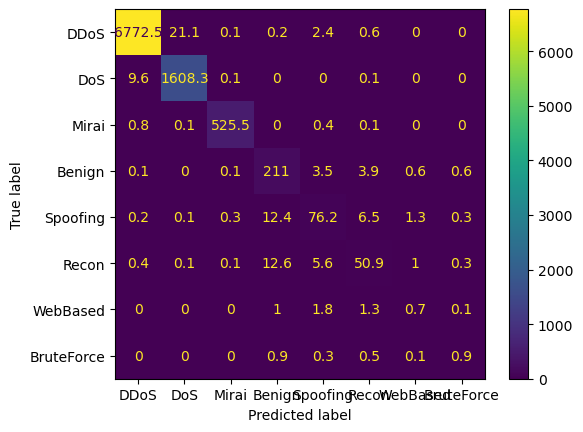

In [53]:
process_confusion_matrix(y_full_test, y_full_pred)

### Optimized

In [54]:
# redo preprocessing
best_preprocessor.fit(X_full_train)
X_full_train = pd.DataFrame(best_preprocessor.transform(X_full_train.copy()), columns=X_full_train.columns)
X_full_test = pd.DataFrame(best_preprocessor.transform(X_full_test.copy()), columns=X_full_test.columns)

# redo feature selection
X_full_train = X_full_train[best_selected_features]
X_full_test = X_full_test[best_selected_features]

# redo data balancing
X_full_train, y_full_train = fit_resample(
    X_full_train, y_full_train, best_over_threshold, best_under_threshold
)

# redo classifier building
model = build_classifier(best_model_params)

In [55]:
%%time
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.132020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5093
[LightGBM] [Info] Number of data points in the train set: 61672181, number of used features: 20


[LightGBM] [Info] Start training from score -0.819070
[LightGBM] [Info] Start training from score -2.254256
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962
[LightGBM] [Info] Start training from score -2.580962


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


CPU times: user 4h 13min 21s, sys: 7.77 s, total: 4h 13min 29s
Wall time: 5min 12s


In [56]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9911260366469337),
                ('Precision (Macro)', 0.7501364212871662),
                ('Precision (Micro)', 0.9911260366469337),
                ('Precision (Weighted)', 0.9935471556360378),
                ('Recall (Macro)', 0.8969840717498172),
                ('Recall (Micro)', 0.9911260366469337),
                ('Recall (Weighted)', 0.9911260366469337),
                ('F1 (Macro)', 0.7677249601836171),
                ('F1 (Micro)', 0.9911260366469337),
                ('F1 (Weighted)', 0.9921243851012597)])


In [57]:
process_classification_report(y_full_test, y_full_pred)

              precision    recall  f1-score   support

        DDoS   0.998581  0.997638  0.998109   6796912
         DoS   0.993662  0.992920  0.993291   1618147
       Mirai   0.995903  0.996608  0.996255    526825
      Benign   0.954923  0.905677  0.929648    219639
    Spoofing   0.909645  0.825254  0.865397     97301
       Recon   0.812773  0.793931  0.803242     70913
    WebBased   0.202754  0.850987  0.327483      4966
  BruteForce   0.132850  0.812859  0.228375      2613

    accuracy                       0.991126   9337316
   macro avg   0.750136  0.896984  0.767725   9337316
weighted avg   0.993547  0.991126  0.992124   9337316



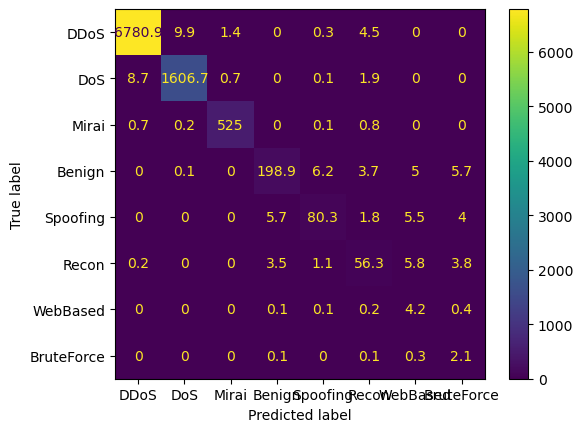

In [58]:
process_confusion_matrix(y_full_test, y_full_pred)